# **HW1-FRA503 Machine Learning**
<hr>

**Credit Card Churn Prediction**

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Athimet Aiewcharoen 63340500068
<hr>

### **Function and Import Necessary Libraries**

In [1]:
import warnings
# ignore warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns 

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV,RepeatedKFold, StratifiedKFold, cross_val_score

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Classification metrics
from sklearn.metrics import plot_confusion_matrix, classification_report,confusion_matrix ,precision_recall_curve
from sklearn import metrics


In [2]:
def diagnostic_plots(df, variable:str):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].plot.hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()  

In [3]:
def checkCorrFF(df):
    plt.figure(figsize=(20,10))
    cor = df.corr()
    # mask = np.zeros_like(cor, dtype=np.bool)
    # mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cor, annot=True, cmap='inferno')
    plt.show()

In [4]:
def checkCorrFT(df, target):
    sns.pairplot(df, hue = target)

In [5]:
def checkOutput(df, col:str, colTarget:str, output:str):
    checkdf = df.loc[df[col] == colTarget]
    return checkdf[output].value_counts()

In [6]:
def IQRdrop(df, col:str):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df.loc[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

In [7]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats,scores):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=scores, cv=cv, n_jobs=-1)
	return scores

## **Data Exploration**

There are a total of 23 features in this dataset which are:

|Feature Name|Description|Data Type|
|-|-|-|
|<font color='green'>CLIENTNUM</font>|Unique identifier for the customer holding the account|
|<font color='green'>Attrition_Flag</font>|Internal event (customer activity) variable (Existing = 1, Attrited = 0)|<font color='red'>Categorical</font> [Output]|
|<font color='green'>Customer_Age</font>|Customer's Age in Years|<font color='red'>Numerical</font>|
|<font color='green'>Gender</font>|(M = Male, F = Female)|<font color='red'>Categorical</font>|
|<font color='green'>Dependent_Count</font>|Number of dependents|<font color='red'>Numerical</font>|
|<font color='green'>Education_Level</font>|Educational Qualification of the account holder (Uneducated, High School, College, Graduate, Post-Graduate, Doctorate, Unknown)|<font color='red'>Categorical</font>|
|<font color='green'>Marital_Status</font>|(Married, Single, Divorced, Unknown)|<font color='red'>Categorical</font>|
|<font color='green'>Income_Category</font>|Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, >$120K)|<font color='red'>Categorical</font>|
|<font color='green'>Card_Category</font>|Type of Card (Blue, Silver, Gold, Platinum)</font>|<font color='red'>Categorical</font>|
|<font color='green'>Months_on_book</font>|Period of relationship with bank|<font color='red'>Numerical</font>|
|<font color='green'>Total_Relationship_Count</font>|Total no. of products held by the customer|<font color='red'>Numerical</font>|
|<font color='green'>Months_Inactive_12_mon</font>|No. of months inactive in the last 12 months|<font color='red'>Numerical</font>|
|<font color='green'>Contacts_Count_12_mon</font>|No. of Contacts in the last 12 months|<font color='red'>Numerical</font>|
|<font color='green'>Credit_Limit</font>|Credit Limit on the Credit Card|<font color='red'>Numerical</font>|
|<font color='green'>Total_Revolving_Bal</font>|Total Revolving Balance on the Credit Card|<font color='red'>Numerical</font>|
|<font color='green'>Avg_Open_To_Buy</font>|Open to Buy Credit Line (Average of last 12 months)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Amt_Chng_Q4_Q1</font>|Change in Transaction Amount (Q4 over Q1)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Trans_Amt</font>|Total Transaction Amount (Last 12 months)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Trans_Ct</font>|Total Transaction Count (Last 12 months)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Ct_Chng_Q4_Q1</font>|Change in Transaction Count (Q4 over Q1)|<font color='red'>Numerical</font>|
|<font color='green'>Avg_Utilization_Ratio</font>|Average Card Utilization Ratio|<font color='red'>Numerical</font>|
|<font color='green'>Naive_Bayes_Classifier...</font>|Naive Bayes||
|<font color='green'>Naive_Bayes_Classifier...</font>|Naive Bayes||

### **Import Dataset**

In [8]:
dfOri = df = pd.read_csv('../HWdata/credit_card_churn.csv')
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [9]:
df.tail()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
10122        Graduate         Single     $40K - $60K          Blue   
10123         Unknown       Divorced     $40K - $60K          Blue   
10124     High School        Married  Less than $40K          Blue   
10125        Graduate        Unknown     $40K - $60K          Blue   
10126        Graduate        Married  Less than $40K        Silver   

       Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  \
10122              40  ...        4003.0                 1851   
10123              25  ...        4277.0                 2186   
10124              36  ...        5409.0                    0   
10125              36  ...        5281.0                    0   
10126              25  ...       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
10122           2152.0                 0.703            15476             117   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
10122                0.857                  0.462   
10123                0.683                  0.511   
10124                0.818                  0.000   
10125                0.722                  0.000   
10126                0.649                  0.189   

       Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
10122                                           0.000191                                                                                    
10123                                           0.995270                                                                                    
10124                                           0.997880                                                                                    
10125                                           0.996710                                                                                    
10126                                           0.996620                                                                                    

       Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
10122                                           0.999810                                                                                   
10123                                           0.004729                                                                                   
10124                                           0.002118                                                                                   
10125                                           0.003294                                                                                   
10126                                           0.003377                                                                                   

[5 rows x 23 columns]

In [10]:
df.shape

(10127, 23)

We can see that this dataset has 23 features and 10127 instances.

In [11]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [12]:
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

### **Drop Unnecessary Features**

Since '<font color='orange'>CLIENTNUM</font>' is a unique classifier for each customer, we will drop this feature.
The last 2 features, '<font color='orange'>Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1</font>' and '<font color='orange'>Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2</font>', are for Naive Bayes Classifier, which we won't be using in this assignment, we will also drop these features.


In [13]:
df.drop(
['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], 
axis=1, inplace=True)
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [14]:
df.shape

(10127, 20)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

After dropping the unnecessary features, we are left with 20 features.

In which, there are:

- 6 features that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 14 features that are '<font color='green'>int64</font>' and '<font color='green'>float64</font>', which means that they are '<font color='red'>Numerical Features</font>'

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features
3. Output

**Separate Numerical Features from Dataset**

In [16]:
dfNum = df.select_dtypes(include=['int64', 'float64'])

**Separate Categorical Features from Dataset**

In [17]:
dfCate = df.select_dtypes(include=['object'])
dfCate = dfCate.iloc[:,1:]

**Separate Output from Dataset**

In [18]:
dfOut = df.iloc[:,0:1]

**Concatenate Separated Data**

In [19]:
df = pd.concat([dfNum, dfCate, dfOut], axis=1)
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer' : 1,'Attrited Customer': 0})
df2 = df.copy()
df

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
1                49                5              44   
2                51                3              36   
3                40                4              34   
4                40                3              21   
...             ...              ...             ...   
10122            50                2              40   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10122           2152.0                 0.703            15476             117   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio Gender Education_Level  \
0                    1.625                  0.061      M     High School   
1                    3.714                  0.105      F        Graduate   
2                    2.333                  0.000      M        Graduate   
3                    2.333                  0.760      F     High School   
4                    2.500                  0.000      M      Uneducated   
...                    ...                    ...    ...             ...   
10122                0.857                  0.462      M        Graduate   
10123                0.683                  0.511      M         Unknown   
10124                0.818                  0.000      F     High School   
10125                0.722                  0.000      M        Graduate   
10126      

### **Check Values of Numerical Features**

In [20]:
df.isnull().sum()

Customer_Age                0
Dependent_count             0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Gender                      0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Attrition_Flag              0
dtype: int64

In [21]:
df.describe()

Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Attrition_Flag  
count         10127.000000           10127.000000    10127.000000  
mean              0.712222               0.274894        0.839340  
std               0.238086               0.275691        0.367235  
min               0.000000               0.000000        0.000000  
25%               0.582000               0.023000        1.000000  
50%               0.702000               0.176000        1.000000  
75%               0.818000               0.503000        1.000000  
max               3.714000               0.999000        1.000000

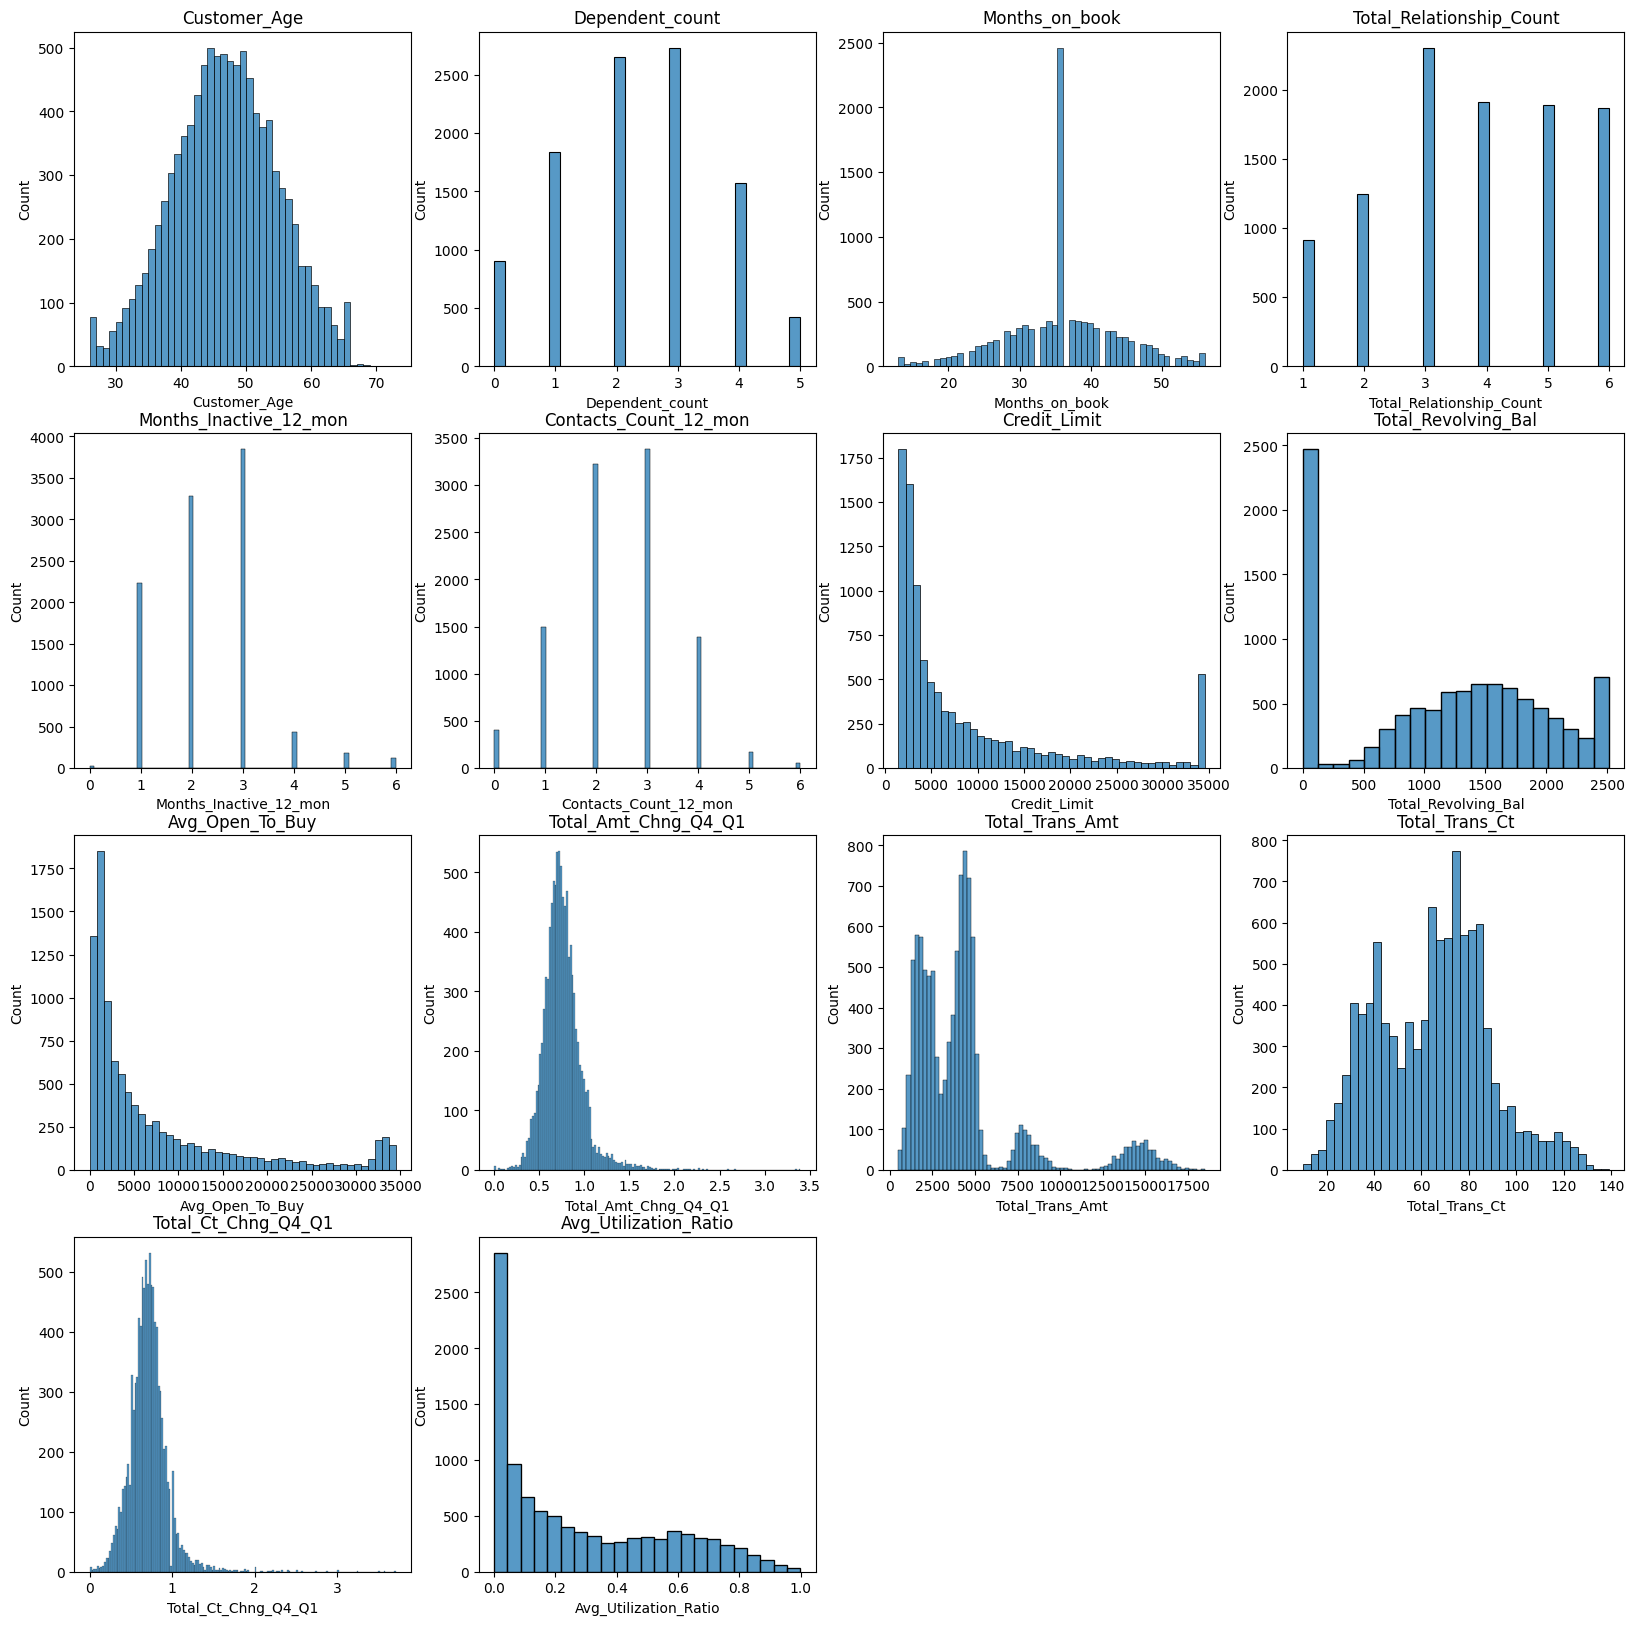

In [22]:
# plot numerical data
plt.figure(figsize=(20,20))
for idx, col in enumerate(dfNum.columns):
    plt.subplot(4, 4, idx+1)
    sns.histplot(dfNum[col], kde=False)
    plt.title(col)

What we got from plotting values of numerical features:

|Feature Names|Normally Distributed|
|-|-|
|Customer_Age|Yes|
|Dependent_Count|Yes|
|Months_on_book|Yes|
|Total_Relationship_Count|No|
|Months_Inactive_12_mon|Almost|
|Contacts_Count_12_mon|Yes|
|Credit_Limit|No|
|Total_Revolving_Bal|No|
|Avg_Open_To_Buy|No|
|Total_Amt_Chng_Q4_Q1|Almost|
|Total_Trans_Amt|No|
|Total_Trans_Ct|Almost|
|Total_Ct_Chng_Q4_Q1|Almost|
|Avg_Utilization_Ratio|No|

### **Check Values of Categorical Features**

In [23]:
df['Gender'].value_counts()

F    5358
M    4769
Name: Gender, dtype: int64

In [24]:
# Calculate Percentage of Gender
100*df['Gender'].value_counts()/len(df)

F    52.908068
M    47.091932
Name: Gender, dtype: float64

In [25]:
df['Education_Level'].value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [26]:
# Calculate Percentage of Education Level
100*df['Education_Level'].value_counts()/len(df)

Graduate         30.887726
High School      19.877555
Unknown          14.999506
Uneducated       14.683519
College          10.002962
Post-Graduate     5.095290
Doctorate         4.453441
Name: Education_Level, dtype: float64

In [27]:
df['Marital_Status'].value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

In [28]:
# Calculate Percentage of Marital Status
100*df['Marital_Status'].value_counts()/len(df)

Married     46.282216
Single      38.935519
Unknown      7.396070
Divorced     7.386195
Name: Marital_Status, dtype: float64

In [29]:
df['Income_Category'].value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

In [30]:
# Calculate Percentage of Income Category
100*df['Income_Category'].value_counts()/len(df)

Less than $40K    35.163425
$40K - $60K       17.675521
$80K - $120K      15.157500
$60K - $80K       13.844179
Unknown           10.980547
$120K +            7.178829
Name: Income_Category, dtype: float64

In [31]:
df['Card_Category'].value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [32]:
# Calculate Percentage of Card Category
100*df['Card_Category'].value_counts()/len(df)

Blue        93.176656
Silver       5.480399
Gold         1.145453
Platinum     0.197492
Name: Card_Category, dtype: float64

<AxesSubplot: title={'center': 'Card Category'}>

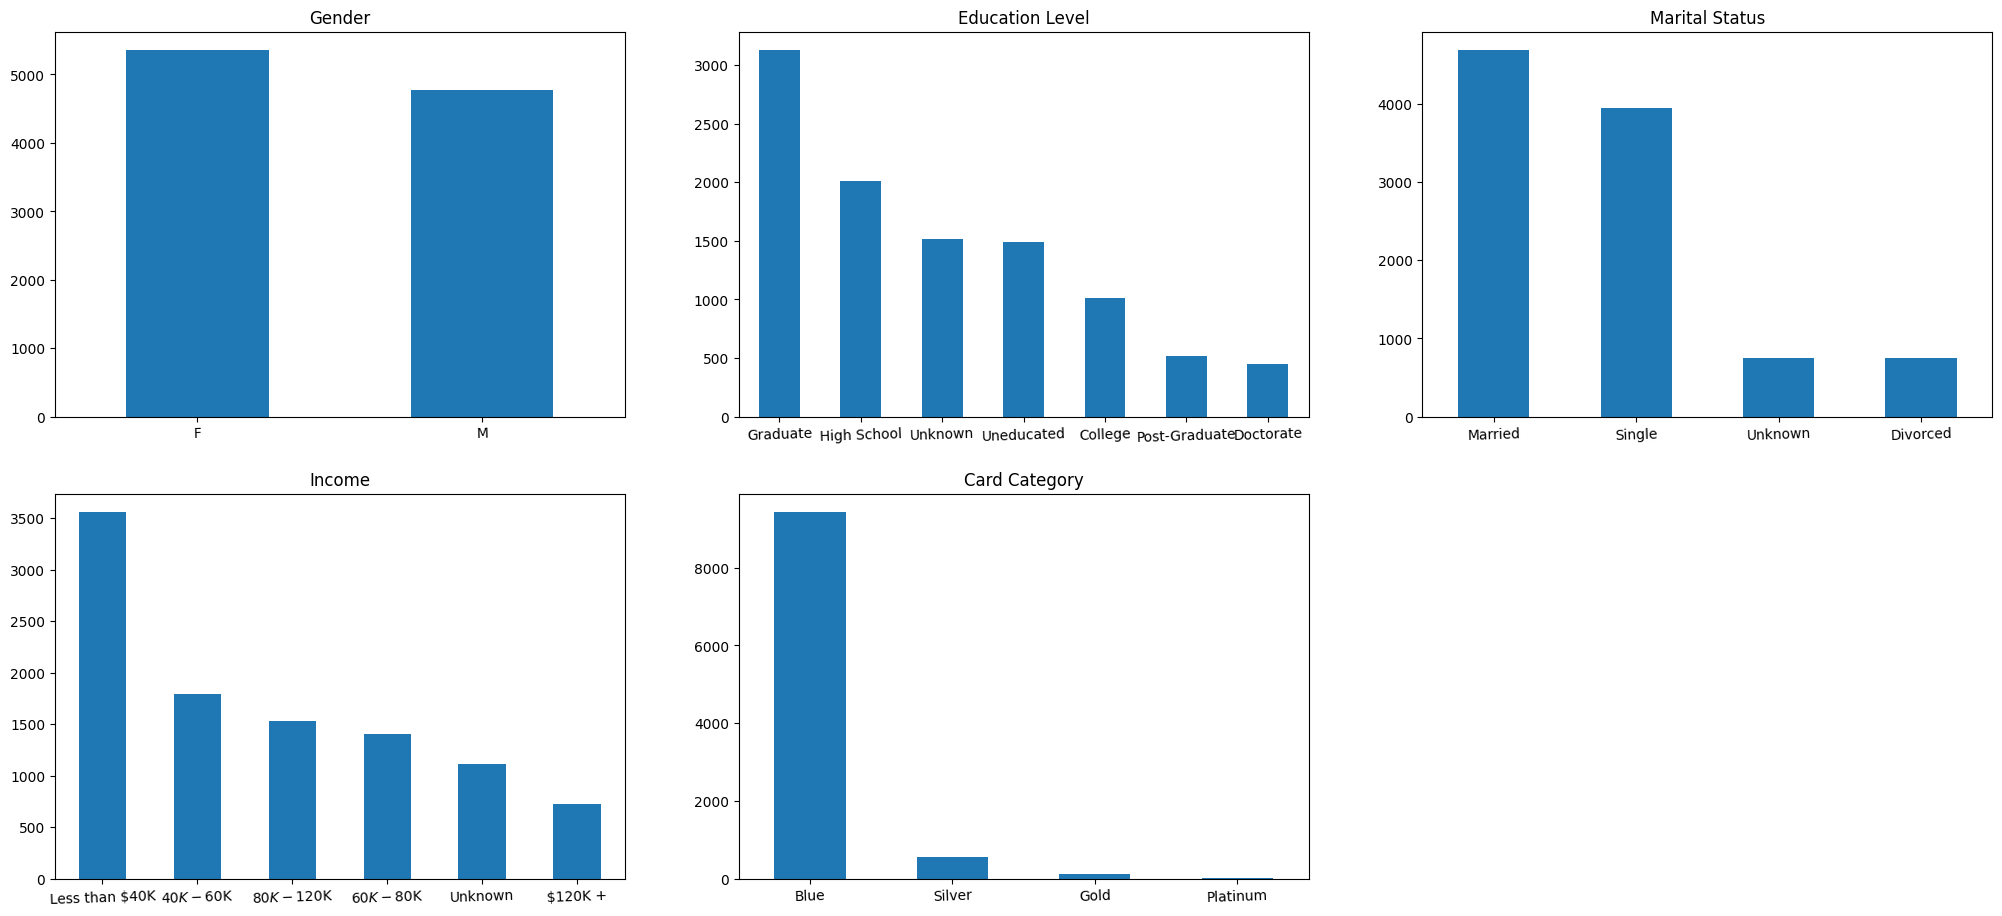

In [33]:
# plot categorical data
plt.figure(figsize=(25,11))
plt.subplot(231) 
df['Gender'].value_counts(normalize=False).plot.bar(title= 'Gender',rot=2) 
plt.subplot(232) 
df['Education_Level'].value_counts(normalize=False).plot.bar(title= 'Education Level',rot=2) 
plt.subplot(233) 
df['Marital_Status'].value_counts(normalize=False).plot.bar(title= 'Marital Status',rot=2)
plt.subplot(234) 
df['Income_Category'].value_counts(normalize=False).plot.bar(title= 'Income',rot=2)
plt.subplot(235) 
df['Card_Category'].value_counts(normalize=False).plot.bar(title= 'Card Category',rot=2)

What we got from plotting values of categorical features:

|Feature Names|What we got|
|-|-|
|Gender|There are nearly the same amount of male and female.|
|Education_Level|Most of the people in this dataset are 'Graduate' and around 15% of the people are 'Unknown'|
|Marital_Status|46% of this data are 'Married', 39% are 'Single' and the rest are 'Unknown' or 'Divorced'|
|Income_Category|Most people in this dataset have 'less than 40K' income|
|Card_Category|People in this dataset mostly hold blue cards (more than 93%) and the rest hold the other 3 cards (less than 7%).|

### **Separate Attrition_Flag**

**Attrited Customers**

In [34]:
dfAtt = df[df['Attrition_Flag'] == 0]
dfAtt

Customer_Age  Dependent_count  Months_on_book  \
21               62                0              49   
39               66                0              56   
51               54                1              40   
54               56                2              36   
61               48                2              35   
...             ...              ...             ...   
10119            55                3              47   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
21                            2                       3   
39                            5                       4   
51                            2                       3   
54                            1                       3   
61                            2                       4   
...                         ...                     ...   
10119                         4                       3   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
21                         3        1438.3                    0   
39                         3        7882.0                  605   
51                         1        1438.3                  808   
54                         3       15769.0                    0   
61                         4       34516.0                    0   
...                      ...           ...                  ...   
10119                      3       14657.0                 2517   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
21              1438.3                 1.047              692              16   
39              7277.0                 1.052              704              16   
51               630.3                 0.997              705              19   
54             15769.0                 1.041              602              15   
61             34516.0                 0.763              691              15   
...                ...                   ...              ...             ...   
10119          12140.0                 0.166             6009              53   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio Gender Education_Level  \
21                   0.600                  0.000      F        Graduate   
39                   0.143                  0.077      F       Doctorate   
51                   0.900                  0.562      F        Graduate   
54                   0.364                  0.000      M        Graduate   
61                   0.500                  0.000      M        Graduate   
...                    ...                    ...    ...             ...   
10119                0.514                  0.172      F      Uneducated   
10123                0.683                  0.511      M         Unknown   
10124                0.818                  0.000      F     High School   
10125                0.722                  0.000      M        Graduate   
10126      

**Existing Customers**

In [35]:
dfExist = df[df['Attrition_Flag'] == 1]
dfExist

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
1                49                5              44   
2                51                3              36   
3                40                4              34   
4                40                3              21   
...             ...              ...             ...   
10116            46                5              36   
10117            57                2              40   
10120            54                1              34   
10121            56                1              50   
10122            50                2              40   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10116                         1                       2   
10117                         6                       3   
10120                         5                       2   
10121                         4                       1   
10122                         3                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10116                      3       13187.0                 2241   
10117                      4       17925.0                 1909   
10120                      0       13940.0                 2109   
10121                      4        3688.0                  606   
10122                      3        4003.0                 1851   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10116          10946.0                 0.689            15354             112   
10117          16016.0                 0.712            17498             111   
10120          11831.0                 0.660            15577             114   
10121           3082.0                 0.570            14596             120   
10122           2152.0                 0.703            15476             117   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio Gender Education_Level  \
0                    1.625                  0.061      M     High School   
1                    3.714                  0.105      F        Graduate   
2                    2.333                  0.000      M        Graduate   
3                    2.333                  0.760      F     High School   
4                    2.500                  0.000      M      Uneducated   
...                    ...                    ...    ...             ...   
10116                0.931                  0.170      M         College   
10117                0.820                  0.106      M        Graduate   
10120                0.754                  0.151      M     High School   
10121                0.791                  0.164      F        Graduate   
10122      

### **Plot Features of Separated Attrition_Flag**

**Attrited Customers** (Categorical Features)

<AxesSubplot: title={'center': 'Card Category'}>

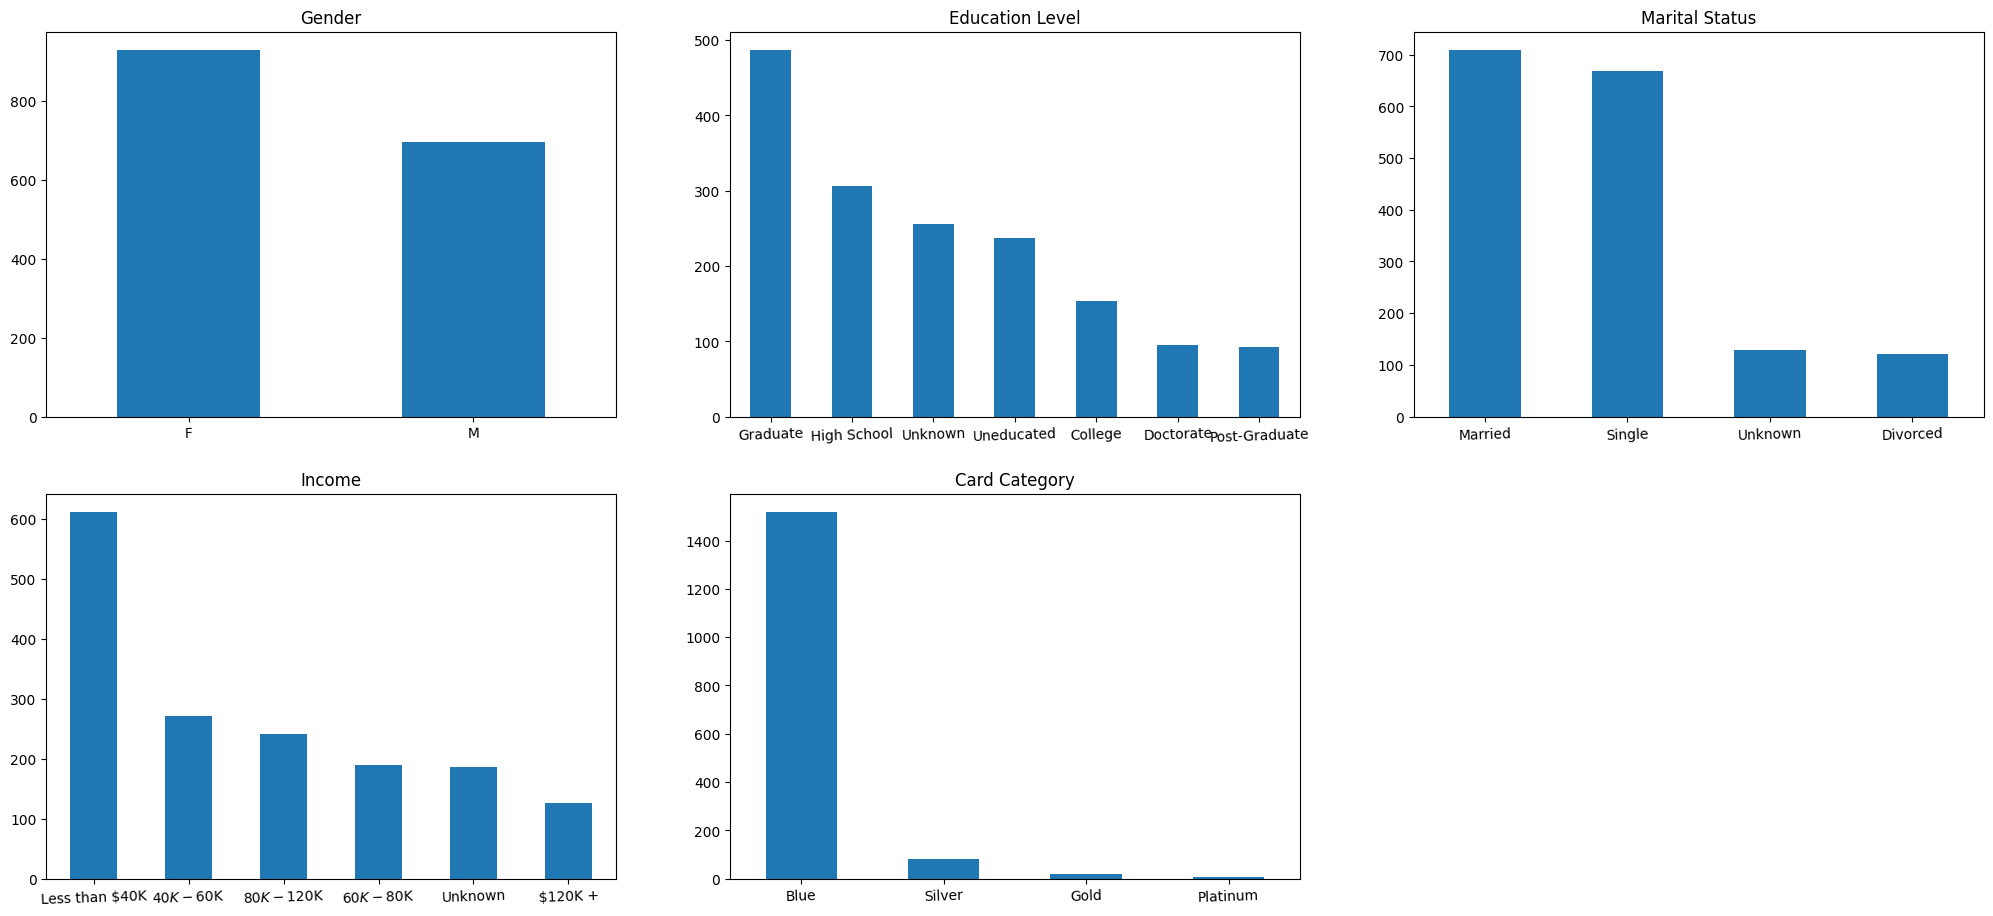

In [36]:
# plot categorical data
plt.figure(figsize=(25,11))
plt.subplot(231) 
dfAtt['Gender'].value_counts(normalize=False).plot.bar(title= 'Gender',rot=2) 
plt.subplot(232) 
dfAtt['Education_Level'].value_counts(normalize=False).plot.bar(title= 'Education Level',rot=2) 
plt.subplot(233) 
dfAtt['Marital_Status'].value_counts(normalize=False).plot.bar(title= 'Marital Status',rot=2)
plt.subplot(234) 
dfAtt['Income_Category'].value_counts(normalize=False).plot.bar(title= 'Income',rot=2)
plt.subplot(235) 
dfAtt['Card_Category'].value_counts(normalize=False).plot.bar(title= 'Card Category',rot=2)

**Attrited Customers** (Numerical Features)

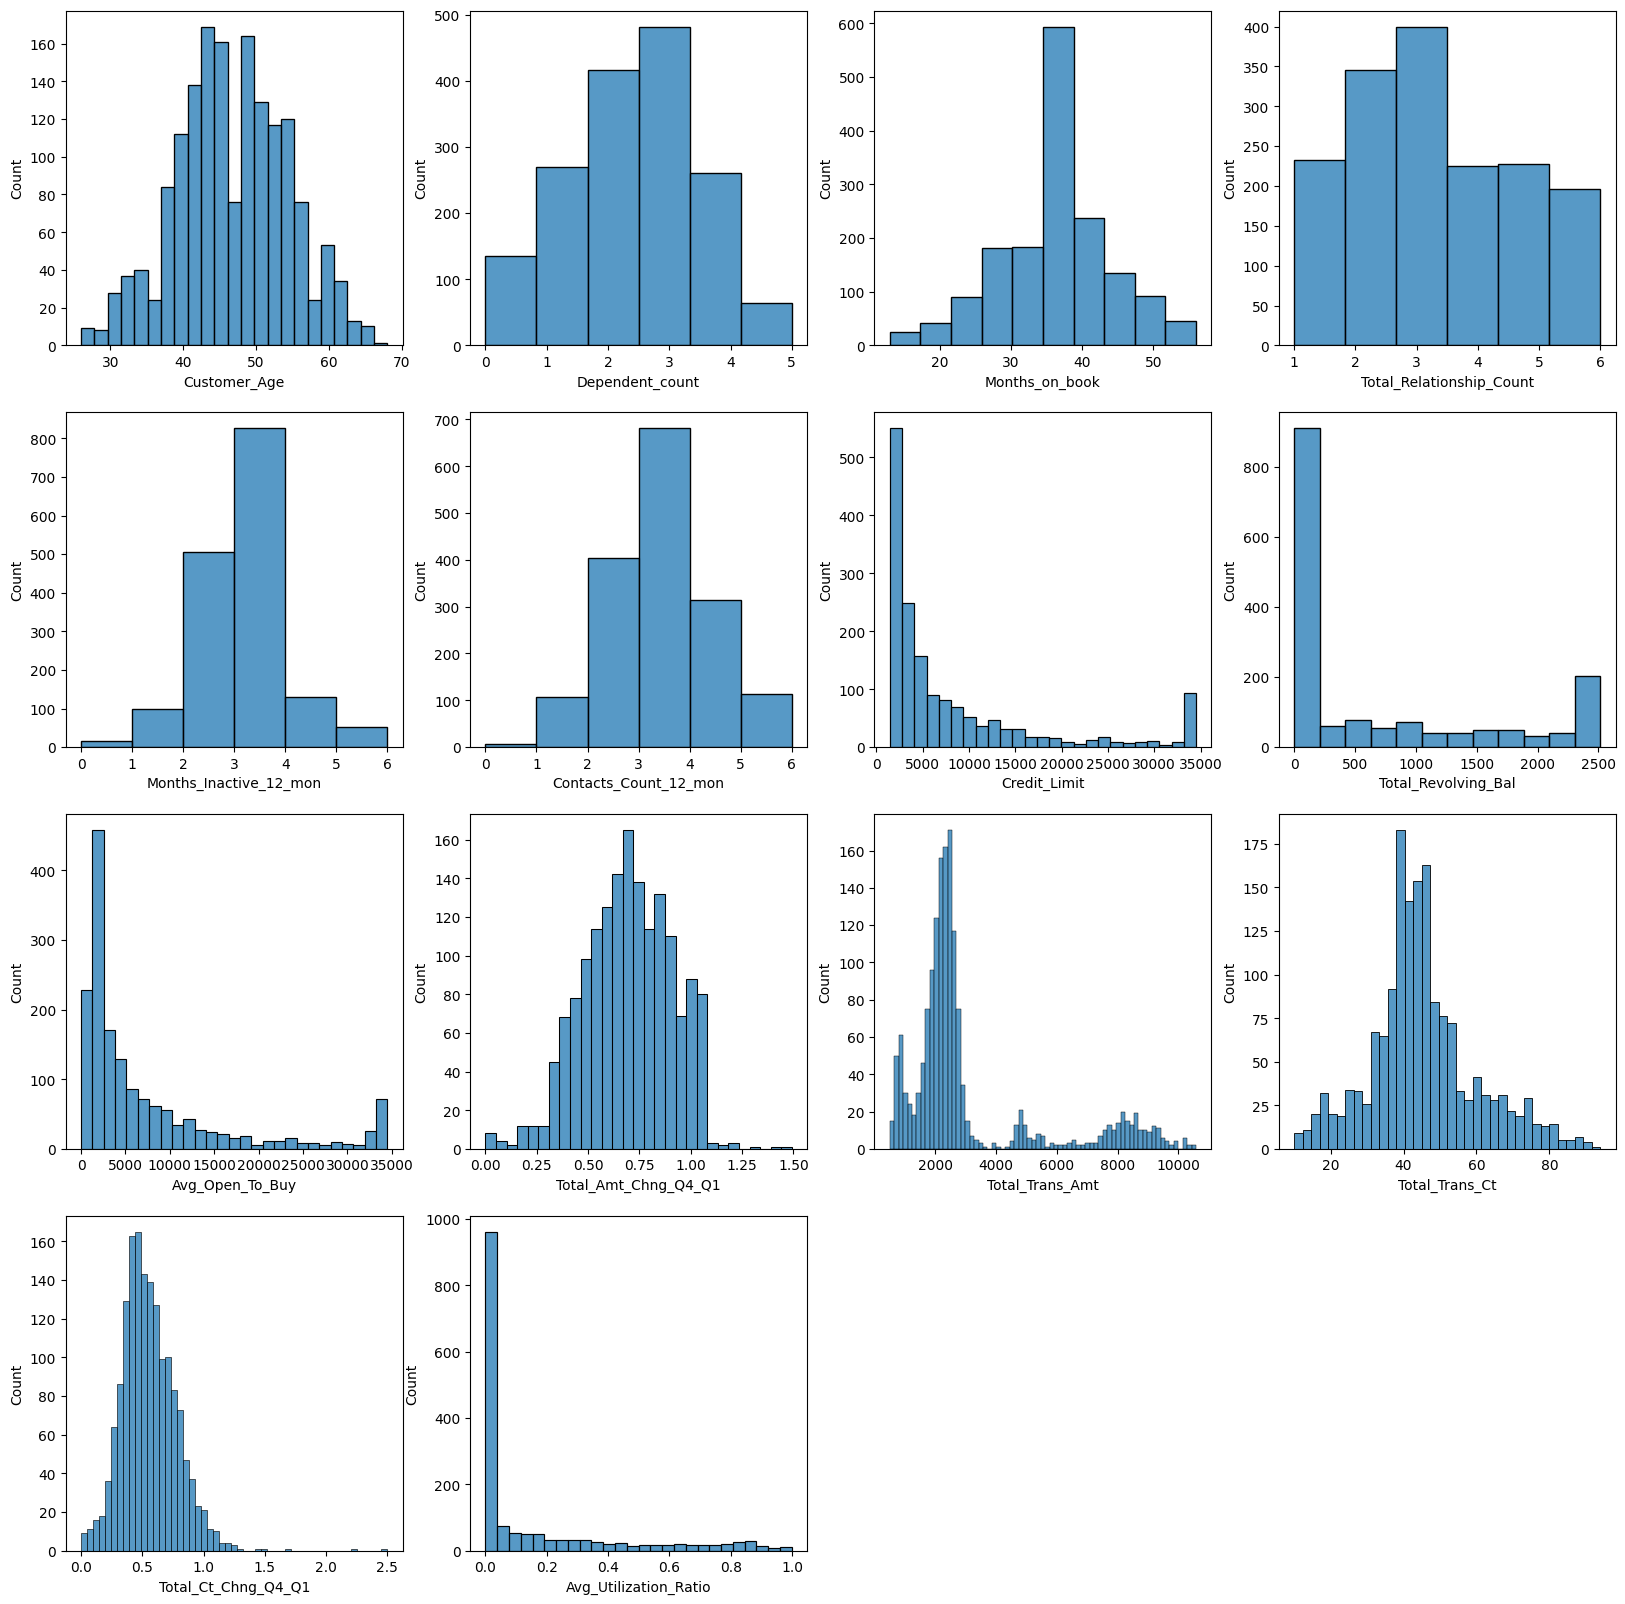

In [37]:
# plot numerical data
plt.figure(figsize=(20,20))

for idx, col in enumerate(dfNum.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(4,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(dfAtt[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(dfAtt[col],bins=10)
        else:
            sns.histplot(dfAtt[col])

**Existing Customers** (Categorical Features)

<AxesSubplot: title={'center': 'Card Category'}>

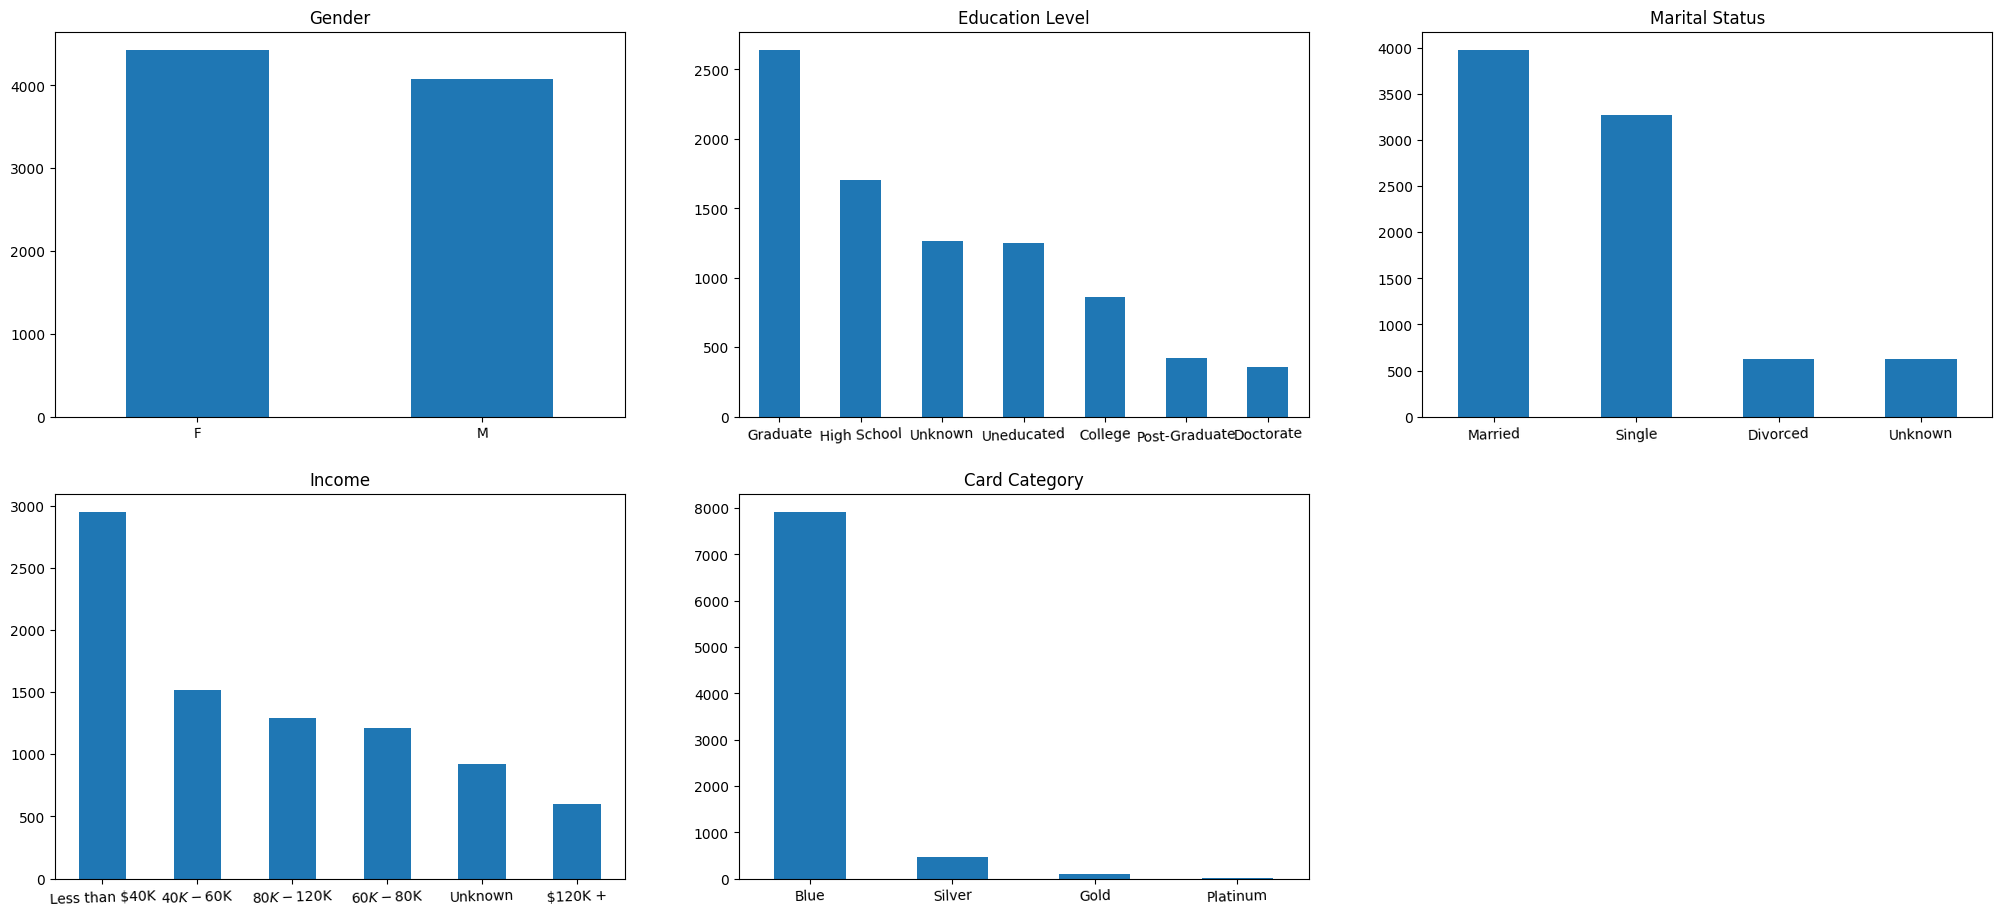

In [38]:
# plot categorical data
plt.figure(figsize=(25,11))
plt.subplot(231) 
dfExist['Gender'].value_counts(normalize=False).plot.bar(title= 'Gender',rot=2) 
plt.subplot(232) 
dfExist['Education_Level'].value_counts(normalize=False).plot.bar(title= 'Education Level',rot=2) 
plt.subplot(233) 
dfExist['Marital_Status'].value_counts(normalize=False).plot.bar(title= 'Marital Status',rot=2)
plt.subplot(234) 
dfExist['Income_Category'].value_counts(normalize=False).plot.bar(title= 'Income',rot=2)
plt.subplot(235) 
dfExist['Card_Category'].value_counts(normalize=False).plot.bar(title= 'Card Category',rot=2)

**Existing Customers** (Numerical Features)

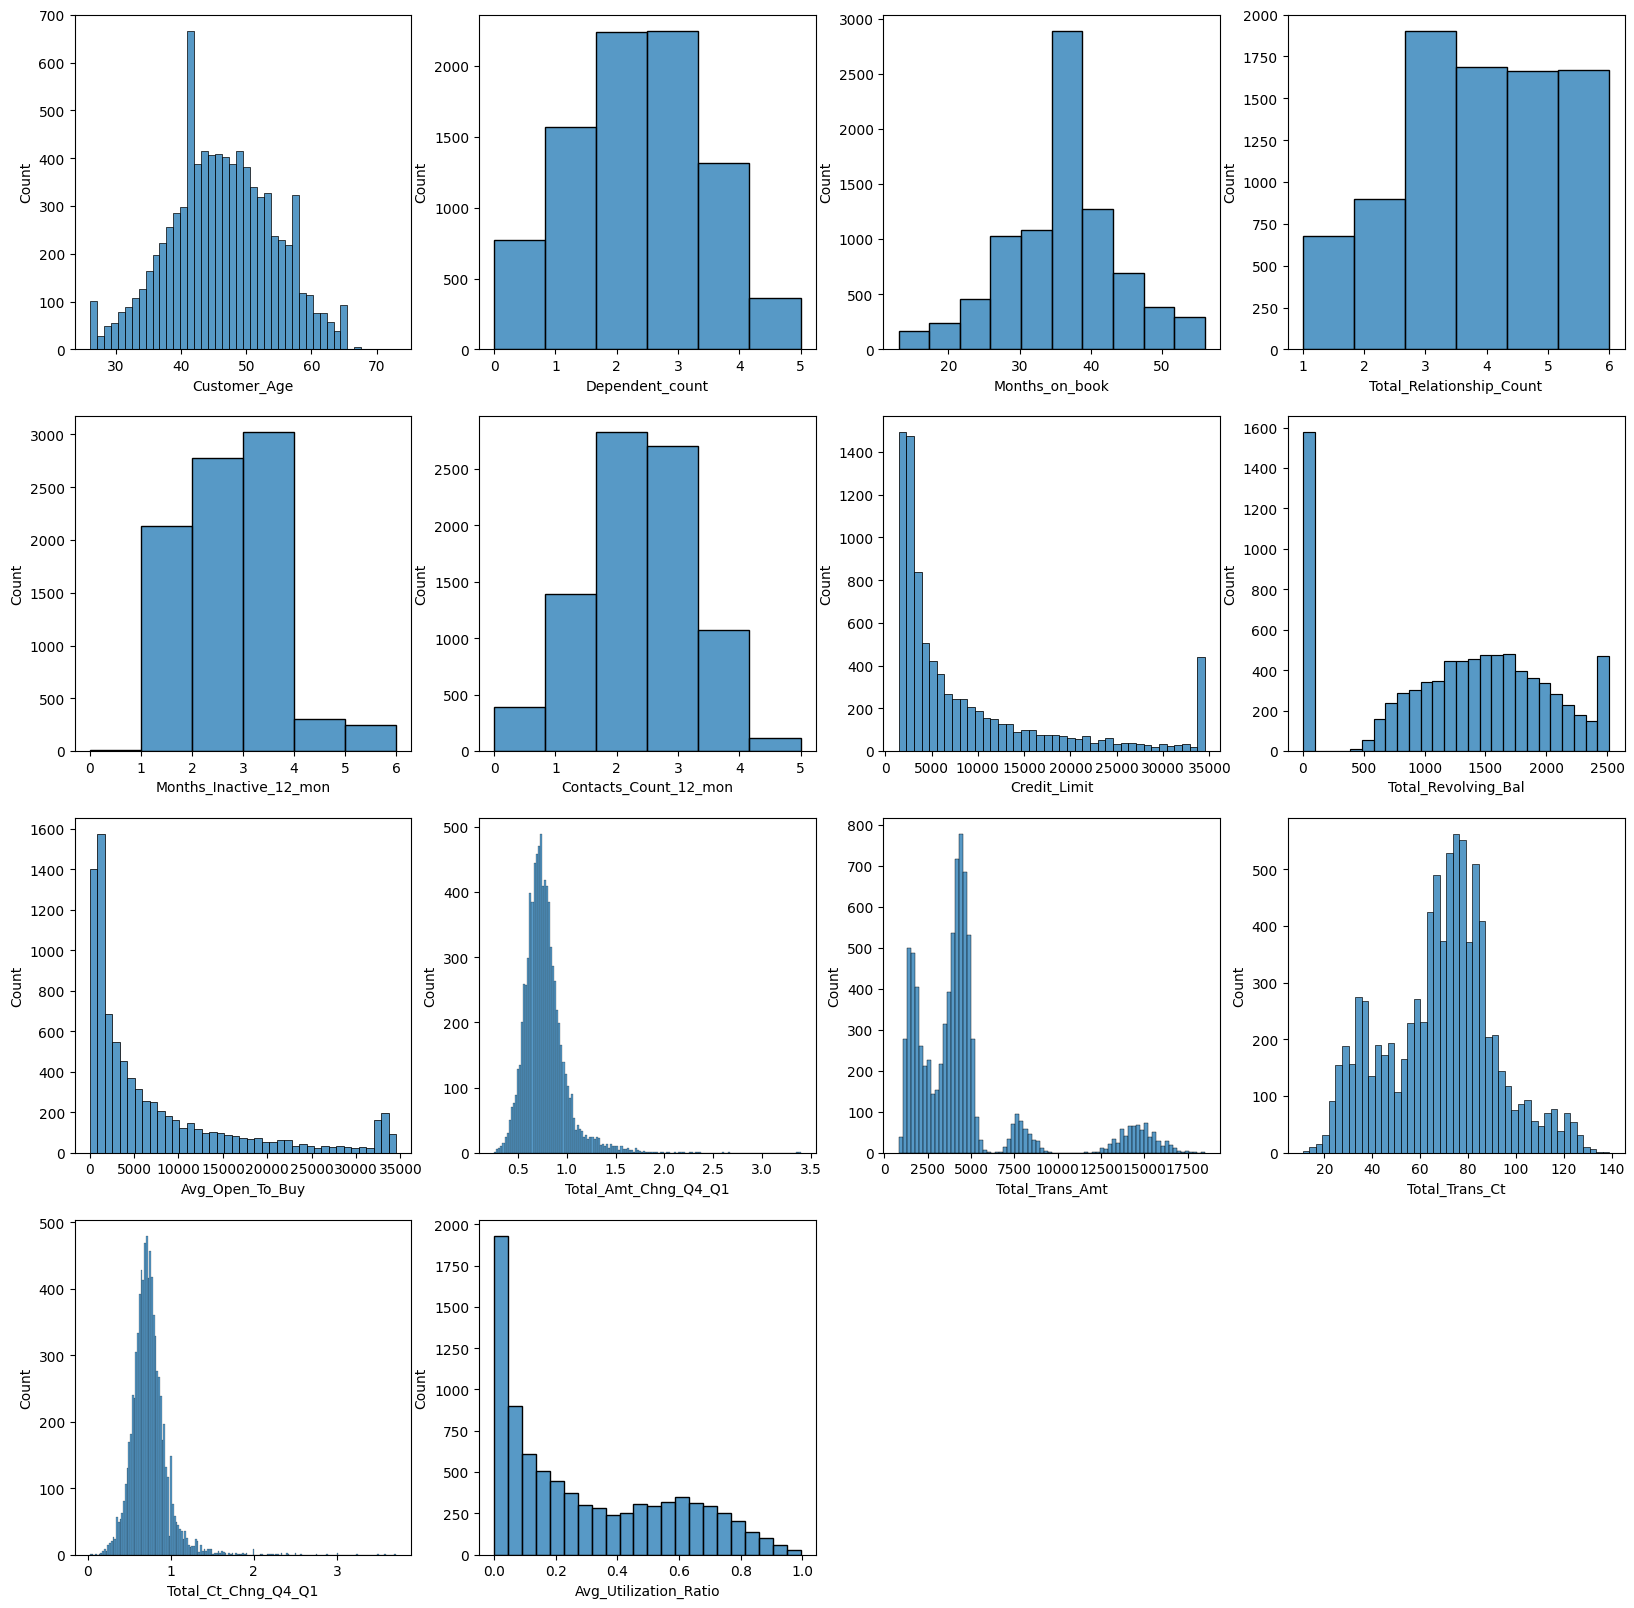

In [39]:
# plot numerical data
plt.figure(figsize=(20,20))

for idx, col in enumerate(dfNum.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(4,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(dfExist[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(dfExist[col],bins=10)
        else:
            sns.histplot(dfExist[col])

### **Pairplot Interesting Features**

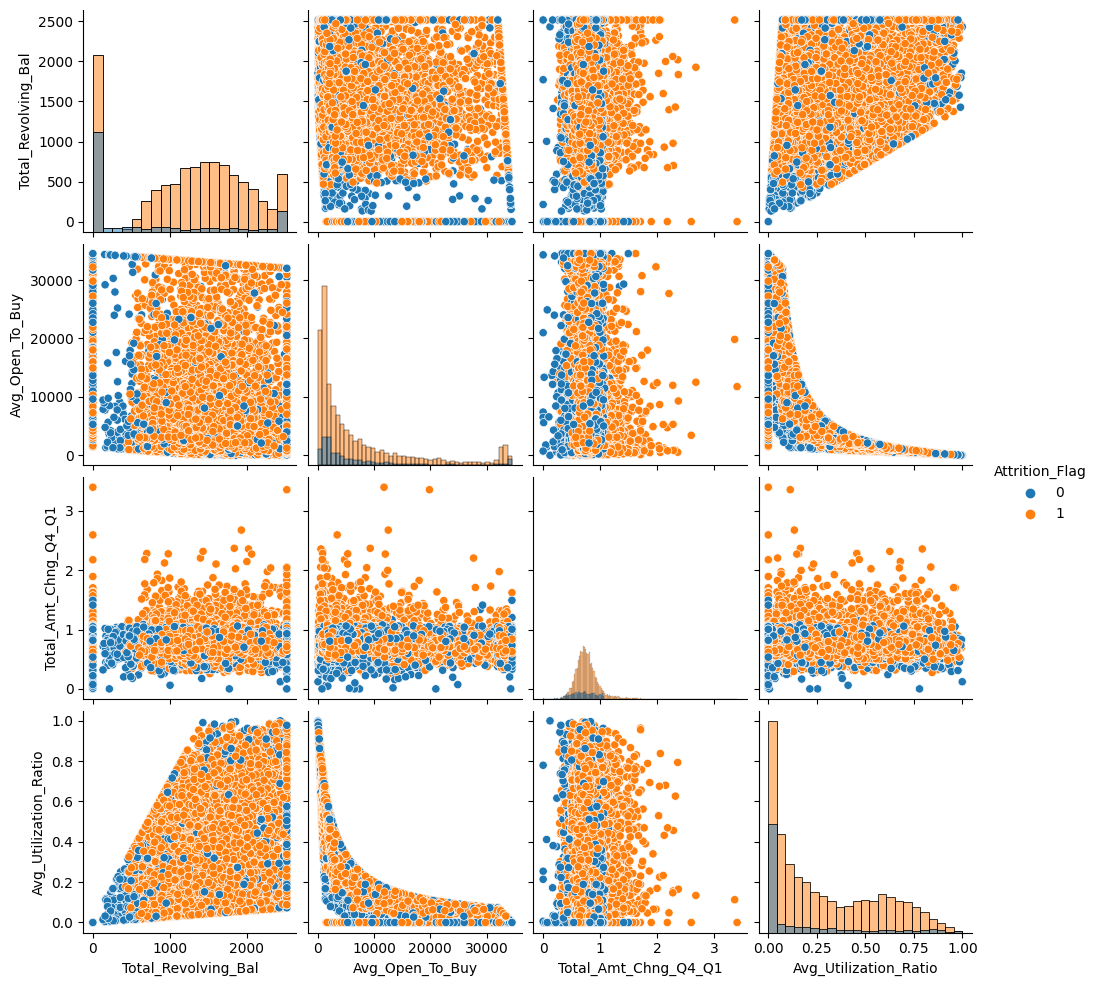

In [40]:
sns.pairplot(df[['Attrition_Flag', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1','Avg_Utilization_Ratio']], diag_kind="hist", hue="Attrition_Flag")

Good and Bad things of this dataset:

|Good Things|Explanation|
|-|-|
|Data Distribution|Most Numerical data are normally distributed.|
|Filled Data in Numerical Features|There are no missing data (NaN) or unknown in numerical features of this dataset.|

<hr>

|Bad Things|Explanation|
|-|-|
|Data Explanation|Most features come with little to no explanation or bad explanation, eg. Avg_Open_To_Buy.|
|'Card_Category' Features|This feature's data are mostly 'Blue' (around 93%).|
|Unknown Data|Unclear explanation of what unknown data means and there are a lot of them in categorical features.|
|Data Variation|As we can see when pairplotting, variance between features are quite low and variance within class are quite high, which means that data variation is very bad.|

**NOTE**: For all 'Unknown' data in categorical features, we assumed 'Unknown' as a type of data because there are quite a lot of 'Unknown' data.

Furthermore, because we are dealing with a credit card dataset, which can be considered as a dataset provided by a bank, those 'Unknown' data might be undisclosed information of the customers.

### **Check Correlation between Numerical Features**

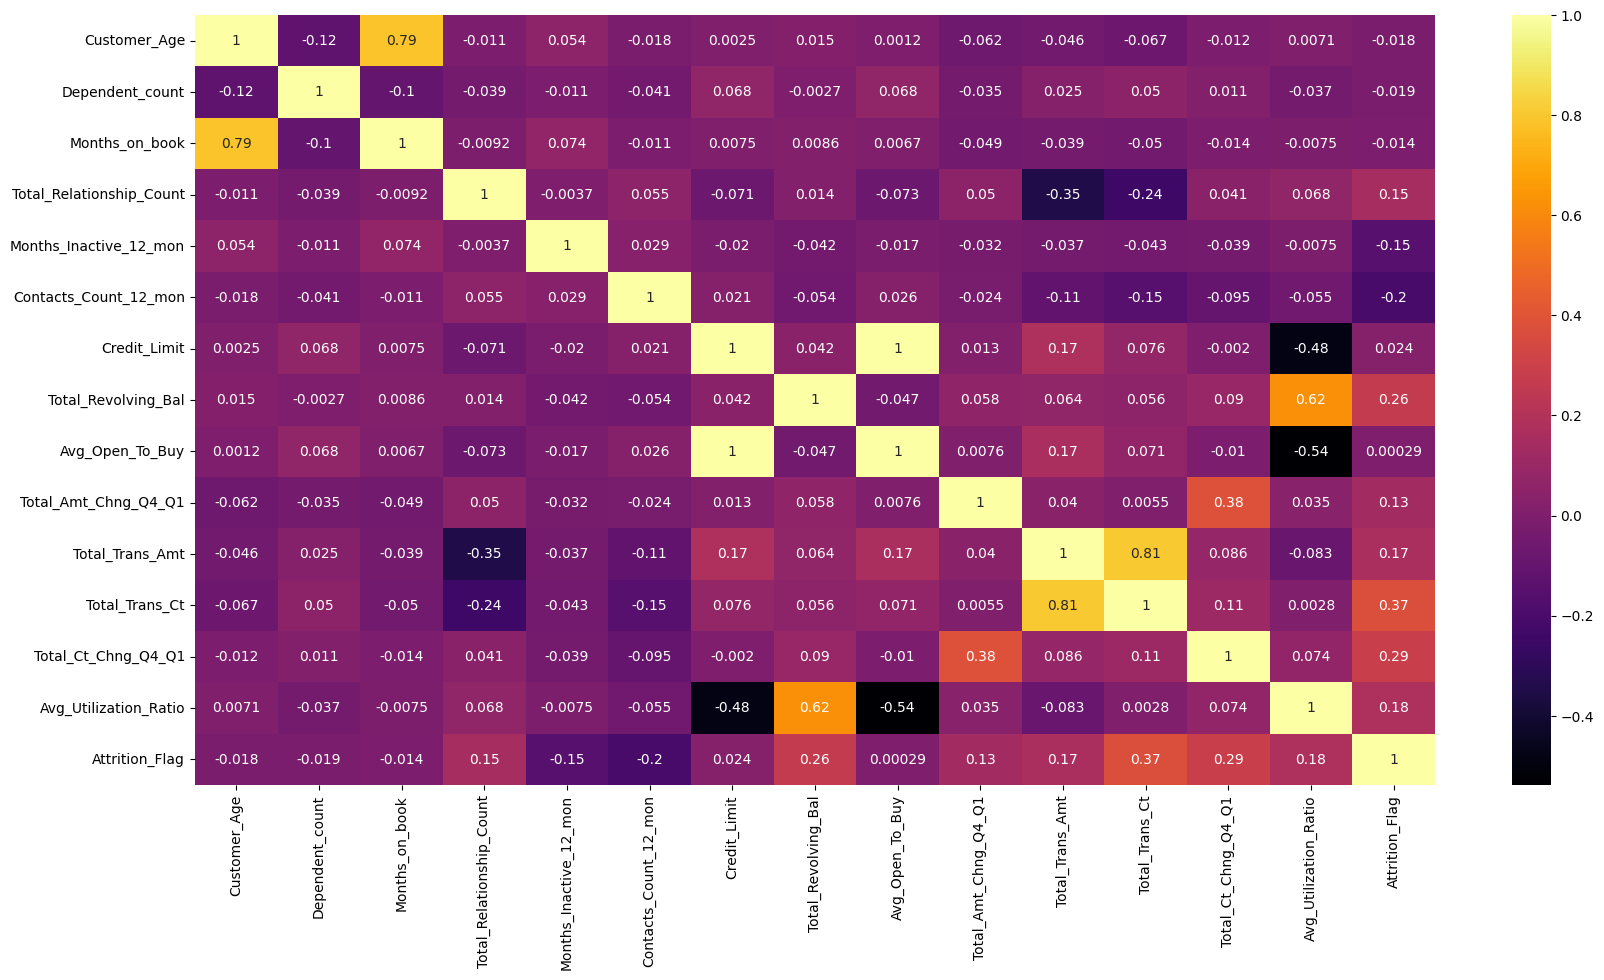

In [41]:
checkCorrFF(df)

From the heatmap above, we can drop these features:

|Feature Names|Reasons|
|-|-|
|Customer_Age|Looking at the heatmap, it correlates with 'Months_on_Book' (79%). We assumed that 'Months_on_Book' is more useful than 'Customer_Age'.|
|Credit_Limit|Looking at the heatmap, 'Credit_Limit' and 'Avg_Open_To_Buy' perfectly correlate to each other.|
|Total_Trans_Amt|Looking at the heatmap, it correlates with 'Total_Trans_Ct' (81%) and correlates with other features quite a lot.|
|Total_Amt_Chng_Q4_Q1|Looking at the heatmap, it correlates with 'Total_Ct_Chng_Q4_Q1' (38%).|
|Avg_Utilization_Ratio|Looking at the heatmap, it correlates too much with 3 features, 'Credit_Limit', 'Total_Revolving_Bal' and 'Avg_Open_To_Buy'.|

## **Model Training** (Raw Data)

In [42]:
#get the dummy variables for the categorical variables
dfbm = pd.get_dummies(df)

xbm = dfbm.drop(['Attrition_Flag'], axis = 1)
ybm = dfbm['Attrition_Flag']

xbm_train,xbm_test,ybm_train,ybm_test = train_test_split(xbm,ybm,test_size = 0.2,random_state = 0)

clfbm = LogisticRegression()
clfbm.fit(xbm_train,ybm_train)
print("model score: %.8f" % clfbm.score(xbm_test, ybm_test))

model score: 0.89338598


### **Predict using Train Data**

In [43]:
# Classification report
ybm_pred_train = clfbm.predict(xbm_train)
print("Classification report on Train data\n=======================")
print(classification_report(y_true=ybm_train, y_pred=ybm_pred_train))
print("Confusion matrix on Train data\n=======================")

print(confusion_matrix(y_true=ybm_train, y_pred=ybm_pred_train))

Classification report on Train data
              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1318
           1       0.91      0.97      0.94      6783

    accuracy                           0.89      8101
   macro avg       0.83      0.73      0.77      8101
weighted avg       0.88      0.89      0.88      8101

Confusion matrix on Train data
[[ 654  664]
 [ 220 6563]]


### **Predict using Test Data**

In [44]:
# Classification report
ybm_pred_test = clfbm.predict(xbm_test)
print("Classification report on Test data\n=======================")
print(classification_report(y_true=ybm_test, y_pred=ybm_pred_test))
print("Confusion matrix on Test data\n=======================")

print(confusion_matrix(y_true=ybm_test, y_pred=ybm_pred_test))

Classification report on Test data
              precision    recall  f1-score   support

           0       0.72      0.49      0.58       309
           1       0.91      0.97      0.94      1717

    accuracy                           0.89      2026
   macro avg       0.82      0.73      0.76      2026
weighted avg       0.88      0.89      0.88      2026

Confusion matrix on Test data
[[ 152  157]
 [  59 1658]]


# **Data Preprocessing 1**

### **Remove Outliers**

#### **Plot Histogram**

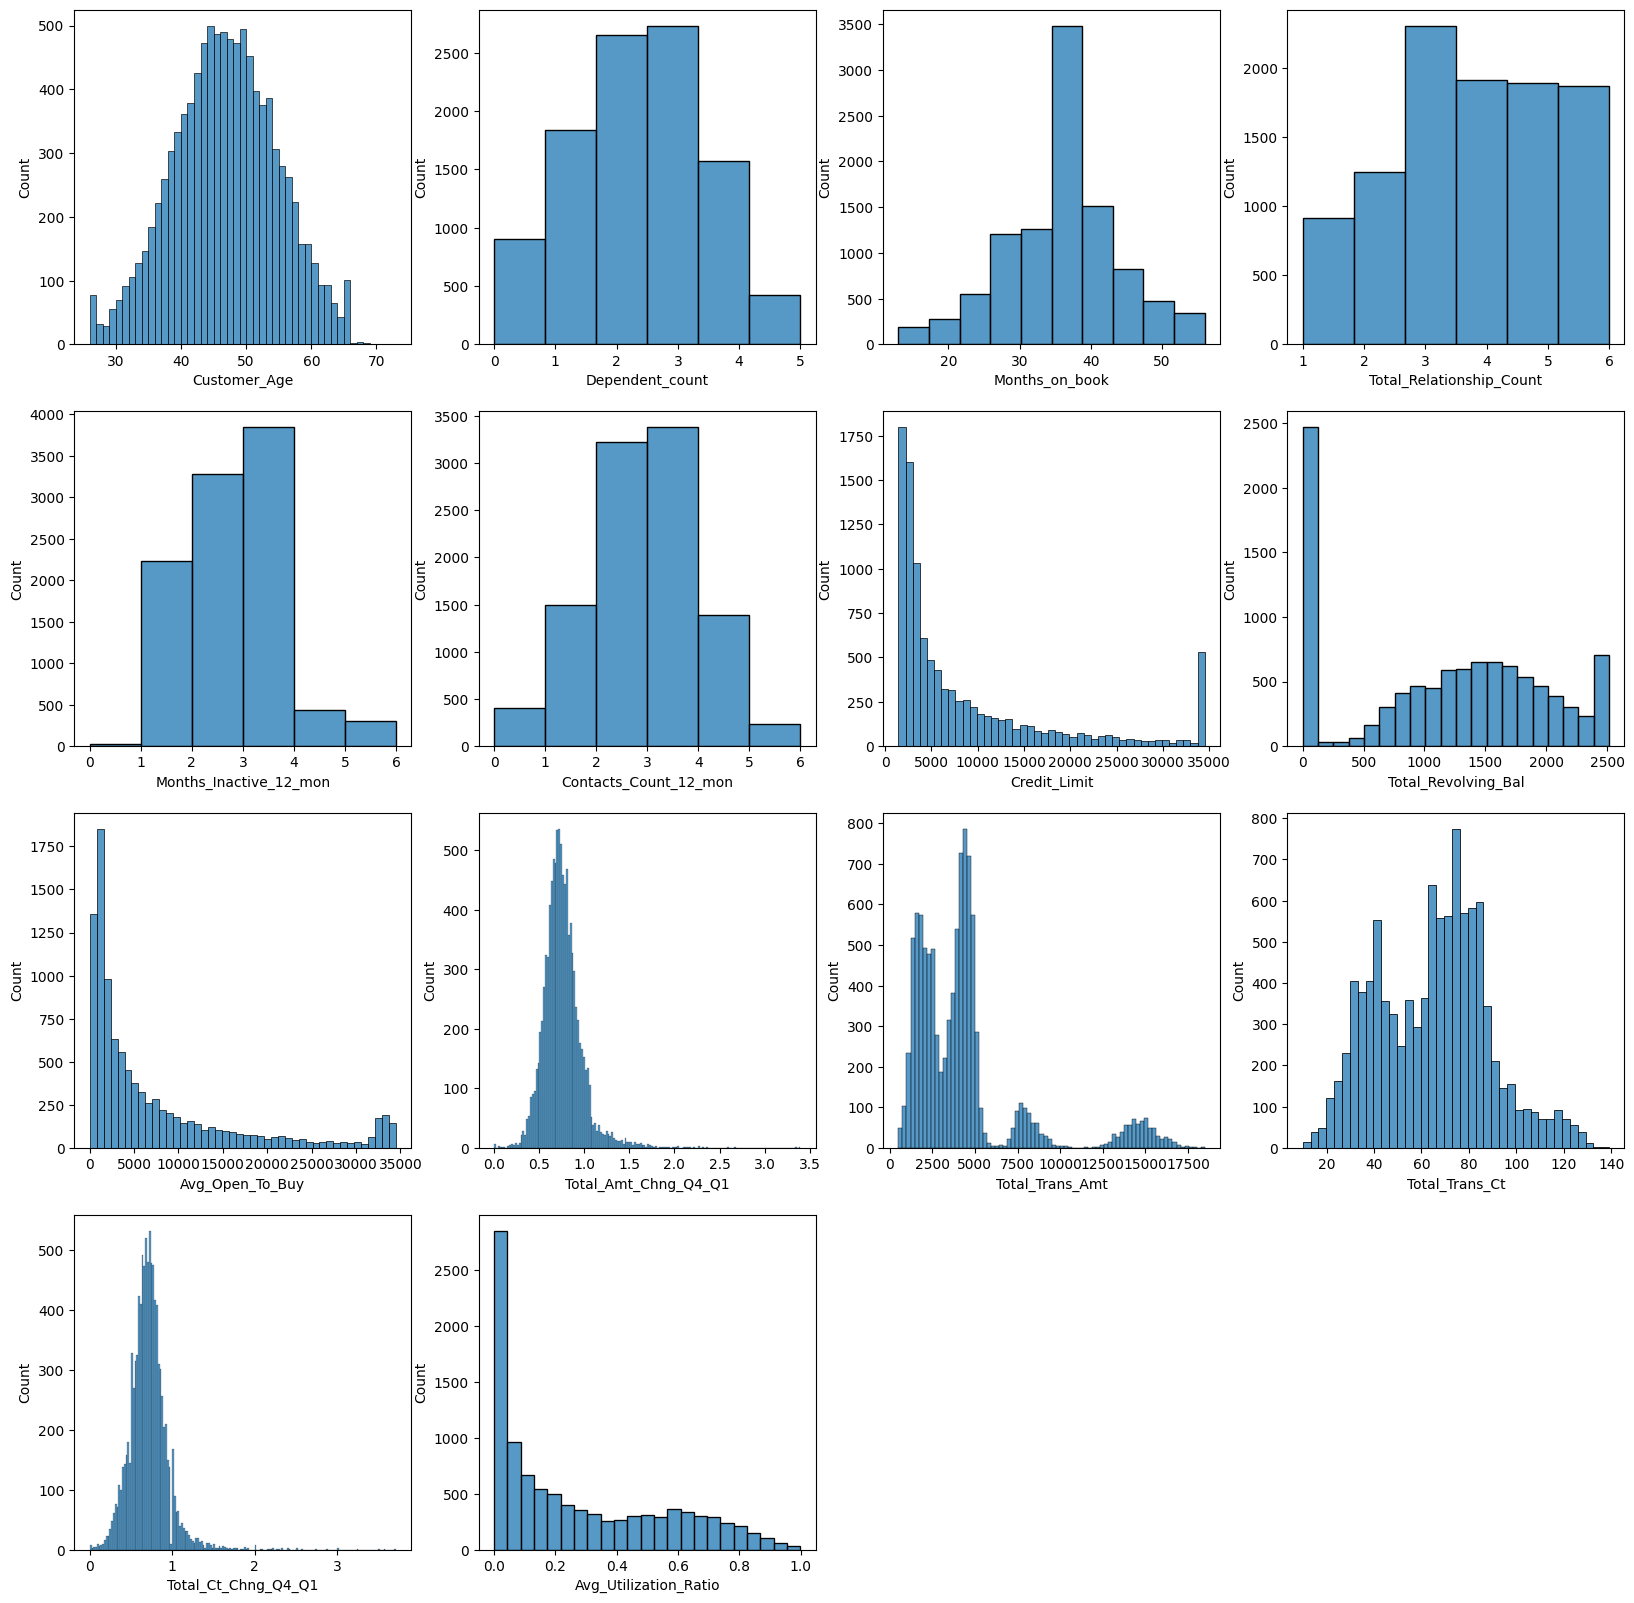

In [45]:
# plot numerical data
plt.figure(figsize=(20,20))

for idx, col in enumerate(dfNum.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(4,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df[col],bins=10)
        else:
            sns.histplot(df[col])

#### **Strip Plot**

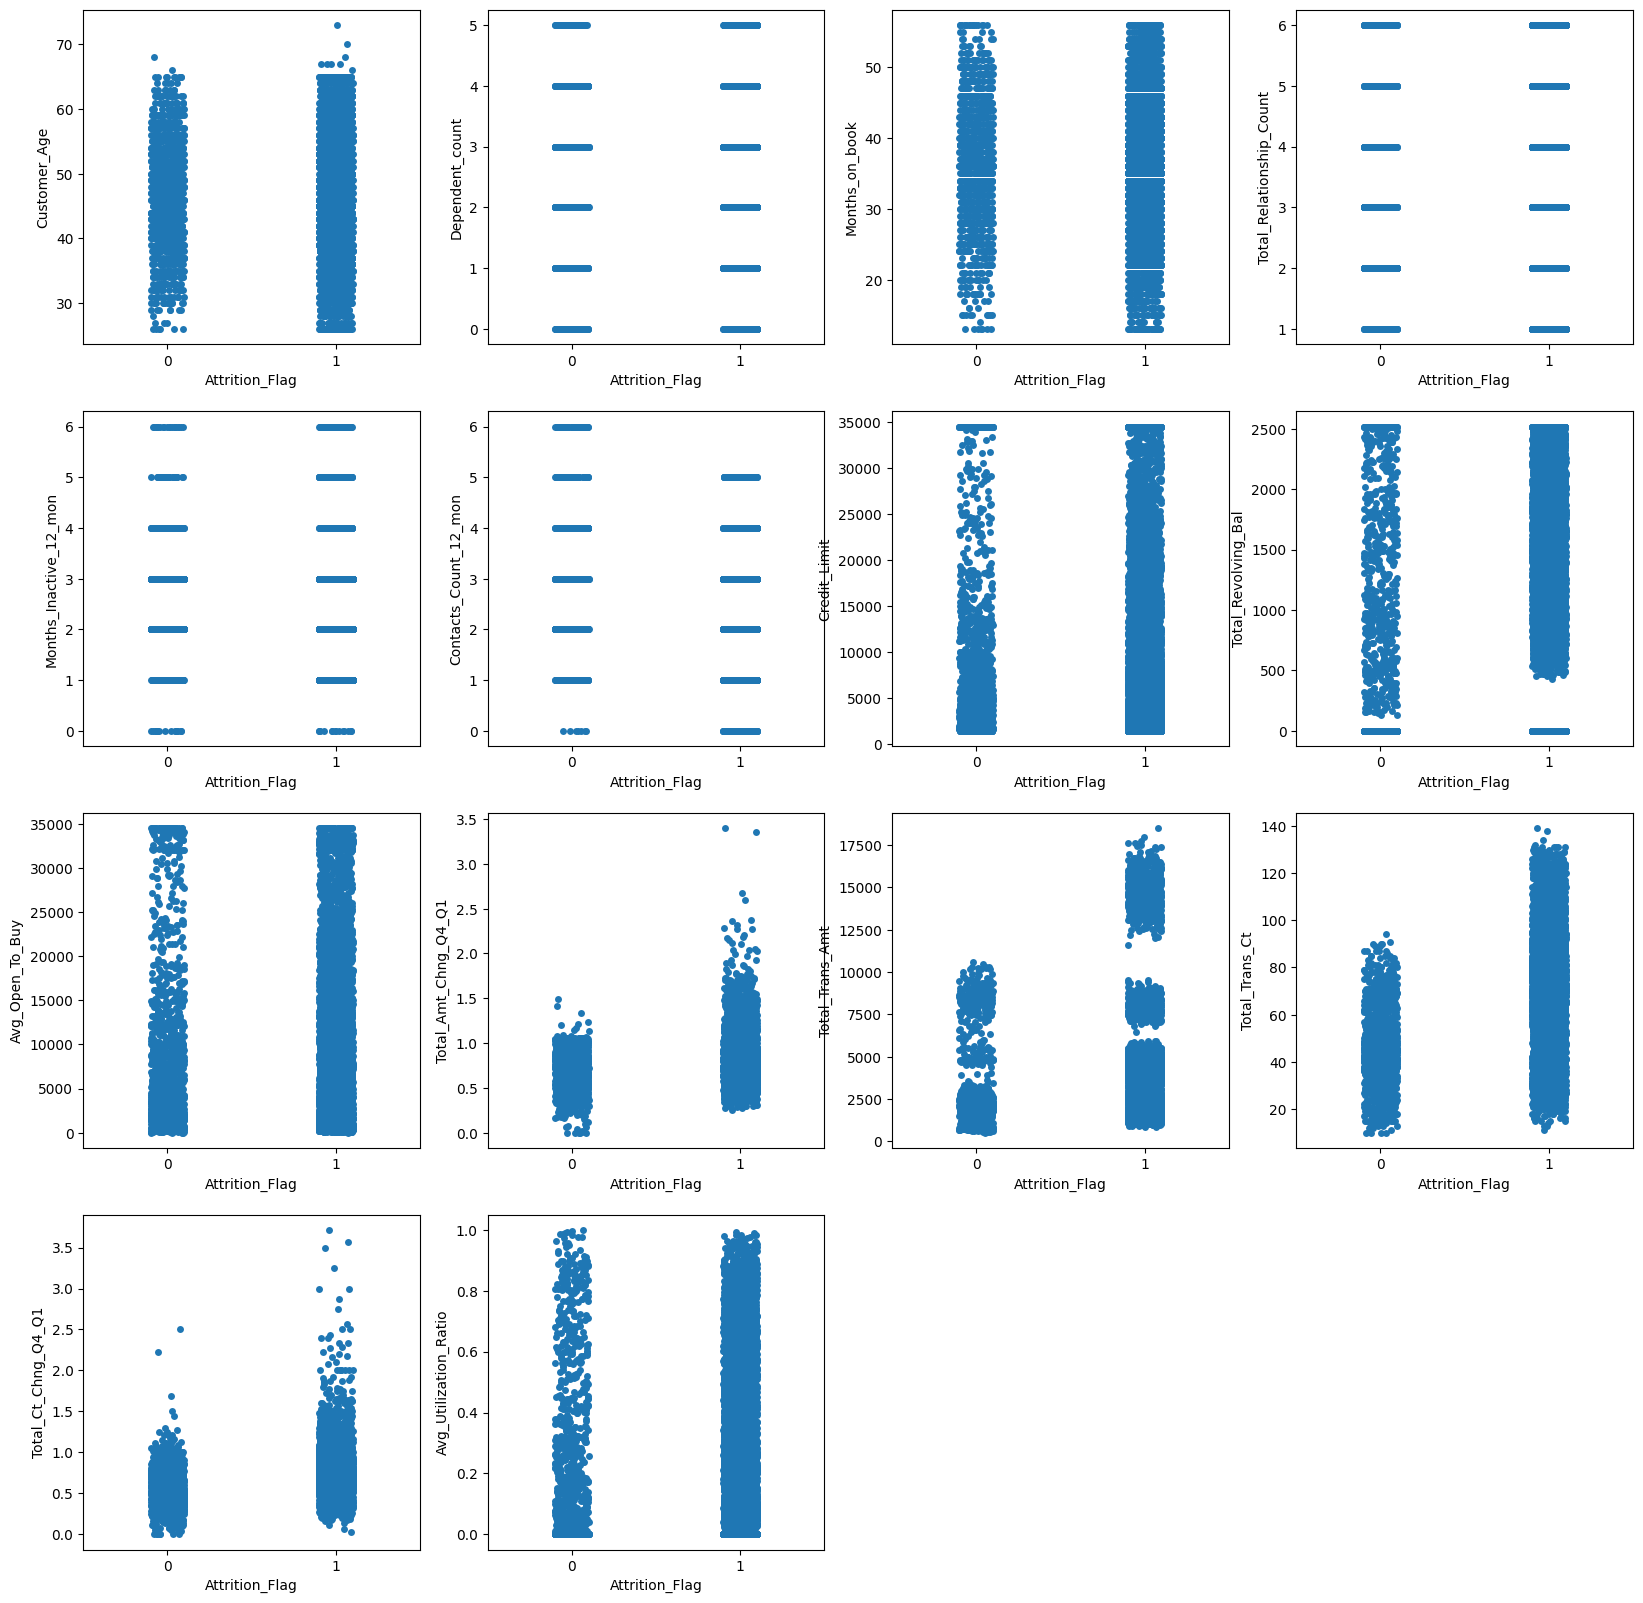

In [46]:
plt.figure(figsize=(20,20))
for idx, col in enumerate(dfNum.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(4,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df)

In [47]:
df = df.drop(df[df['Total_Ct_Chng_Q4_Q1'] >= 1.5].index & df[df['Attrition_Flag'] == 0].index)
df = df.drop(df[df['Total_Ct_Chng_Q4_Q1'] >= 2.5].index & df[df['Attrition_Flag'] == 1].index)
df = df.drop(df[df['Total_Amt_Chng_Q4_Q1'] >= 1.25].index & df[df['Attrition_Flag'] == 0].index)
df = df.drop(df[df['Total_Amt_Chng_Q4_Q1'] >= 2.5].index & df[df['Attrition_Flag'] == 1].index)

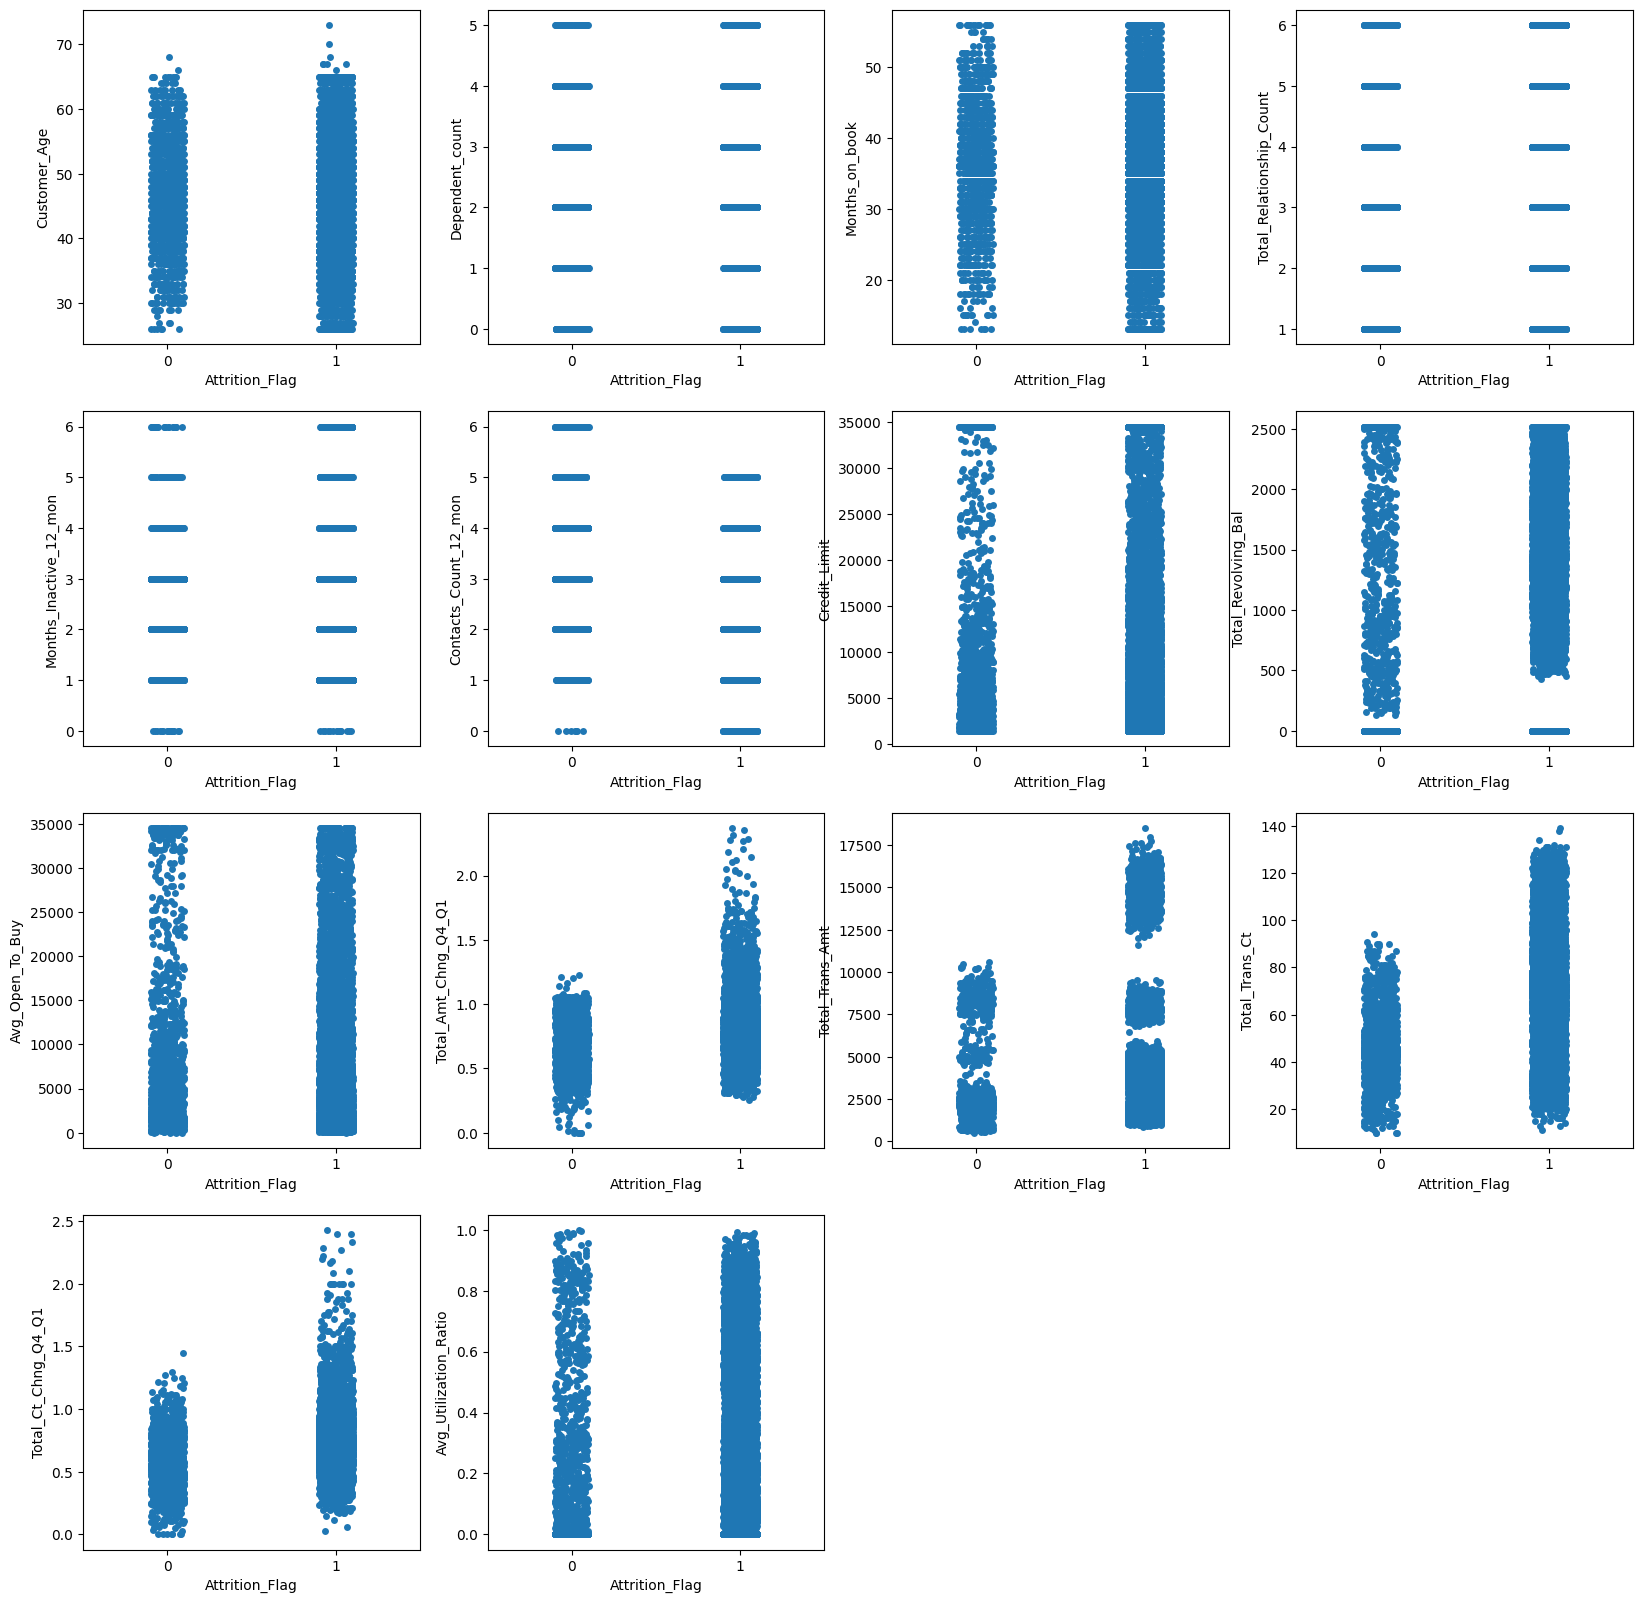

In [48]:
plt.figure(figsize=(20,20))
for idx, col in enumerate(dfNum.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(4,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df)

### **Encoding Method 1** : One-Hot Encoding
<hr>

#### **One-Hot Encoding**

In [49]:
df_ohe = df.copy()

In [50]:
x_ohe = df_ohe.drop(['Attrition_Flag'], axis = 1)
y_ohe = df_ohe['Attrition_Flag']
x_ohe = pd.get_dummies(x_ohe)
df_ohe = pd.concat([x_ohe, y_ohe], axis=1)

In [51]:
df_ohe

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
3                40                4              34   
5                44                2              36   
6                51                4              46   
7                32                0              27   
...             ...              ...             ...   
10122            50                2              40   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
3                             3                       4   
5                             3                       1   
6                             6                       1   
7                             2                       2   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
3                          1        3313.0                 2517   
5                          2        4010.0                 1247   
6                          3       34516.0                 2264   
7                          2       29081.0                 1396   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  \
0              11914.0                 1.335  ...   
3                796.0                 1.405  ...   
5               2763.0                 1.376  ...   
6              32252.0                 1.975  ...   
7              27685.0                 2.204  ...   
...                ...                   ...  ...   
10122           2152.0                 0.703  ...   
10123           2091.0                 0.804  ...   
10124           5409.0                 0.819  ...   
10125           5281.0                 0.535  ...   
10126           8427.0                 0.703  ...   

       Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
0                                0                            1   
3                                0                            0   
5                                1                            0   
6                                0                            0   
7                                0                            1   
...                            ...                          ...   
10122                            1                            0   
10123                            1                            0   
10124                            0                            0   
10125                            1                            0   
10126                            0                            0   

       Income_Category_$80K - $120K  Income_Category_Less than $40K  \
0                                 0                               0   
3                                 0                               1   
5                                 0                               0   
6                                 0                               0   
7                      

#### **Feature Scaling**

In [52]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

df_ohe_mm = df_ohe.copy()
df_ohe_ss = df_ohe.copy()
df_ohe_rs = df_ohe.copy()

dfNum = df_ohe.select_dtypes(include=['int64', 'float64'])

for idx in dfNum.columns:
    if idx not in ['Attrition_Flag']:
        df_ohe_mm[idx]=min_max_scaler.fit_transform(df_ohe[idx].values.reshape(-1,1))
        df_ohe_ss[idx]=standard_scaler.fit_transform(df_ohe[idx].values.reshape(-1,1))
        df_ohe_rs[idx]=robust_scaler.fit_transform(df_ohe[idx].values.reshape(-1,1))

Here we are using 3 types of scaler to check which one is better suited for this dataset.

#### **Feature Selection** (ANOVA + Min-Max Scaler)

In [53]:
x_ohe = df_ohe_mm.drop(['Attrition_Flag'], axis=1)
y_ohe = df_ohe_mm['Attrition_Flag']

anova = SelectKBest(f_classif, k=10)
df_ohe_mm = anova.fit(x_ohe, y_ohe)

col = anova.get_support(indices=True)
df_ohe_mm = x_ohe.iloc[:,col]

##### **Concatenate Data** (ANOVA + Min-Max Scaler)

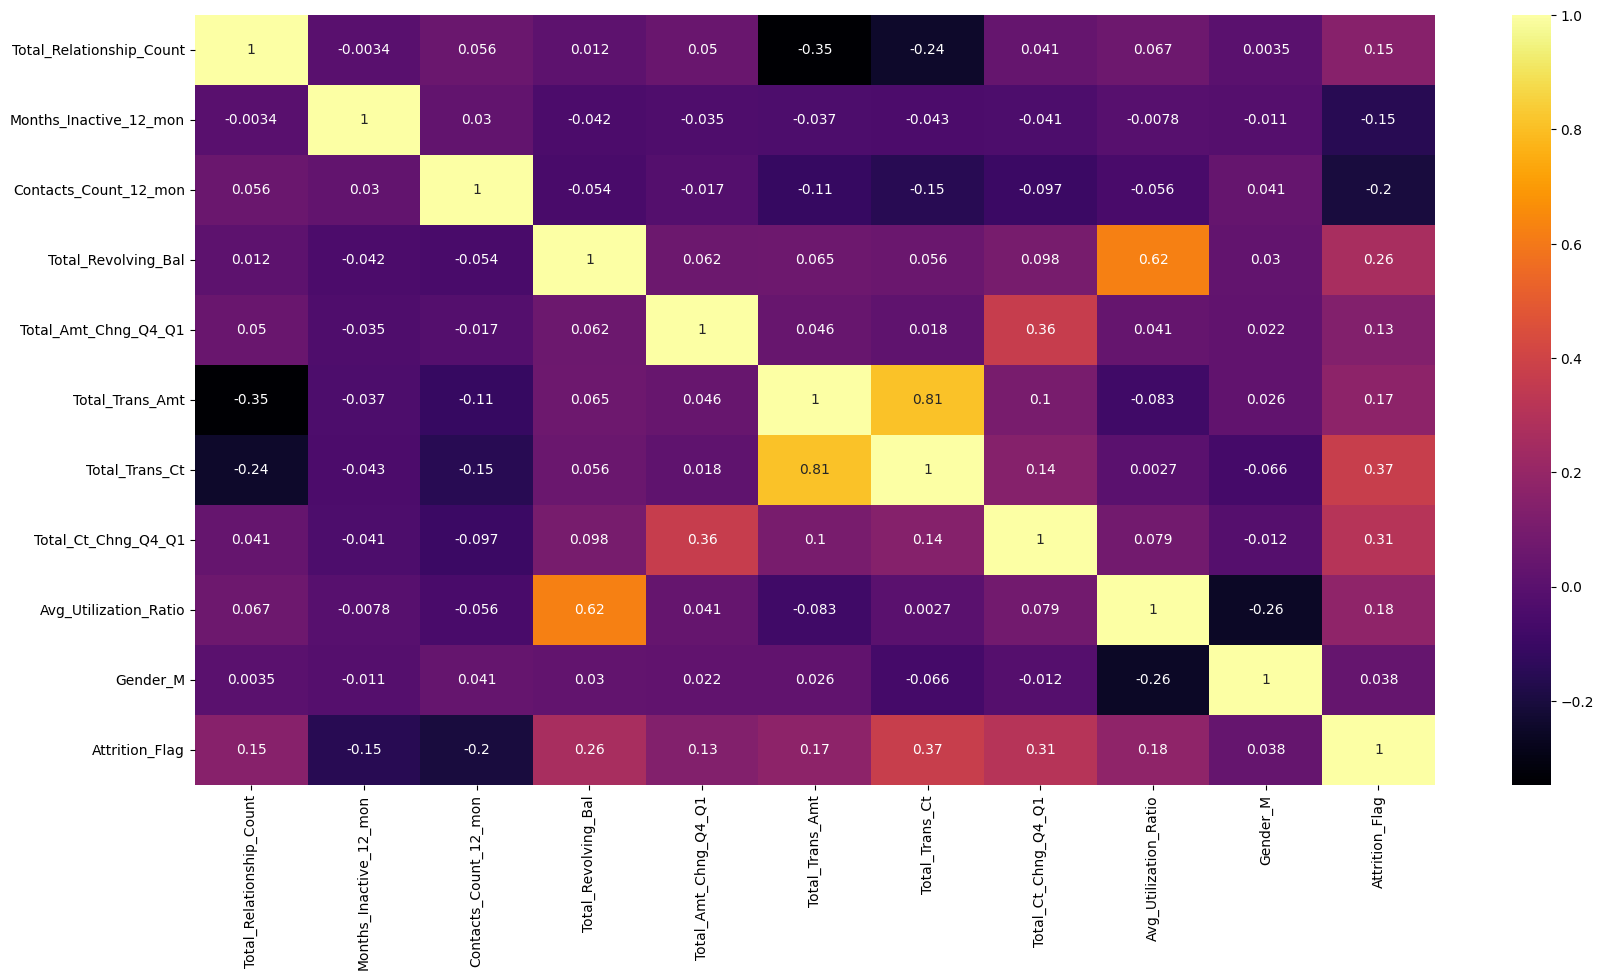

In [54]:
df_ohe_mm = pd.concat([df_ohe_mm, y_ohe], axis=1)
checkCorrFF(df_ohe_mm)

##### **Drop High Correlation Features**

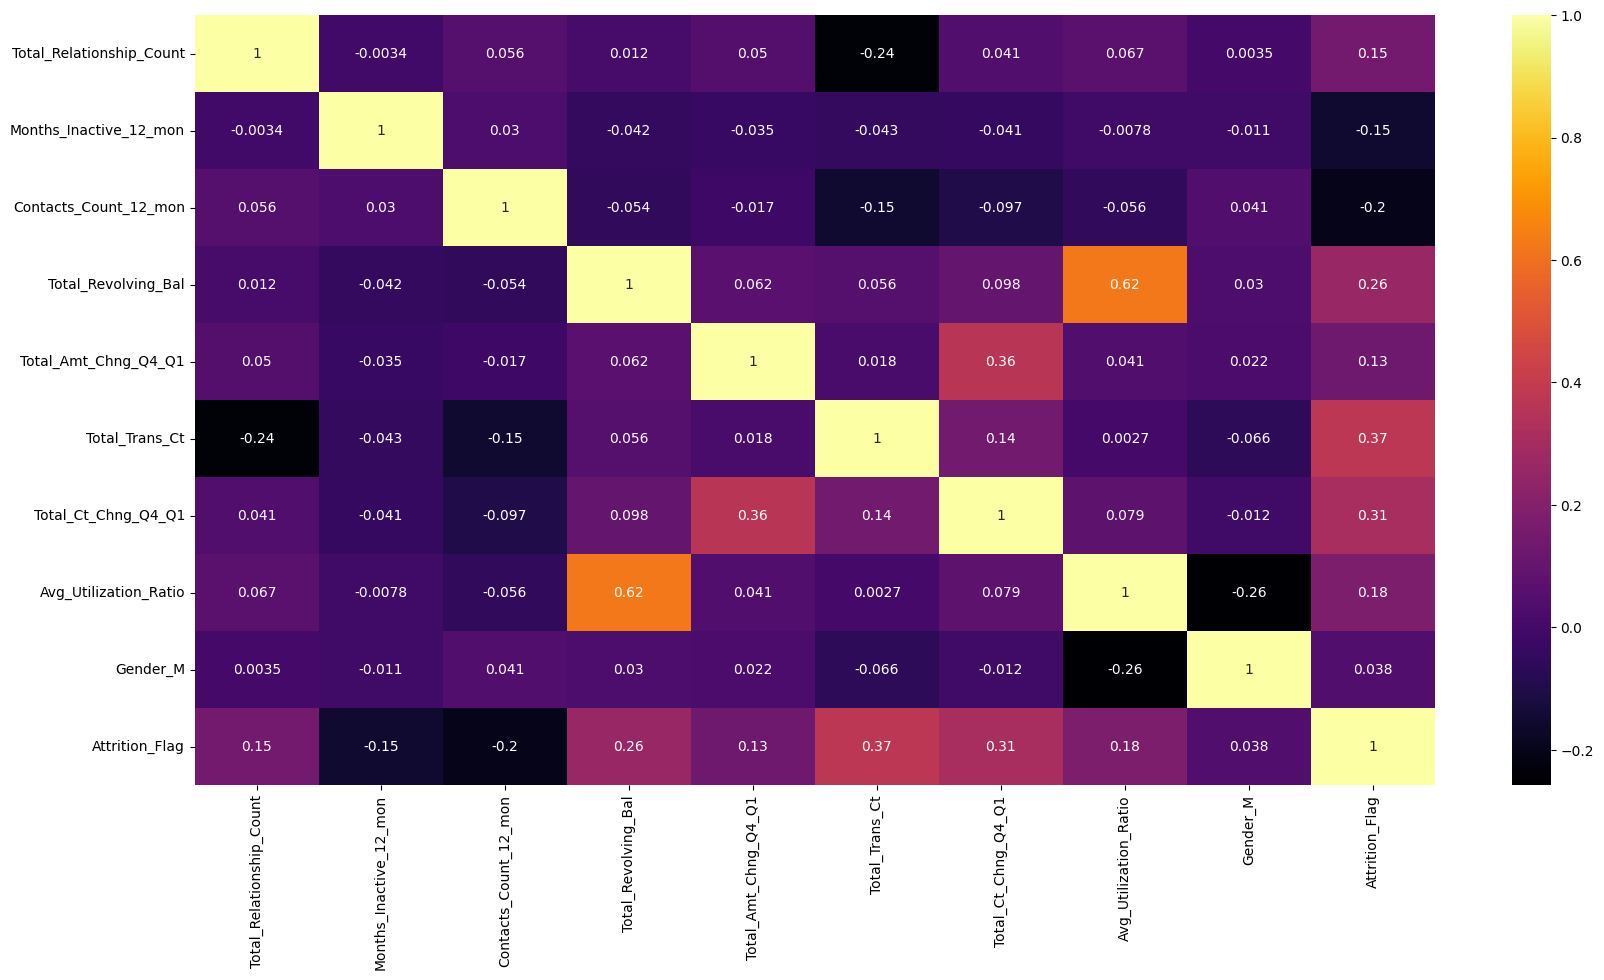

In [55]:
df_ohe_mm.drop(['Total_Trans_Amt'], axis=1, inplace=True)
checkCorrFF(df_ohe_mm)

#### **Feature Selection** (ANOVA + Standard Scaler)

In [56]:
x_ohe_ss = df_ohe_ss.drop(['Attrition_Flag'], axis=1)
y_ohe_ss = df_ohe_ss['Attrition_Flag']

anova = SelectKBest(f_classif, k=10)
df_ohe_ss = anova.fit(x_ohe_ss, y_ohe_ss)

col = anova.get_support(indices=True)
df_ohe_ss = x_ohe_ss.iloc[:,col]

##### **Concatenate Data** (ANOVA + Standard Scaler)

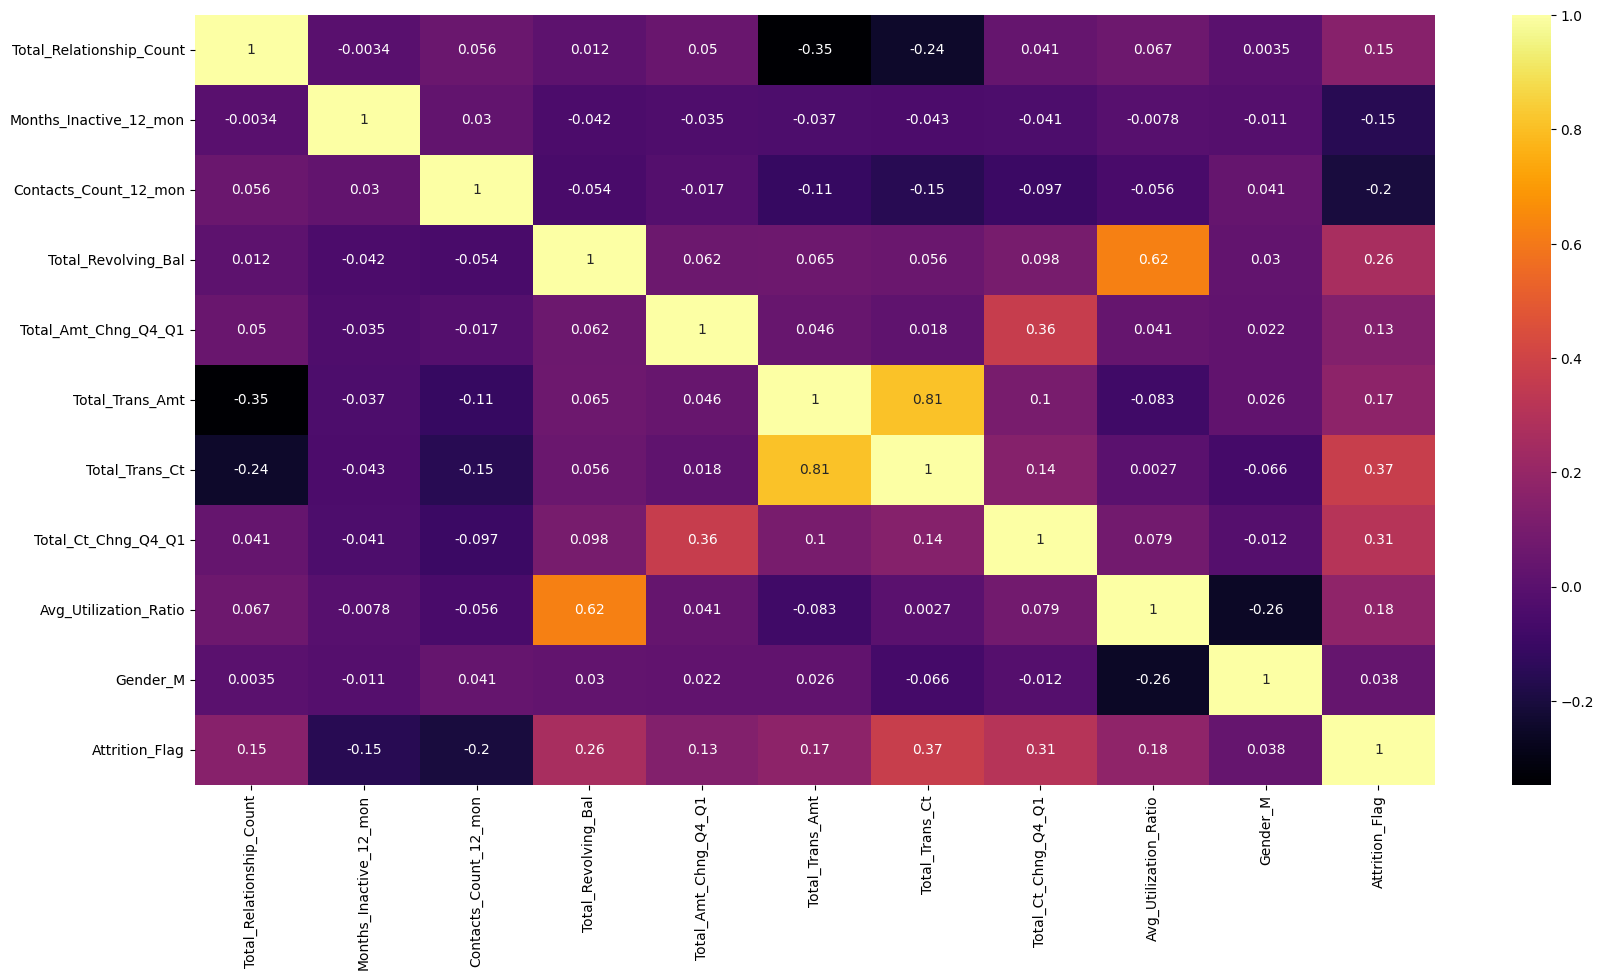

In [57]:
df_ohe_ss = pd.concat([df_ohe_ss, y_ohe_ss], axis=1)
checkCorrFF(df_ohe_ss)

##### **Drop High Correlation Features**

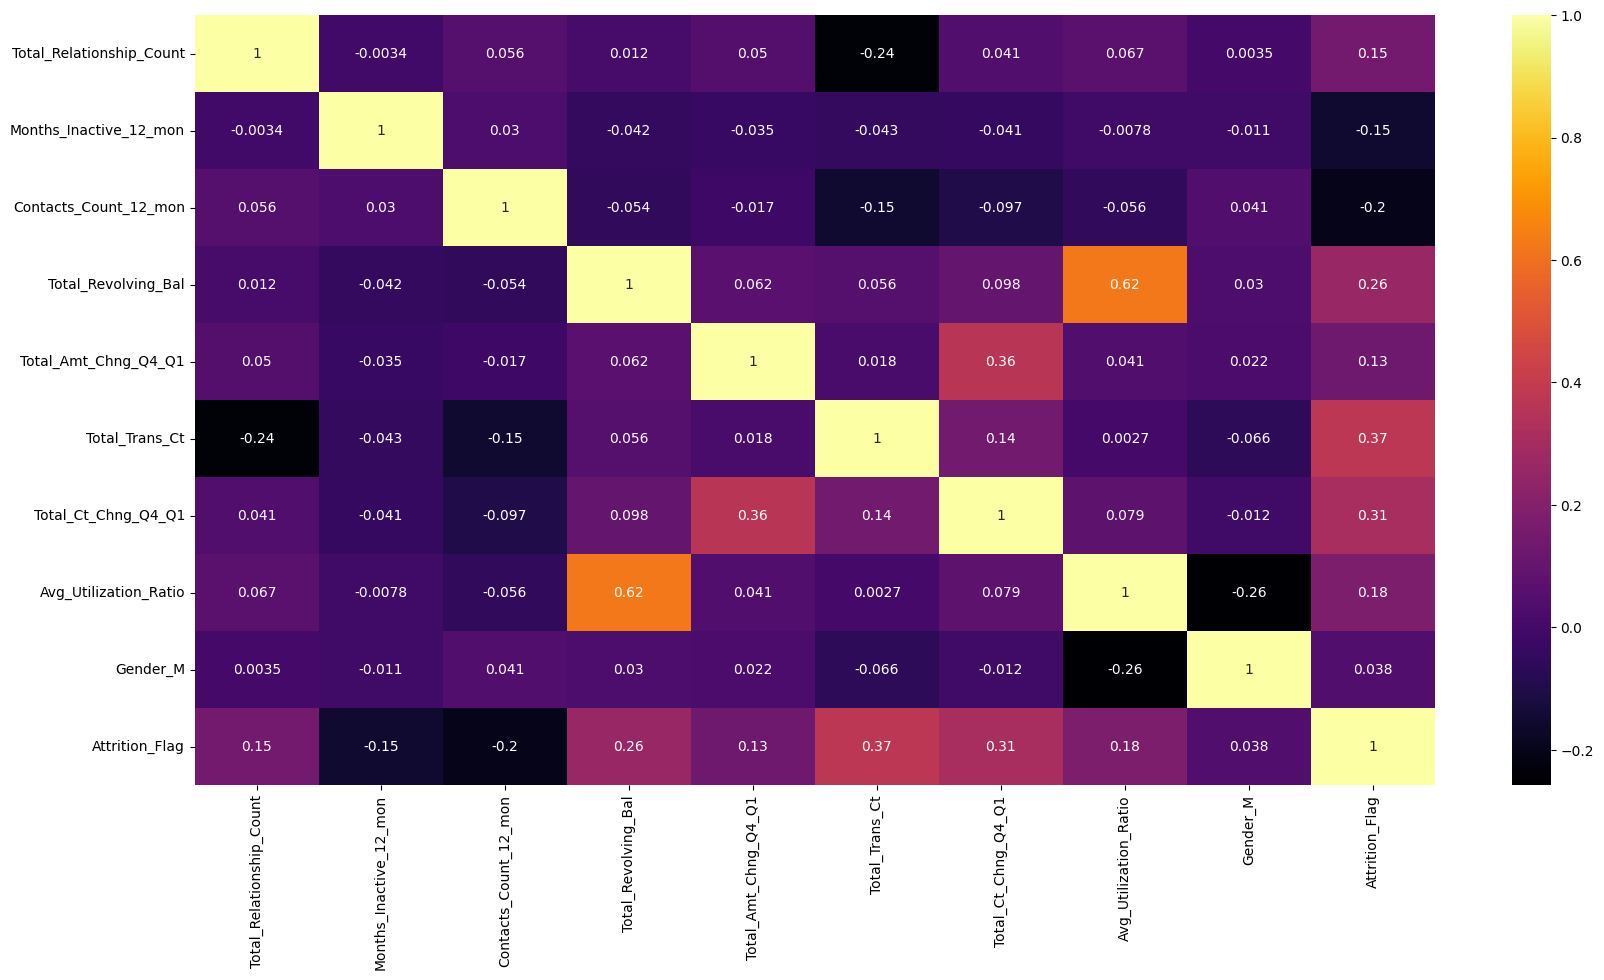

In [58]:
df_ohe_ss.drop(['Total_Trans_Amt'], axis=1, inplace=True)
checkCorrFF(df_ohe_ss)

#### **Feature Selection** (ANOVA + Robust Scaler)

In [59]:
x_ohe_rs = df_ohe_rs.drop(['Attrition_Flag'], axis=1)
y_ohe_rs = df_ohe_rs['Attrition_Flag']

anova = SelectKBest(f_classif, k=10)
df_ohe_rs = anova.fit(x_ohe_rs, y_ohe_rs)

col = anova.get_support(indices=True)
df_ohe_rs = x_ohe_rs.iloc[:,col]

##### **Concatenate Data** (ANOVA + Robust Scaler)

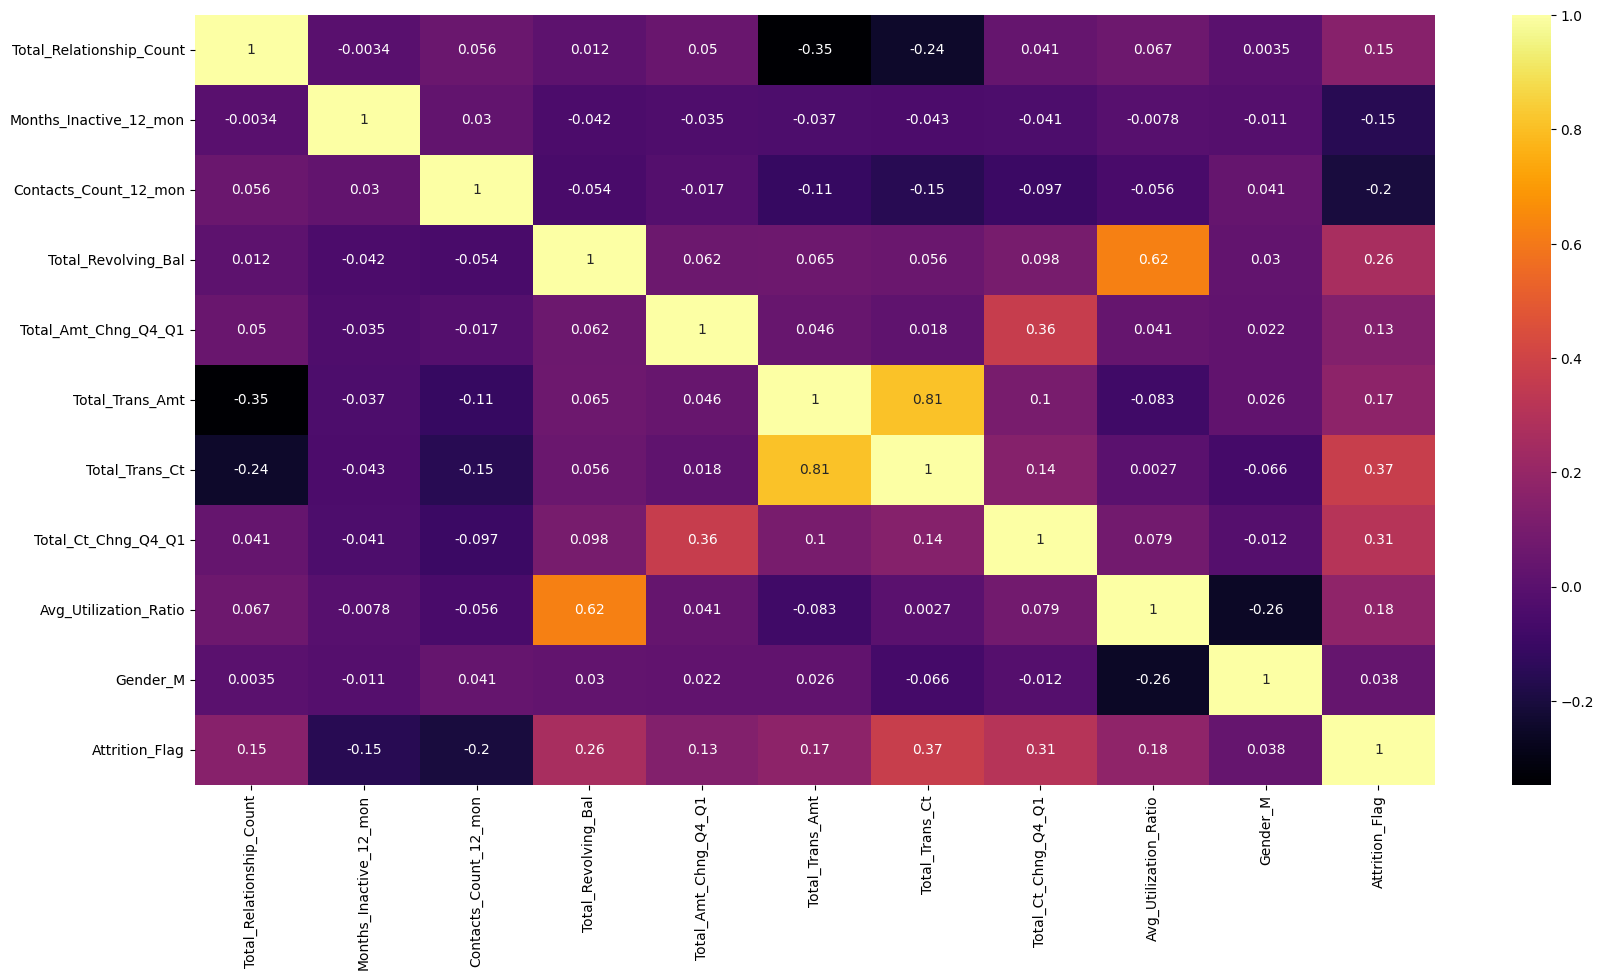

In [60]:
df_ohe_rs = pd.concat([df_ohe_rs, y_ohe_rs], axis=1)
checkCorrFF(df_ohe_rs)

##### **Drop High Correlation Features**

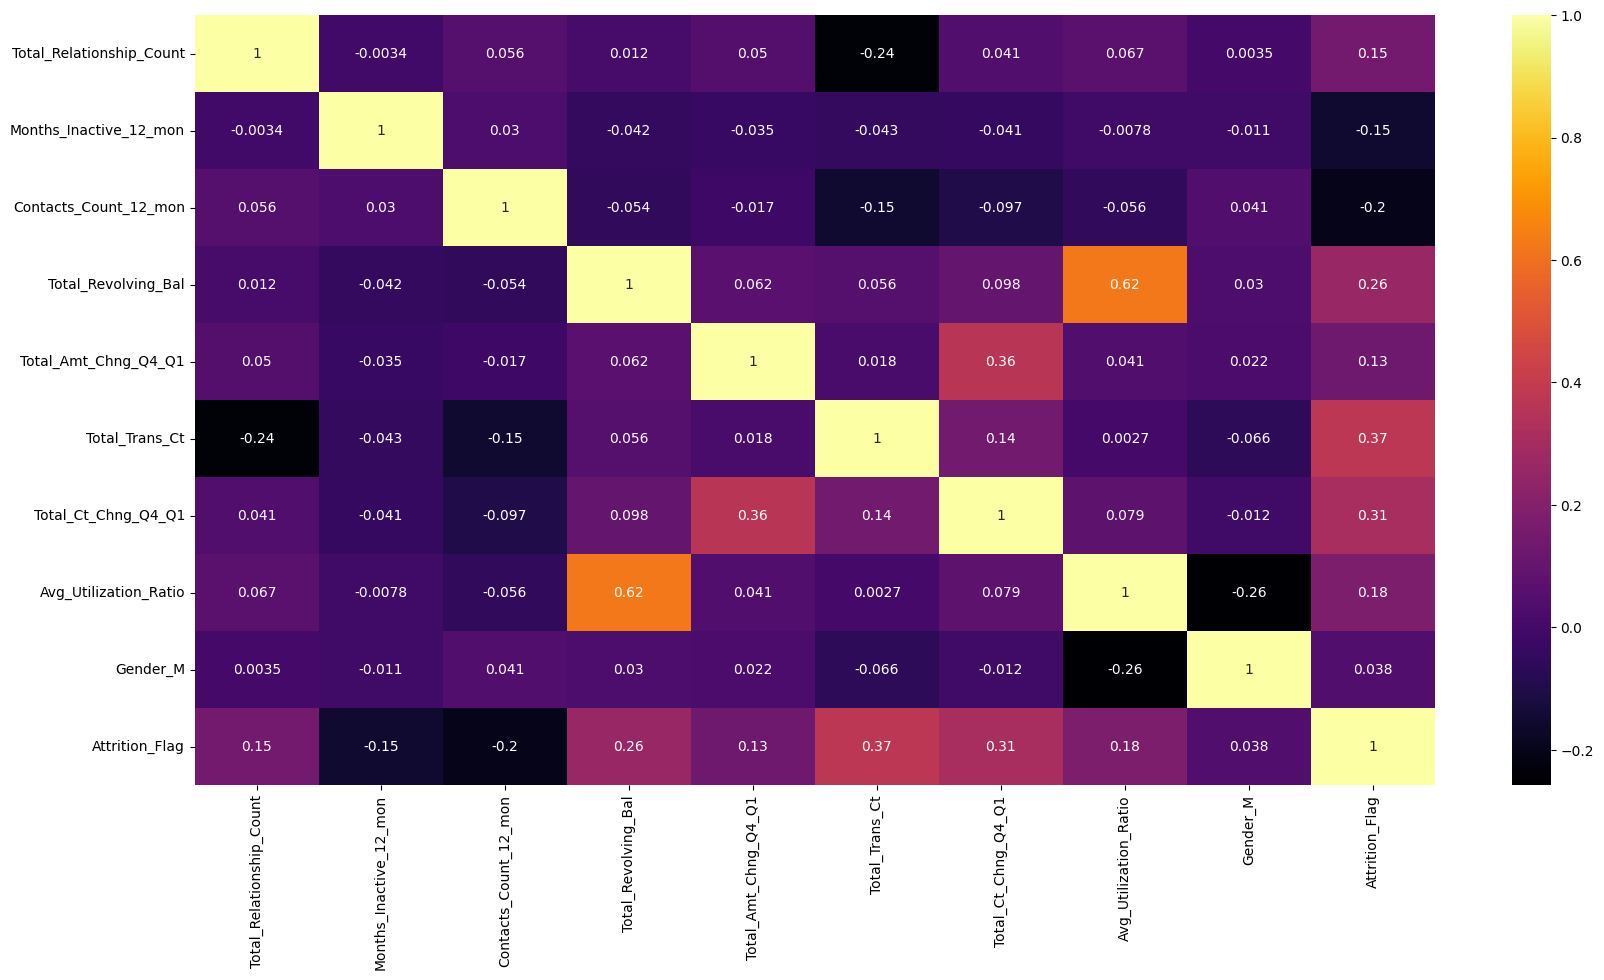

In [61]:
df_ohe_rs.drop(['Total_Trans_Amt'], axis=1, inplace=True)
checkCorrFF(df_ohe_rs)

#### **Model Training** (ANOVA + Min-Max Scaler)

In [62]:
#get the dummy variables for the categorical variables
x_mm = df_ohe_mm.drop(['Attrition_Flag'], axis = 1)
y_mm = df_ohe_mm['Attrition_Flag']

# Split the data into train and test
x_mm_train,x_mm_test,y_mm_train,y_mm_test = train_test_split(x_mm, y_mm, test_size = 0.2, random_state = 0)

# Hyperparameter tuning
grid = {"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}

clf_mm = LogisticRegression()
clf_cv_mm = GridSearchCV(clf_mm,
                         grid,
                         cv=10,
                         scoring='f1',
                         n_jobs=-1)
clf_cv_mm.fit(x_mm_train,y_mm_train)

print("tuned hpyerparameters :(best parameters) ",clf_cv_mm.best_params_)
print("score :",clf_cv_mm.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
score : 0.9416766368761618


In [63]:
clf_mm = LogisticRegression(C=clf_cv_mm.best_params_['C'], 
                            penalty=clf_cv_mm.best_params_['penalty'],
                            solver=clf_cv_mm.best_params_['solver'])
clf_mm.fit(x_mm_train,y_mm_train)
print("model score: %.8f" % clf_mm.score(x_mm_test, y_mm_test))

model score: 0.89614243


##### **Predict using Train Data**

In [64]:
# Classification report
y_mm_pred = clf_mm.predict(x_mm_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_mm_train, y_pred=y_mm_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_mm_train, y_pred=y_mm_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.81      0.46      0.59      1273
           1       0.91      0.98      0.94      6812

    accuracy                           0.90      8085
   macro avg       0.86      0.72      0.77      8085
weighted avg       0.89      0.90      0.89      8085

Confusion matrix 
[[ 591  682]
 [ 142 6670]]


##### **Predict using Test Data**

In [65]:
# Classification report
y_mm_pred = clf_mm.predict(x_mm_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_mm_test, y_pred=y_mm_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_mm_test, y_pred=y_mm_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.85      0.48      0.61       347
           1       0.90      0.98      0.94      1675

    accuracy                           0.90      2022
   macro avg       0.88      0.73      0.78      2022
weighted avg       0.89      0.90      0.88      2022

Confusion matrix 
[[ 166  181]
 [  29 1646]]


#### **Model Training** (ANOVA + Standard Scaler)

In [66]:
#get the dummy variables for the categorical variables
x_ss = df_ohe_ss.drop(['Attrition_Flag'], axis = 1)
y_ss = df_ohe_ss['Attrition_Flag']

# Split the data into training and testing sets
x_ss_train,x_ss_test,y_ss_train,y_ss_test = train_test_split(x_ss, y_ss, test_size = 0.2, random_state = 0)

# Hyperparameter tuning
grid = {"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}

clf_ss = LogisticRegression()
clf_cv_ss = GridSearchCV(clf_ss,
                         grid,
                         cv=10,
                         scoring='f1',
                         n_jobs=-1)
clf_cv_ss.fit(x_ss_train,y_ss_train)

print("tuned hpyerparameters :(best parameters) ",clf_cv_ss.best_params_)
print("score :",clf_cv_ss.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
score : 0.9421331222843659


In [67]:
clf_ss = LogisticRegression(C=clf_cv_ss.best_params_['C'], 
                            penalty=clf_cv_ss.best_params_['penalty'],
                            solver=clf_cv_ss.best_params_['solver'])
clf_ss.fit(x_ss_train,y_ss_train)
print("model score: %.8f" % clf_ss.score(x_ss_test, y_ss_test))

model score: 0.89366963


##### **Predict using Train Data**

In [68]:
# Classification report
y_ss_pred = clf_ss.predict(x_ss_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_ss_train, y_pred=y_ss_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_ss_train, y_pred=y_ss_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.78      0.50      0.61      1273
           1       0.91      0.97      0.94      6812

    accuracy                           0.90      8085
   macro avg       0.85      0.74      0.78      8085
weighted avg       0.89      0.90      0.89      8085

Confusion matrix 
[[ 634  639]
 [ 178 6634]]


##### **Predict using Test Data**

In [69]:
# Classification report
y_ss_pred = clf_ss.predict(x_ss_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_ss_test, y_pred=y_ss_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_ss_test, y_pred=y_ss_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.80      0.50      0.62       347
           1       0.90      0.97      0.94      1675

    accuracy                           0.89      2022
   macro avg       0.85      0.74      0.78      2022
weighted avg       0.89      0.89      0.88      2022

Confusion matrix 
[[ 175  172]
 [  43 1632]]


#### **Model Training** (ANOVA + Robust Scaler)

In [70]:
#get the dummy variables for the categorical variables
x_rs = df_ohe_rs.drop(['Attrition_Flag'], axis = 1)
y_rs = df_ohe_rs['Attrition_Flag']

# Split the data into training and test sets
x_rs_train,x_rs_test,y_rs_train,y_rs_test = train_test_split(x_rs, y_rs, test_size = 0.2, random_state = 0)

# Hyperparameter tuning
grid = {"C":np.logspace(-6,6,13),
        # "class_weight":[None,"balanced"],
        "penalty":['none', 'elasticnet', 'l1', 'l2'],
        "solver":['newton-cg','lbfgs','liblinear','sag','saga']}

clf_rs = LogisticRegression()
clf_cv_rs = GridSearchCV(clf_rs,
                         grid,
                         cv=10,
                         scoring='f1',
                         n_jobs=-1)
clf_cv_rs.fit(x_rs_train,y_rs_train)

print("tuned hpyerparameters :(best parameters) ",clf_cv_rs.best_params_)
print("score :",clf_cv_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
score : 0.9417136853188977


In [71]:
clf_rs = LogisticRegression(C=clf_cv_rs.best_params_['C'],
                            penalty=clf_cv_rs.best_params_['penalty'],
                            solver=clf_cv_rs.best_params_['solver'])
clf_rs.fit(x_rs_train,y_rs_train)

print("model score: %.8f" % clf_rs.score(x_rs_test, y_rs_test))

model score: 0.89564787


##### **Predict using Train Data**

In [72]:
# Classification report
y_rs_pred = clf_rs.predict(x_rs_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_rs_train, y_pred=y_rs_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_rs_train, y_pred=y_rs_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.77      0.51      0.62      1273
           1       0.91      0.97      0.94      6812

    accuracy                           0.90      8085
   macro avg       0.84      0.74      0.78      8085
weighted avg       0.89      0.90      0.89      8085

Confusion matrix 
[[ 653  620]
 [ 195 6617]]


##### **Predict using Test Data**

In [73]:
# Classification report
y_rs_pred = clf_rs.predict(x_rs_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_rs_test, y_pred=y_rs_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_rs_test, y_pred=y_rs_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       347
           1       0.91      0.97      0.94      1675

    accuracy                           0.90      2022
   macro avg       0.85      0.75      0.79      2022
weighted avg       0.89      0.90      0.89      2022

Confusion matrix 
[[ 181  166]
 [  45 1630]]


## **Encoding Method 2** : Label Encoding
<hr>

#### **Label Encoding**

In [74]:
df_LE = df.copy()

df_LE['Gender'] = df_LE['Gender'].apply(lambda x: ['M', 'F'].index(x))
df_LE['Education_Level'] = df_LE['Education_Level'].apply(lambda x: ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'].index(x))
df_LE['Income_Category'] = df_LE['Income_Category'].apply(lambda x: ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'].index(x))
df_LE['Card_Category'] = df_LE['Card_Category'].apply(lambda x: ['Blue', 'Silver', 'Gold', 'Platinum'].index(x))

x_LE = df_LE.drop(['Attrition_Flag'], axis = 1)
y_LE = df_LE['Attrition_Flag']
x_LE = pd.get_dummies(x_LE)
df_LE = pd.concat([x_LE, y_LE], axis = 1)

#### **Feature Scaling**

In [75]:
robust_scaler = RobustScaler()
min_max_scaler = MinMaxScaler()

df_LE_rs = df_LE.copy()
df_LE_mm = df_LE.copy()

dfNum = df_LE.select_dtypes(include=['int64', 'float64'])

for idx in df_LE.columns:
    if idx not in ['Attrition_Flag']:
        df_LE_rs[idx] = robust_scaler.fit_transform(df_LE[idx].values.reshape(-1,1))
        df_LE_mm[idx] = min_max_scaler.fit_transform(df_LE[idx].values.reshape(-1,1))

Here we are using 2 types of scaler to check which one is better suited with label encoder for this dataset.

In [76]:
df_LE_rs

Customer_Age  Dependent_count  Months_on_book  \
0         -0.090909              0.5        0.333333   
3         -0.545455              1.0       -0.222222   
5         -0.181818              0.0        0.000000   
6          0.454545              1.0        1.111111   
7         -1.272727             -1.0       -1.000000   
...             ...              ...             ...   
10122      0.363636              0.0        0.444444   
10123     -0.454545              0.0       -1.222222   
10124     -0.181818             -0.5        0.000000   
10125     -1.454545              0.0        0.000000   
10126     -0.272727              0.0       -1.222222   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                           0.5                    -1.0   
3                          -0.5                     2.0   
5                          -0.5                    -1.0   
6                           1.0                    -1.0   
7                          -1.0                     0.0   
...                         ...                     ...   
10122                      -0.5                     0.0   
10123                       0.0                     0.0   
10124                       0.5                     1.0   
10125                       0.0                     1.0   
10126                       1.0                     0.0   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                        1.0      0.958390            -0.357782   
3                       -1.0     -0.145489             0.887299   
5                        0.0     -0.063445            -0.021467   
6                        1.0      3.527397             0.706261   
7                        0.0      2.887646             0.085152   
...                      ...           ...                  ...   
10122                    1.0     -0.064269             0.410733   
10123                    1.0     -0.032017             0.650447   
10124                    2.0      0.101230            -0.913775   
10125                    1.0      0.086163            -0.913775   
10126                    2.0      0.687305             0.489445   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  Avg_Utilization_Ratio  \
0             0.991777              2.638767  ...              -0.239583   
3            -0.314225              2.947137  ...               1.216667   
5            -0.083167              2.819383  ...               0.281250   
6             3.380829              5.458150  ...              -0.229167   
7             2.844356              6.466960  ...              -0.266667   
...                ...                   ...  ...                    ...   
10122        -0.154940             -0.145374  ...               0.595833   
10123        -0.162105              0.299559  ...               0.697917   
10124         0.227652              0.365639  ...              -0.366667   
10125         0.212616             -0.885463  ...              -0.366667   
10126         0.582168             -0.145374  ...               0.027083   

       Gender  Education_Level  Income_Category  Card_Category  \
0        -1.0        -0.333333              0.5            0.0   
3         0.0        -0.333333             -0.5            0.0   
5        -1.0         0.333333              0.0            0.0   
6        -1.0        -1.000000              1.5            2.0   
7        -1.0        -0.333333              0.5            1.0   
...       ...              ...              ...            ...   
10122    -1.0         0.333333              0.0            0.0   
10123    -1.0        -1.000000              0.0            0.0   
10124     0.0        -0.333333             -0.5            0.0   
10125    -1.0         0.333333              0.0            0.0   
10126     0.0         0.333333             -0.5            1.0   

       Marital_Status_Divorced  Marital_Status_Married  Marital_Status_Single  \
0                          0.0   

In [77]:
df_LE_mm

Customer_Age  Dependent_count  Months_on_book  \
0          0.404255              0.6        0.604651   
3          0.297872              0.8        0.488372   
5          0.382979              0.4        0.534884   
6          0.531915              0.8        0.767442   
7          0.127660              0.0        0.325581   
...             ...              ...             ...   
10122      0.510638              0.4        0.627907   
10123      0.319149              0.4        0.279070   
10124      0.382979              0.2        0.534884   
10125      0.085106              0.4        0.534884   
10126      0.361702              0.4        0.279070   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                           0.8                0.166667   
3                           0.4                0.666667   
5                           0.4                0.166667   
6                           1.0                0.166667   
7                           0.2                0.333333   
...                         ...                     ...   
10122                       0.4                0.333333   
10123                       0.6                0.333333   
10124                       0.8                0.500000   
10125                       0.6                0.500000   
10126                       1.0                0.333333   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                   0.500000      0.340190             0.308701   
3                   0.166667      0.056676             1.000000   
5                   0.333333      0.077747             0.495431   
6                   0.500000      1.000000             0.899484   
7                   0.333333      0.835690             0.554629   
...                      ...           ...                  ...   
10122               0.500000      0.077536             0.735399   
10123               0.500000      0.085819             0.868494   
10124               0.666667      0.120042             0.000000   
10125               0.500000      0.116172             0.000000   
10126               0.666667      0.270566             0.779102   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  Avg_Utilization_Ratio  \
0             0.345116              0.563767  ...               0.061061   
3             0.022977              0.593328  ...               0.760761   
5             0.079970              0.581081  ...               0.311311   
6             0.934402              0.834037  ...               0.066066   
7             0.802075              0.930743  ...               0.048048   
...                ...                   ...  ...                    ...   
10122         0.062266              0.296875  ...               0.462462   
10123         0.060499              0.339527  ...               0.511512   
10124         0.156637              0.345861  ...               0.000000   
10125         0.152928              0.225929  ...               0.000000   
10126         0.244082              0.296875  ...               0.189189   

       Gender  Education_Level  Income_Category  Card_Category  \
0         0.0         0.333333              0.6       0.000000   
3         1.0         0.333333              0.2       0.000000   
5         0.0         0.666667              0.4       0.000000   
6         0.0         0.000000              1.0       0.666667   
7         0.0         0.333333              0.6       0.333333   
...       ...              ...              ...            ...   
10122     0.0         0.666667              0.4       0.000000   
10123     0.0         0.000000              0.4       0.000000   
10124     1.0         0.333333              0.2       0.000000   
10125     0.0         0.666667              0.4       0.000000   
10126     1.0         0.666667              0.2       0.333333   

       Marital_Status_Divorced  Marital_Status_Married  Marital_Status_Single  \
0                          0.0   

#### **Feature Selection** (Robust Scaler)

In [78]:
selector = SelectKBest(f_classif, k=10)
x_LE_rs = df_LE_rs.drop(['Attrition_Flag'], axis = 1)
y_LE_rs = df_LE_rs['Attrition_Flag']
df_LE_rs = selector.fit(x_LE_rs, y_LE_rs)

col = selector.get_support(indices=True)
df_LE_rs = x_LE_rs.iloc[:,col]

##### **Concatenate Data** (Robust Scaler)

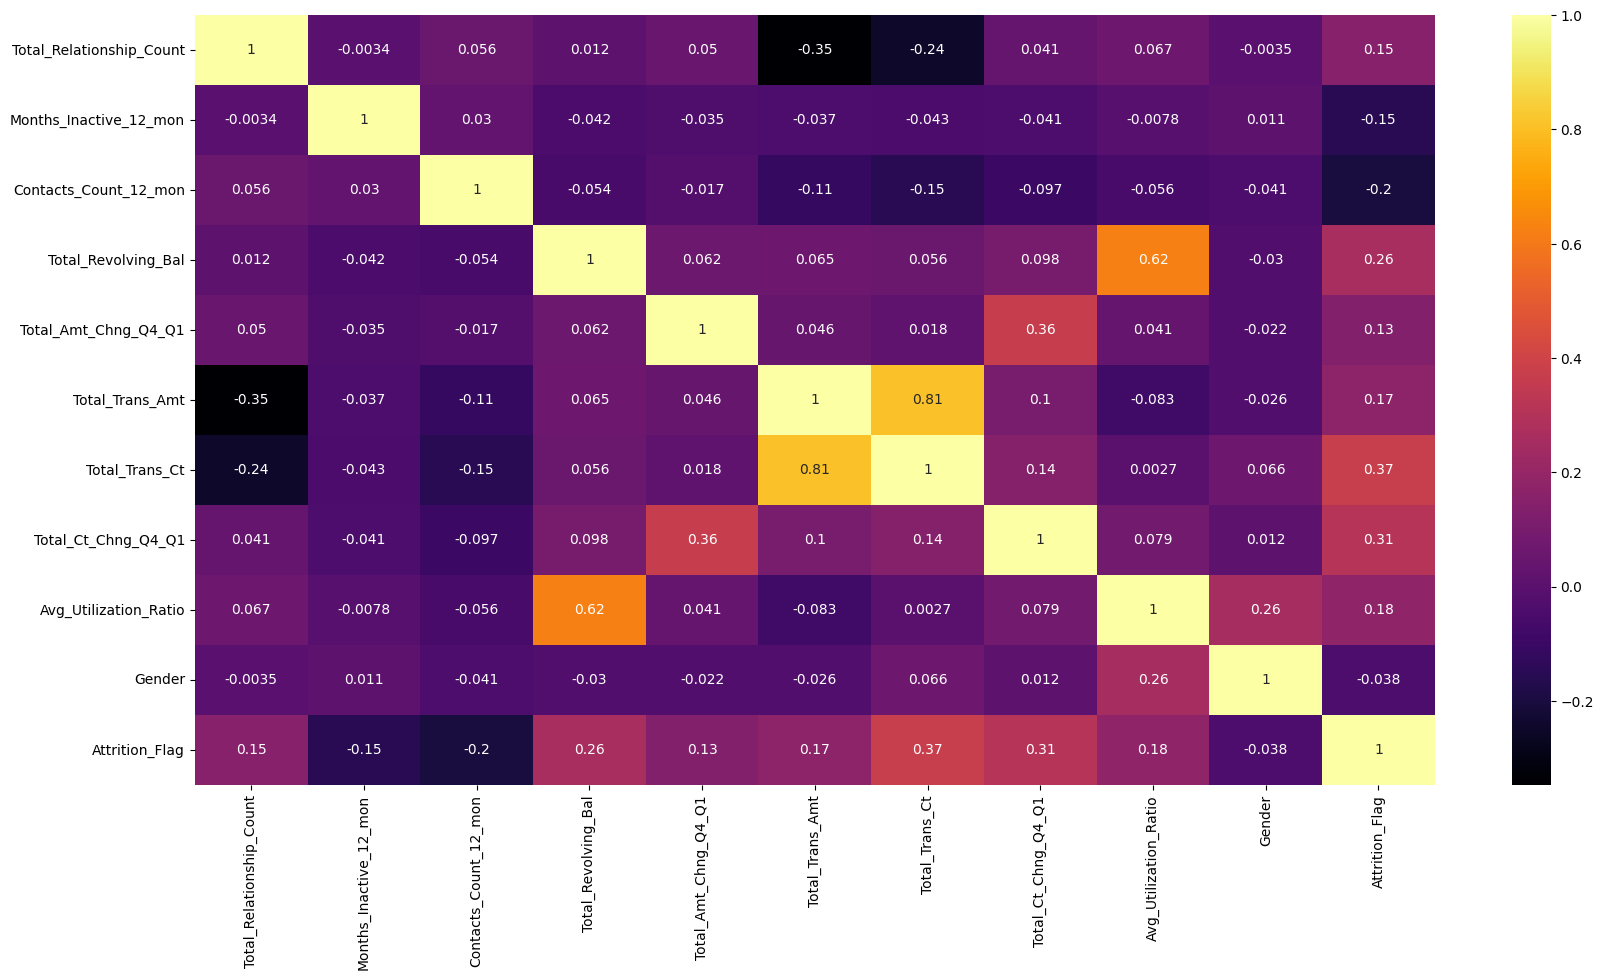

In [79]:
df_LE_rs = pd.concat([df_LE_rs, y_LE_rs], axis=1)
checkCorrFF(df_LE_rs)

##### **Drop High Correlation Features**

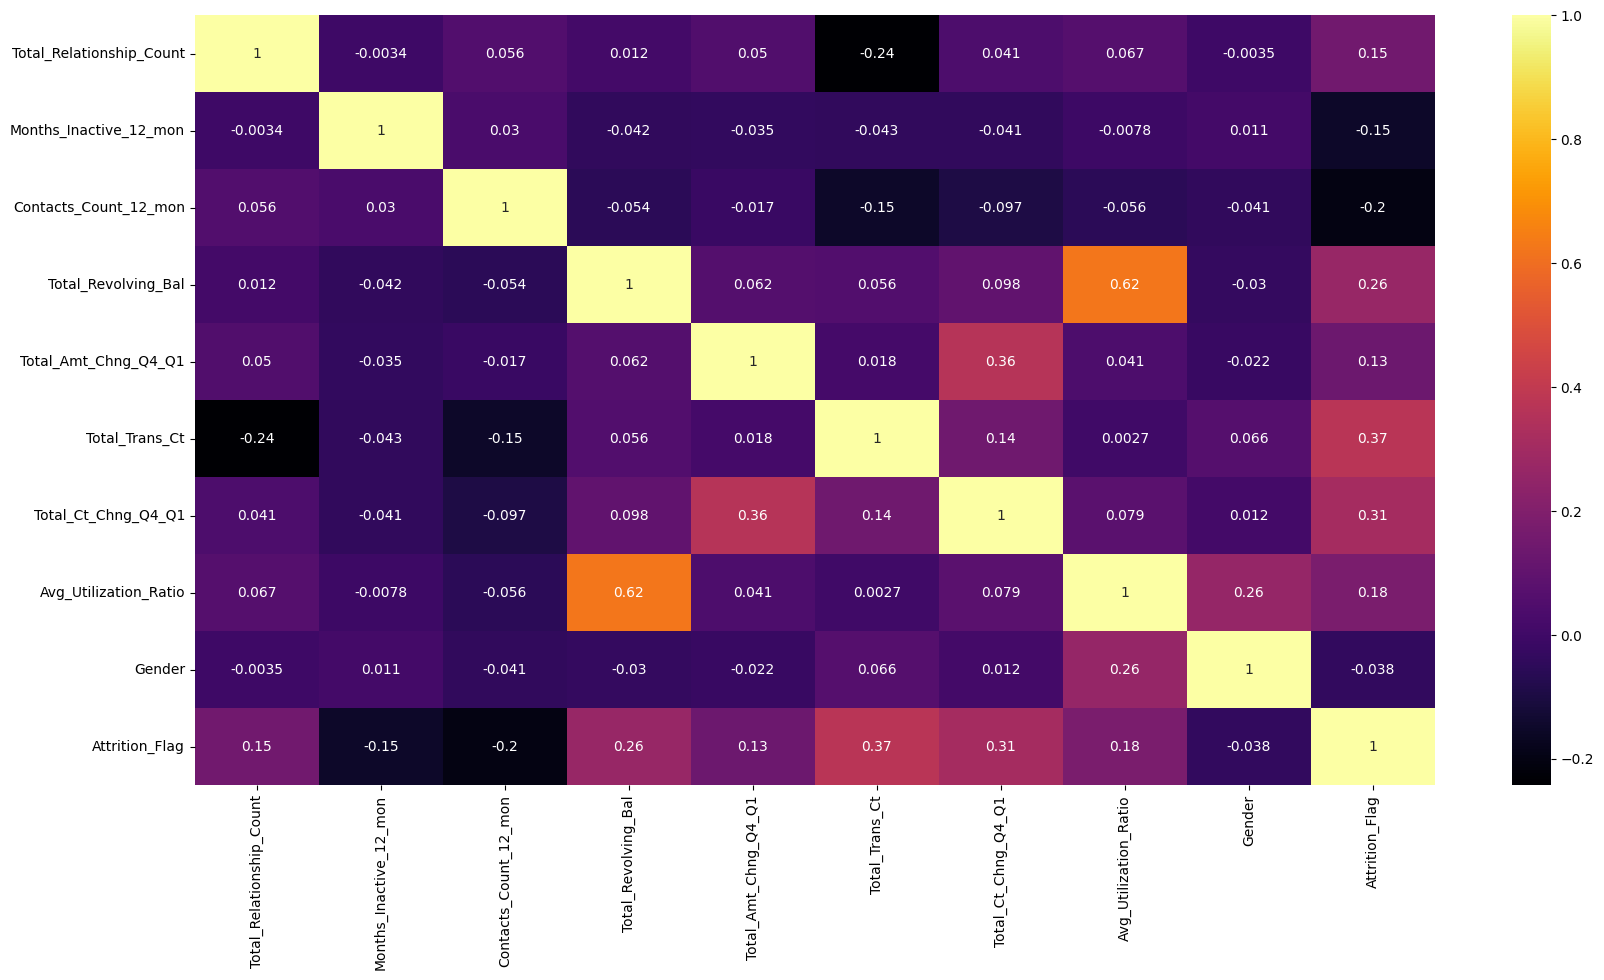

In [80]:
df_LE_rs.drop(['Total_Trans_Amt'], axis=1, inplace=True)
checkCorrFF(df_LE_rs)

#### **Feature Selection** (Min-Max Scaler)

In [81]:
selector = SelectKBest(f_classif, k=10)
x_LE_mm = df_LE_mm.drop(['Attrition_Flag'], axis = 1)
y_LE_mm = df_LE_mm['Attrition_Flag']
df_LE_mm = selector.fit(x_LE_mm, y_LE_mm)

col = selector.get_support(indices=True)
df_LE_mm = x_LE_mm.iloc[:,col]

##### **Concatenate Data** (Min-Max Scaler)

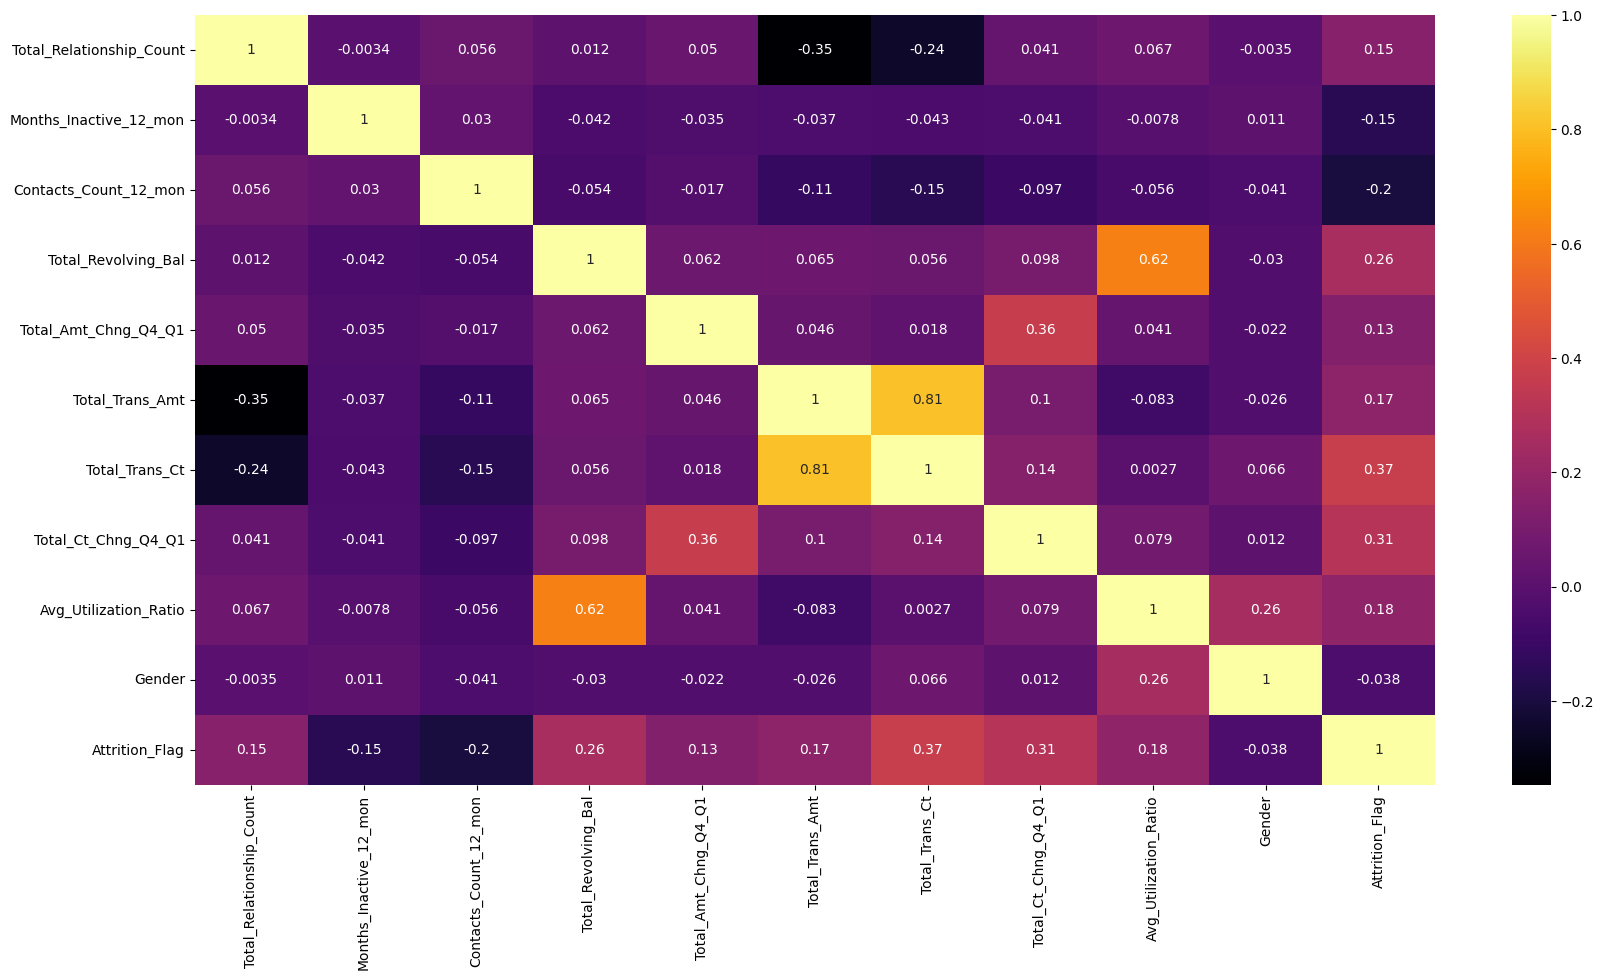

In [82]:
df_LE_mm = pd.concat([df_LE_mm, y_LE_mm], axis=1)
checkCorrFF(df_LE_mm)

##### **Drop High Correlation Features**

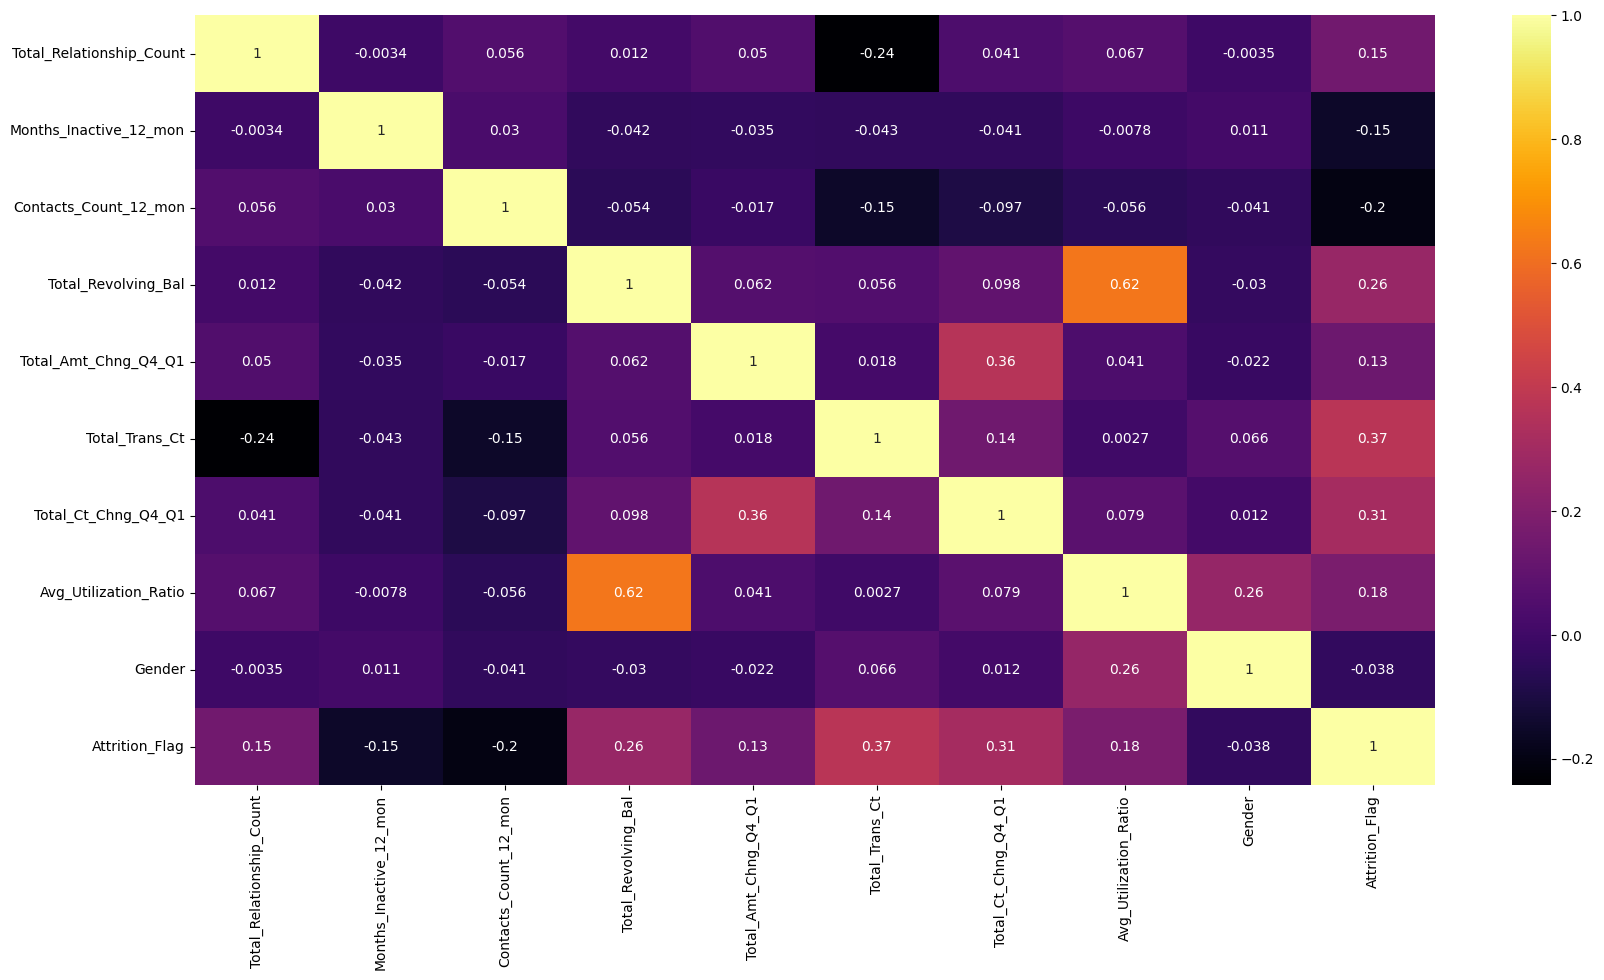

In [83]:
df_LE_mm.drop(['Total_Trans_Amt'], axis=1, inplace=True)
checkCorrFF(df_LE_mm)

#### **Model Training** (Robust Scaler)

In [84]:
#get the dummy variables for the categorical variables
x_LE_rs = df_LE_rs.drop(['Attrition_Flag'], axis = 1)
y_LE_rs = df_LE_rs['Attrition_Flag']

# Split the data into training and testing sets
x_LE_rs_train,x_LE_rs_test,y_LE_rs_train,y_LE_rs_test = train_test_split(x_LE_rs, y_LE_rs, test_size = 0.2, random_state = 0)

# Hyperparameter tuning
grid = {"C":np.logspace(-6,6,13),
        # "class_weight":[None,"balanced"],
        "penalty":['none', 'elasticnet', 'l1', 'l2'],
        "solver":['newton-cg','lbfgs','liblinear','sag','saga']}

clf_LE_rs = LogisticRegression()
clf_cv_LE_rs = GridSearchCV(clf_LE_rs,
                       grid,
                       cv=10,
                       scoring='f1',
                       n_jobs=-1)
clf_cv_LE_rs.fit(x_LE_rs_train,y_LE_rs_train)

print("tuned hpyerparameters :(best parameters) ",clf_cv_LE_rs.best_params_)
print("score :",clf_cv_LE_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
score : 0.9417136853188977


In [85]:
clf_LE_rs = LogisticRegression(C=clf_cv_LE_rs.best_params_['C'],
                            penalty=clf_cv_LE_rs.best_params_['penalty'],
                            solver=clf_cv_LE_rs.best_params_['solver'])
clf_LE_rs.fit(x_LE_rs_train,y_LE_rs_train)
print("model score: %.8f" % clf_LE_rs.score(x_LE_rs_test, y_LE_rs_test))

model score: 0.89564787


##### **Predict using Train Data**

In [86]:
# Classification report
y_LE_pred = clf_LE_rs.predict(x_LE_rs_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_LE_rs_train, y_pred=y_LE_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_LE_rs_train, y_pred=y_LE_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.77      0.51      0.62      1273
           1       0.91      0.97      0.94      6812

    accuracy                           0.90      8085
   macro avg       0.84      0.74      0.78      8085
weighted avg       0.89      0.90      0.89      8085

Confusion matrix 
[[ 653  620]
 [ 195 6617]]


##### **Predict using Test Data**

In [87]:
# Classification report
y_LE_pred = clf_LE_rs.predict(x_LE_rs_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_LE_rs_test, y_pred=y_LE_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_LE_rs_test, y_pred=y_LE_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       347
           1       0.91      0.97      0.94      1675

    accuracy                           0.90      2022
   macro avg       0.85      0.75      0.79      2022
weighted avg       0.89      0.90      0.89      2022

Confusion matrix 
[[ 181  166]
 [  45 1630]]


#### **Model Training** (Min-Max Scaler)

In [88]:
#get the dummy variables for the categorical variables
x_LE_mm = df_LE_mm.drop(['Attrition_Flag'], axis = 1)
y_LE_mm = df_LE_mm['Attrition_Flag']

# Split the data into training and testing sets
x_LE_mm_train,x_LE_mm_test,y_LE_mm_train,y_LE_mm_test = train_test_split(x_LE_mm, y_LE_mm, test_size = 0.2, random_state = 0)

# Hyperparameter tuning
grid = {"C":np.logspace(-6,6,13),
        # "class_weight":[None,"balanced"],
        "penalty":['none', 'elasticnet', 'l1', 'l2'],
        "solver":['newton-cg','lbfgs','liblinear','sag','saga']}

clf_LE_mm = LogisticRegression()
clf_cv_LE_mm = GridSearchCV(clf_LE_mm,
                       grid,
                       cv=10,
                       scoring='f1',
                       n_jobs=-1)
clf_cv_LE_mm.fit(x_LE_mm_train,y_LE_mm_train)

print("tuned hpyerparameters :(best parameters) ",clf_cv_LE_mm.best_params_)
print("score :",clf_cv_LE_mm.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
score : 0.942004424206379


In [89]:
clf_LE_mm = LogisticRegression(C=clf_cv_LE_mm.best_params_['C'],
                            penalty=clf_cv_LE_mm.best_params_['penalty'],
                            solver=clf_cv_LE_mm.best_params_['solver'])
clf_LE_mm.fit(x_LE_mm_train,y_LE_mm_train)
print("model score: %.8f" % clf_LE_mm.score(x_LE_mm_test, y_LE_mm_test))

model score: 0.89564787


##### **Predict using Train Data**

In [90]:
# Classification report
y_LE_pred = clf_LE_mm.predict(x_LE_mm_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_LE_mm_train, y_pred=y_LE_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_LE_mm_train, y_pred=y_LE_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.81      0.46      0.59      1273
           1       0.91      0.98      0.94      6812

    accuracy                           0.90      8085
   macro avg       0.86      0.72      0.77      8085
weighted avg       0.89      0.90      0.89      8085

Confusion matrix 
[[ 591  682]
 [ 140 6672]]


##### **Predict using Test Data**

In [91]:
# Classification report
y_LE_pred = clf_LE_mm.predict(x_LE_mm_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_LE_mm_test, y_pred=y_LE_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_LE_mm_test, y_pred=y_LE_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.85      0.48      0.61       347
           1       0.90      0.98      0.94      1675

    accuracy                           0.90      2022
   macro avg       0.87      0.73      0.78      2022
weighted avg       0.89      0.90      0.88      2022

Confusion matrix 
[[ 166  181]
 [  30 1645]]


# **Data Preprocessing 2**
### **Label and One hot Encoding**

In [92]:
df_LE = df2.copy()

df_LE['Gender'] = df_LE['Gender'].apply(lambda x: ['M', 'F'].index(x))
df_LE['Education_Level'] = df_LE['Education_Level'].apply(lambda x: ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'].index(x))
df_LE['Income_Category'] = df_LE['Income_Category'].apply(lambda x: ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'].index(x))

df_LE['Card_Category'] = df_LE['Card_Category'].map({'Silver' : 'NotBlue','Gold': 'NotBlue','Platinum': 'NotBlue'})

x_LE = df_LE.drop(['Attrition_Flag'], axis = 1)
y_LE = df_LE['Attrition_Flag']
x_LE = pd.get_dummies(x_LE)

df_LE = pd.concat([x_LE, y_LE], axis=1)

df_LE

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
1                49                5              44   
2                51                3              36   
3                40                4              34   
4                40                3              21   
...             ...              ...             ...   
10122            50                2              40   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  Avg_Utilization_Ratio  \
0              11914.0                 1.335  ...                  0.061   
1               7392.0                 1.541  ...                  0.105   
2               3418.0                 2.594  ...                  0.000   
3                796.0                 1.405  ...                  0.760   
4               4716.0                 2.175  ...                  0.000   
...                ...                   ...  ...                    ...   
10122           2152.0                 0.703  ...                  0.462   
10123           2091.0                 0.804  ...                  0.511   
10124           5409.0                 0.819  ...                  0.000   
10125           5281.0                 0.535  ...                  0.000   
10126           8427.0                 0.703  ...                  0.189   

       Gender  Education_Level  Income_Category  Marital_Status_Divorced  \
0           0                2                3                        0   
1           1                4                1                        0   
2           0                4                4                        0   
3           1                2                1                        0   
4           0                1                3                        0   
...       ...              ...              ...                      ...   
10122       0                4                2                        0   
10123       0                0                2                        1   
10124       1                2                1                        0   
10125       0                4                2                        0   
10126       1                4                1                        

### **Drop data for Final Test**

<AxesSubplot: ylabel='Type'>

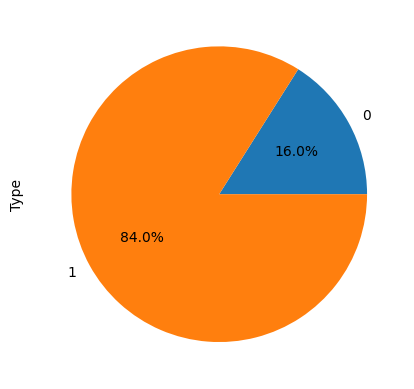

In [93]:
# sns.set_style("darkgrid")
# sns.set_context("poster")
# plt.rcParams["figure.figsize"] = [8,6]

df.groupby('Attrition_Flag').size().plot(kind='pie',
                                                y = "Attrition_Flag",
                                                label = "Type",
                                                autopct='%1.1f%%')

In [94]:
X = df_LE.drop(['Attrition_Flag'], axis=1)
y = df_LE['Attrition_Flag']
df_LE['Attrition_Flag'].value_counts()

1    8500
0    1627
Name: Attrition_Flag, dtype: int64

In [95]:
df_LE_x,df_LE_check_x,df_LE_y,df_LE_check_y = train_test_split(X, y, test_size = 0.05, random_state = 0)

df_LE = pd.concat([df_LE_x, df_LE_y], axis=1)
df_LE_check = pd.concat([df_LE_check_x, df_LE_check_y], axis=1)
df_LE_check.describe()

Customer_Age  Dependent_count  Months_on_book  \
count    507.000000       507.000000      507.000000   
mean      46.289941         2.282051       36.031558   
std        8.031605         1.319260        7.934452   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       32.000000   
50%       47.000000         2.000000       36.000000   
75%       52.000000         3.000000       41.000000   
max       66.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count                507.000000              507.000000   
mean                   3.903353                2.396450   
std                    1.506419                1.016964   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count             507.000000    507.000000            507.00000   
mean                2.546351   8656.890138           1150.81854   
std                 1.110194   9399.394366            802.50074   
min                 0.000000   1438.300000              0.00000   
25%                 2.000000   2489.000000            503.50000   
50%                 3.000000   4188.000000           1276.00000   
75%                 3.000000  10812.000000           1743.50000   
max                 6.000000  34516.000000           2517.00000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  Avg_Utilization_Ratio  \
count       507.000000            507.000000  ...             507.000000   
mean       7506.071598              0.765444  ...               0.286055   
std        9427.895168              0.218763  ...               0.279280   
min           3.000000              0.120000  ...               0.000000   
25%        1159.500000              0.639500  ...               0.019500   
50%        3241.000000              0.736000  ...               0.188000   
75%        9738.000000              0.866000  ...               0.528000   
max       34516.000000              2.121000  ...               0.999000   

           Gender  Education_Level  Income_Category  Marital_Status_Divorced  \
count  507.000000       507.000000       507.000000               507.000000   
mean     0.532544         2.639053         2.096647                 0.059172   
std      0.499433         1.654403         1.486610                 0.236179   
min      0.000000         0.000000         0.000000                 0.000000   
25%      0.000000         1.000000         1.000000                 0.000000   
50%      1.000000         3.000000         2.000000                 0.000000   
75%      1.000000         4.000000         3.000000                 0.000000   
max      1.000000         6.000000         5.000000                 1.000000   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Unknown  \
count              507.000000             507.000000              507.000000   
mean                 0.459566               0.410256                0.071006   
std                  0.498855               0.492366                0.257088   
min                  0.000000               0.000000                0.000000   
25%                  0.000000               0.000000                0.000000   
50%                  0.000000               0.000000                0.000000   
75%                  1.000000               1.000000                0.000000   
max                  1.000000               1.000000                1.000000   

       Card_Category_NotBlue  Attrition_Flag  
count             507.000000      507.000000  
mean                0.080868        0.848126  
std                 0.272901        0.359253  
min                 0.000000        0.000000  
25% 

<AxesSubplot: ylabel='Type'>

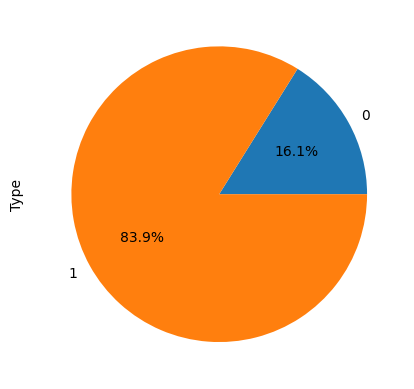

In [96]:
df_LE.groupby('Attrition_Flag').size().plot(kind='pie',
                                                y = "Attrition_Flag",
                                                label = "Type",
                                                autopct='%1.1f%%')

<AxesSubplot: ylabel='Type'>

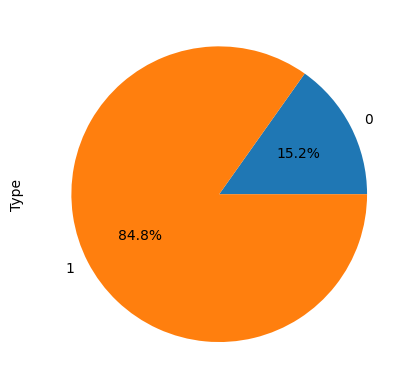

In [97]:
df_LE_check.groupby('Attrition_Flag').size().plot(kind='pie',
                                                y = "Attrition_Flag",
                                                label = "Type",
                                                autopct='%1.1f%%')

### **Data Transformation**

In [98]:
df_sample = df_LE.copy()

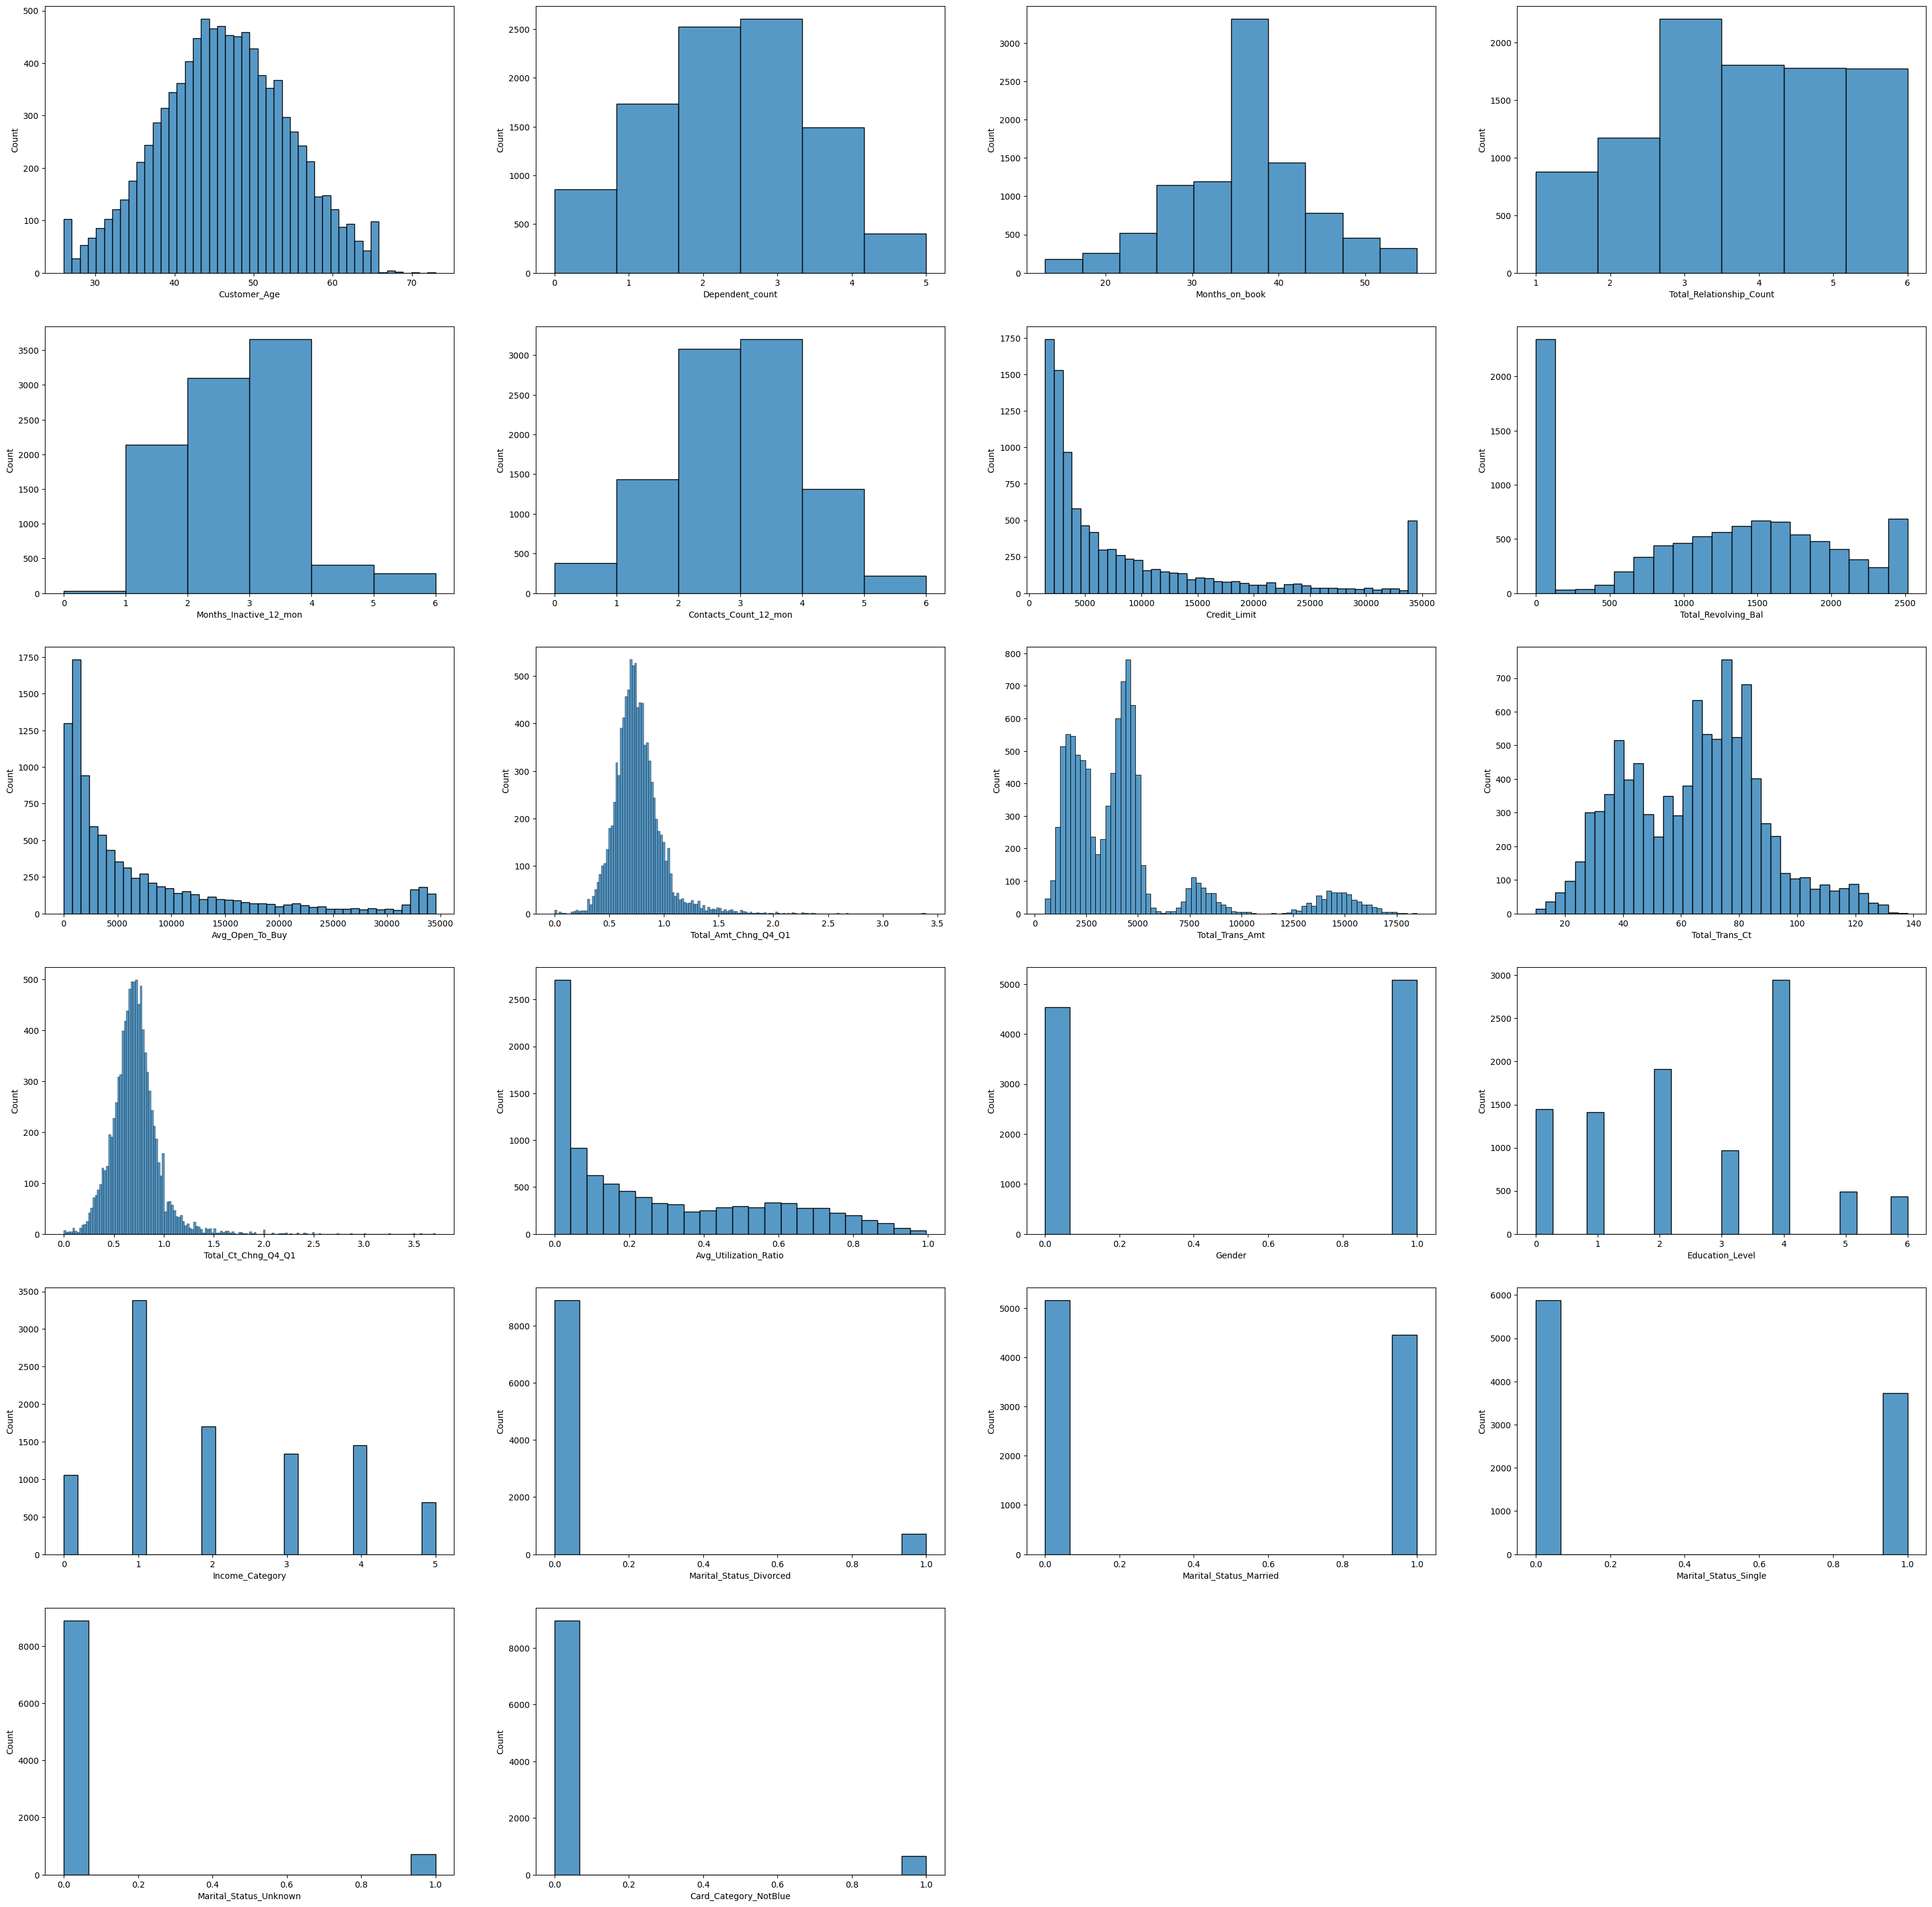

In [99]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(df_sample.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df_sample[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df_sample[col],bins=10)
        else:
            sns.histplot(df_sample[col])

In [100]:
df_sample.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender', 'Education_Level', 'Income_Category',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Card_Category_NotBlue', 'Attrition_Flag'],
      dtype='object')

In [101]:
log_var = ['Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1']

for idx,col in enumerate(log_var):
    df_sample[col] = np.log10(df_sample[col]+1)
    df_LE_check[col] = np.log10(df_LE_check[col]+1)

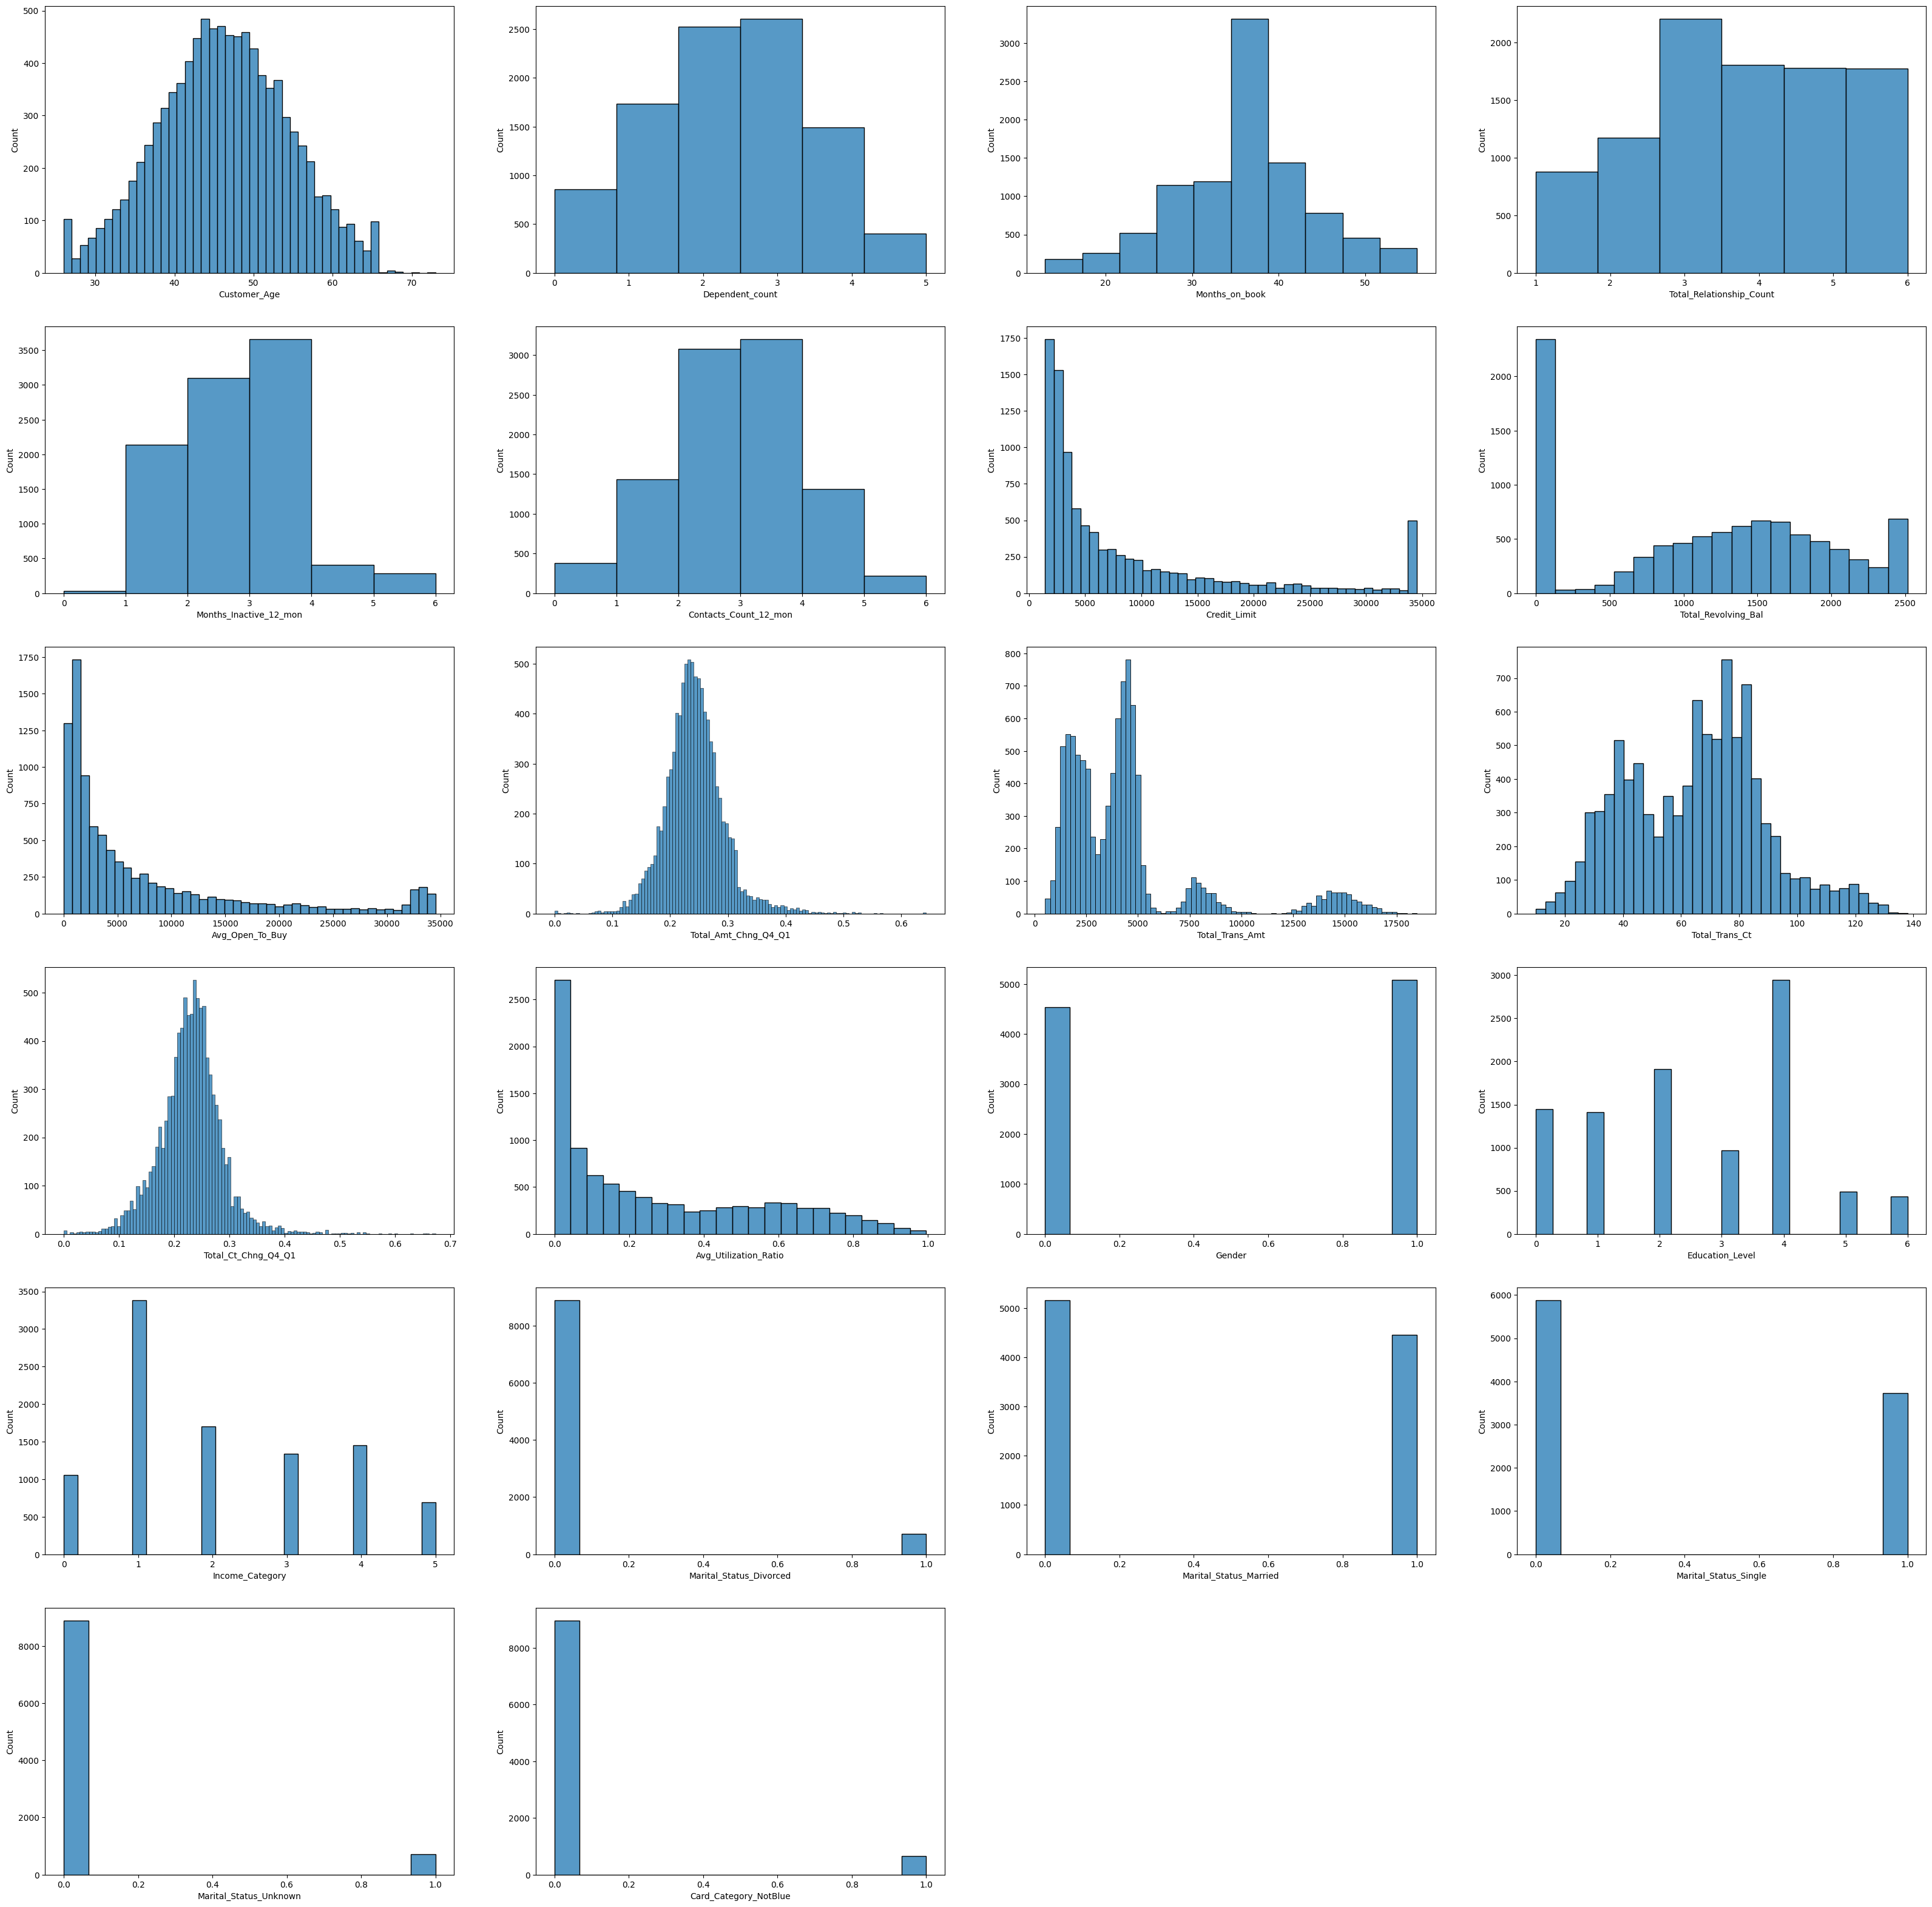

In [102]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(df_sample.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df_sample[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df_sample[col],bins=10)
        else:
            sns.histplot(df_sample[col])

### **Clear outlier**

#### **Strip Plot**

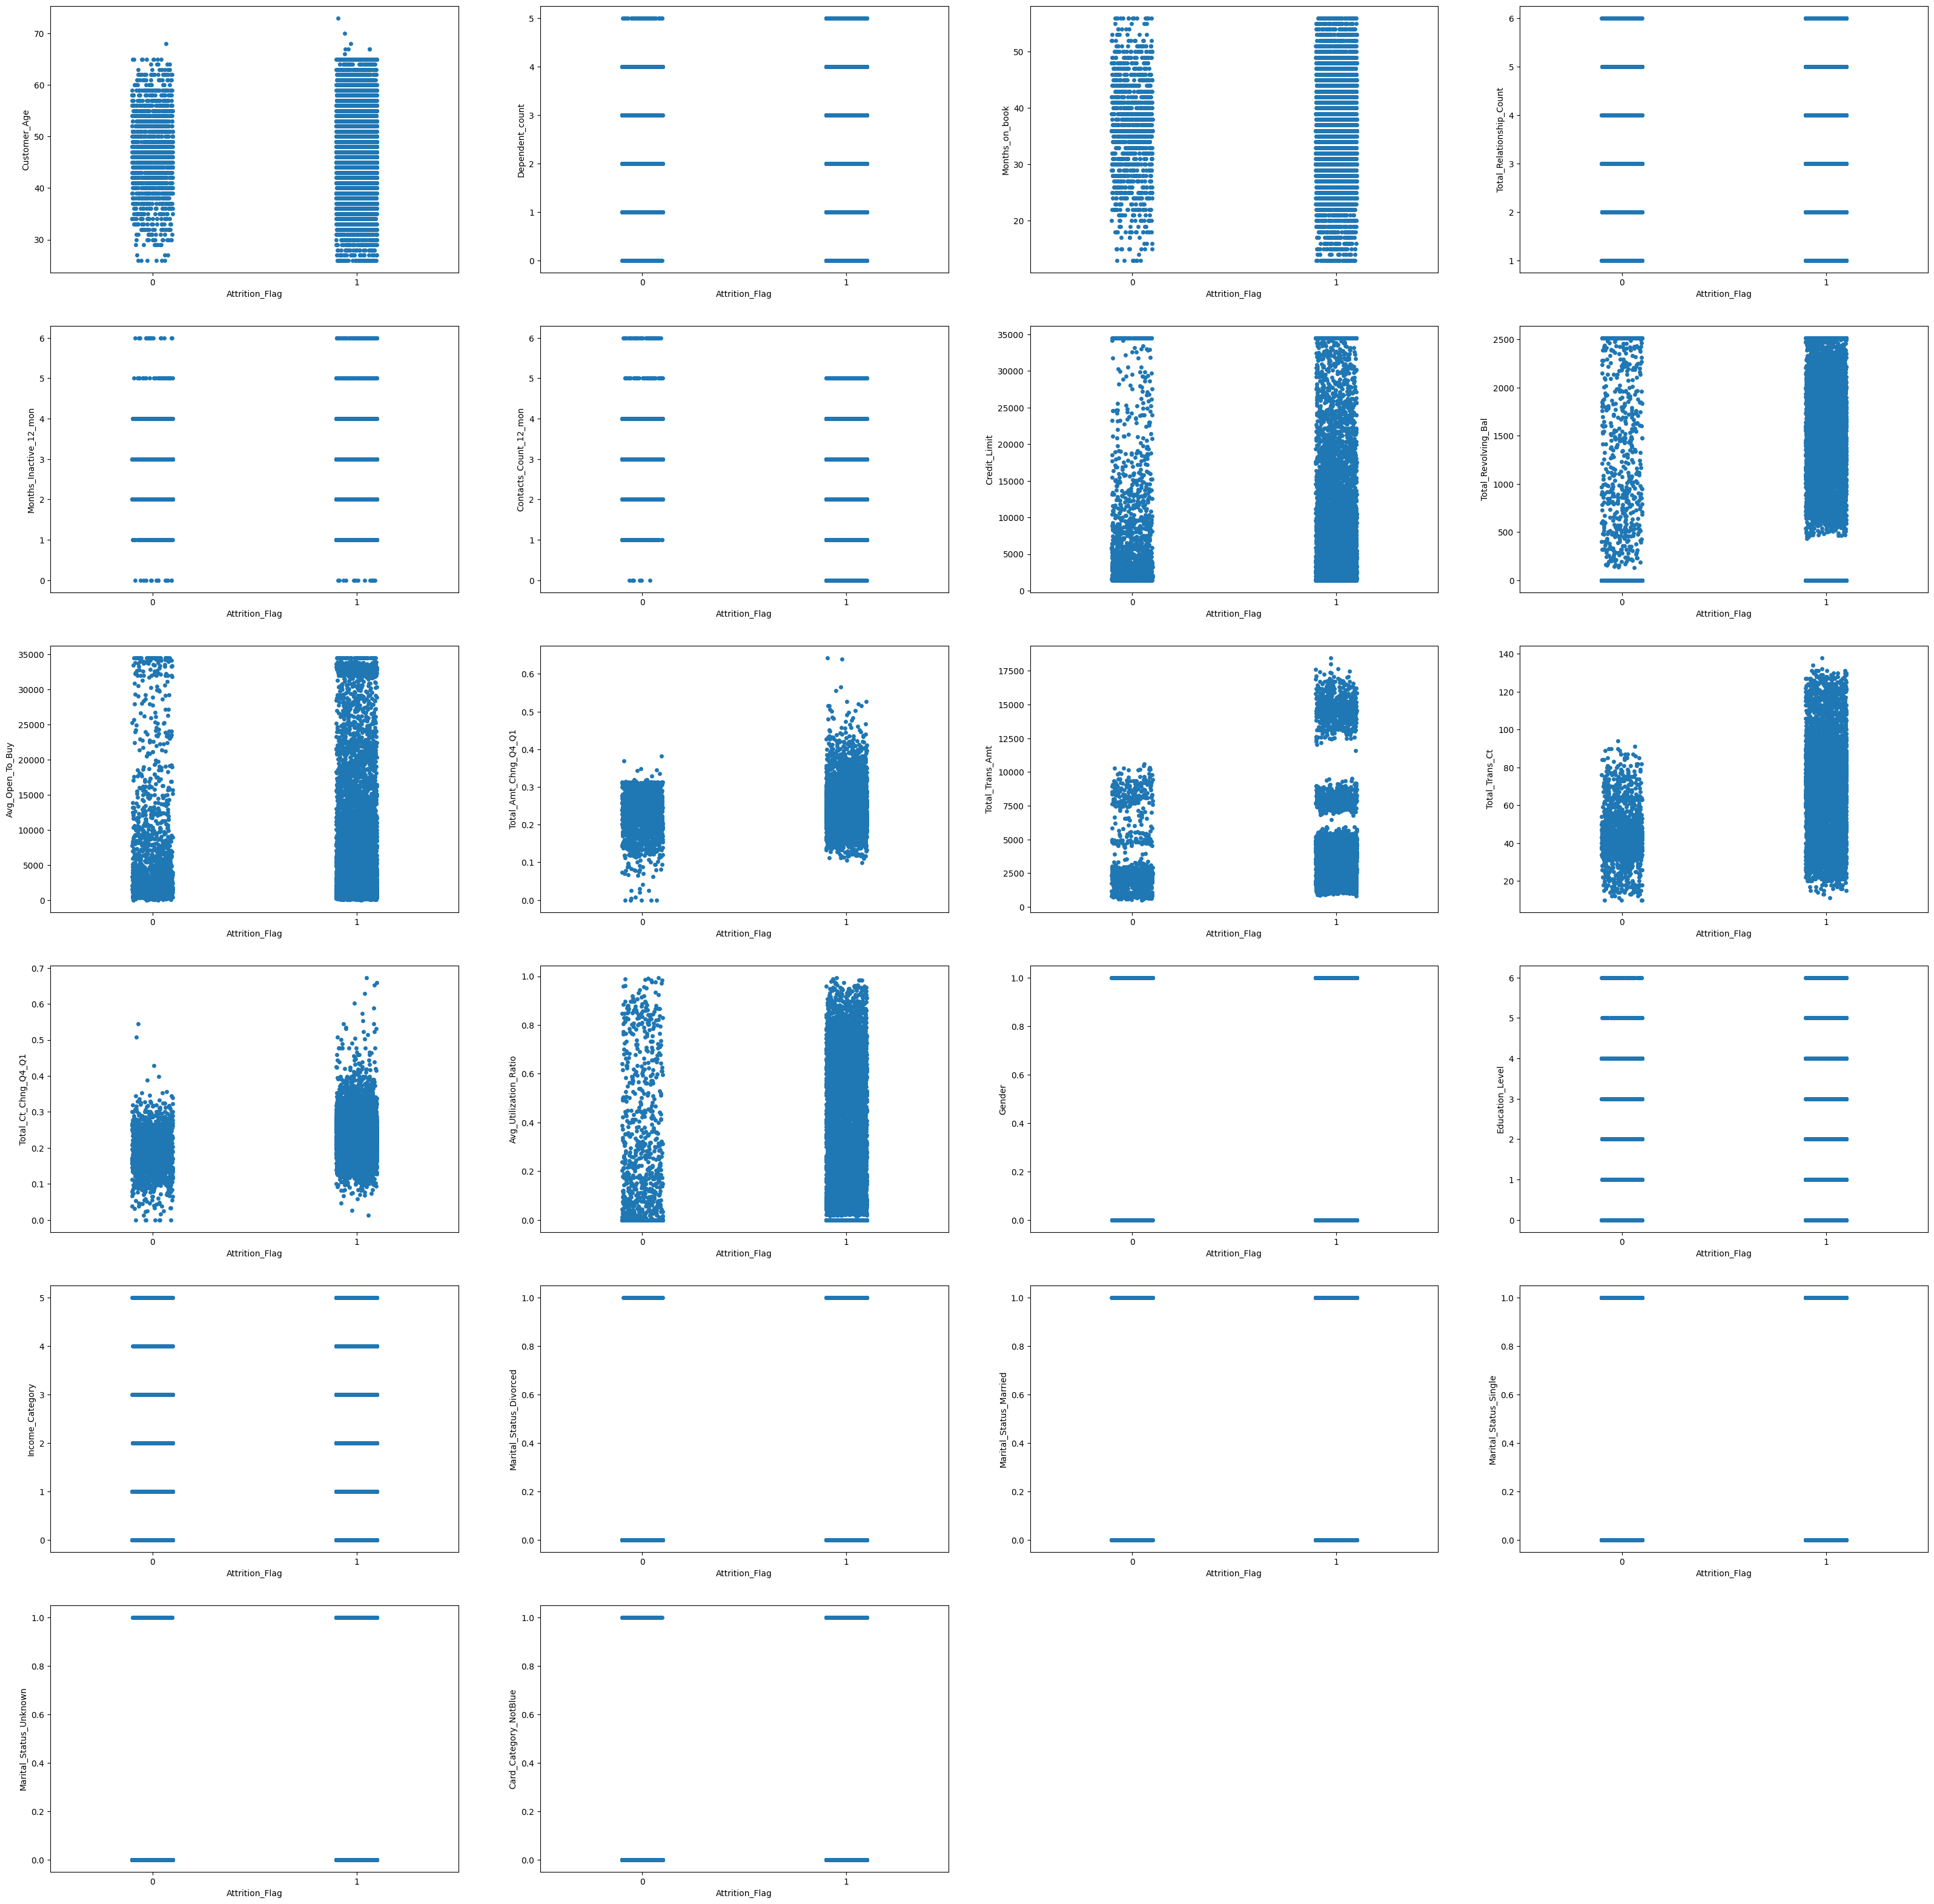

In [103]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(df_sample.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df_sample)

#### **Remove Outliers**

In [104]:
df_sample.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender', 'Education_Level', 'Income_Category',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Card_Category_NotBlue', 'Attrition_Flag'],
      dtype='object')

In [105]:
print('Before remove outlier, the shape of df_sample: {}'.format(df_sample.shape))

# df_sample = IQRdrop(df_sample, 'Total_Amt_Chng_Q4_Q1')
df_sample = df_sample.drop(df_sample[df_sample['Total_Amt_Chng_Q4_Q1'] >= 0.34].index & df_sample[df_sample['Attrition_Flag'] == 0].index)
df_sample = df_sample.drop(df_sample[df_sample['Total_Amt_Chng_Q4_Q1'] <= 0.1].index & df_sample[df_sample['Attrition_Flag'] == 0].index)
df_sample = df_sample.drop(df_sample[df_sample['Total_Amt_Chng_Q4_Q1'] >= 0.5].index & df_sample[df_sample['Attrition_Flag'] == 1].index)
df_sample = df_sample.drop(df_sample[df_sample['Total_Amt_Chng_Q4_Q1'] <= 0.0].index & df_sample[df_sample['Attrition_Flag'] == 1].index)
print('df_sample.shape after remove outlier Total_Amt_Chng_Q4_Q1 : {}'.format(df_sample.shape))

# df_sample = IQRdrop(df_sample, 'Total_Ct_Chng_Q4_Q1')
df_sample = df_sample.drop(df_sample[df_sample['Total_Ct_Chng_Q4_Q1'] >= 0.4].index & df_sample[df_sample['Attrition_Flag'] == 0].index)
df_sample = df_sample.drop(df_sample[df_sample['Total_Ct_Chng_Q4_Q1'] <= 0.05].index & df_sample[df_sample['Attrition_Flag'] == 0].index)
df_sample = df_sample.drop(df_sample[df_sample['Total_Ct_Chng_Q4_Q1'] >= 0.45].index & df_sample[df_sample['Attrition_Flag'] == 1].index)
df_sample = df_sample.drop(df_sample[df_sample['Total_Ct_Chng_Q4_Q1'] <= 0.07].index & df_sample[df_sample['Attrition_Flag'] == 1].index)
print('df_sample.shape after remove outlier Total_Ct_Chng_Q4_Q1 : {}'.format(df_sample.shape))

df_sample = IQRdrop(df_sample, 'Customer_Age')
print('df_sample.shape after remove outlier Customer_Age : {}'.format(df_sample.shape))


Before remove outlier, the shape of df_sample: (9620, 23)
df_sample.shape after remove outlier Total_Amt_Chng_Q4_Q1 : (9567, 23)
df_sample.shape after remove outlier Total_Ct_Chng_Q4_Q1 : (9513, 23)
df_sample.shape after remove outlier Customer_Age : (9511, 23)


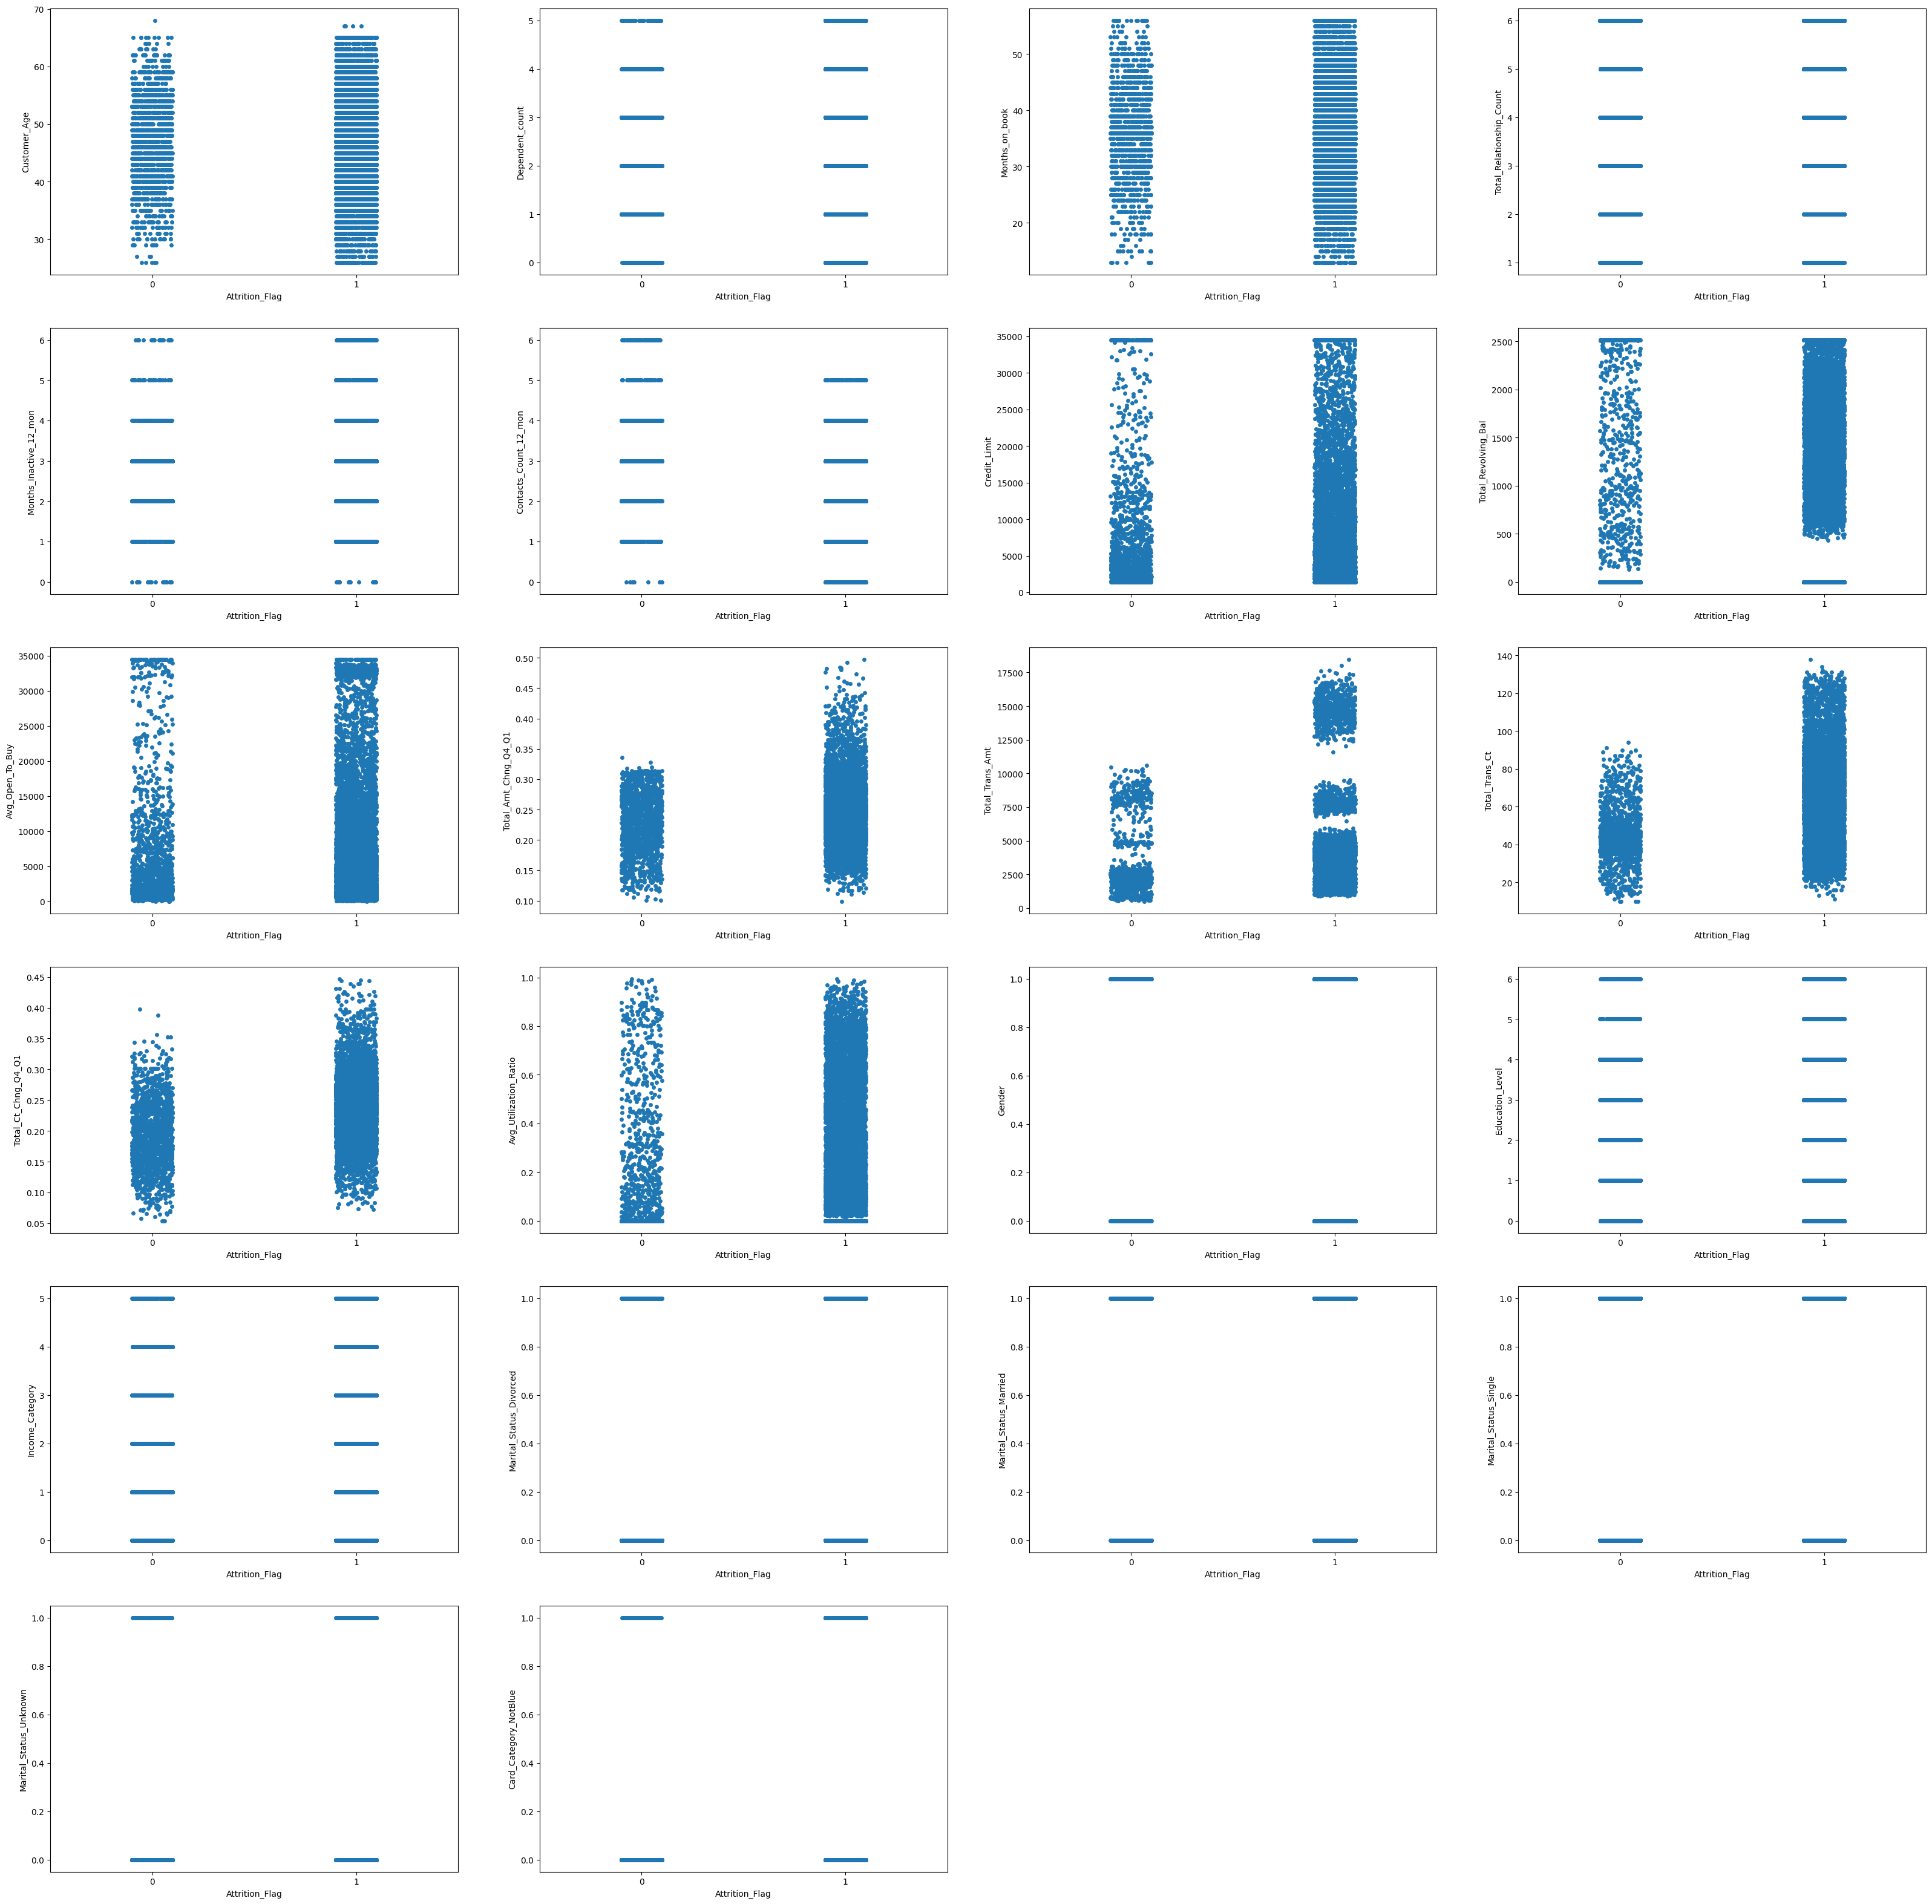

In [106]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(df_sample.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df_sample)

### **Feature Scaling (Numerical)**

In [107]:
min_max_scaler_up = MinMaxScaler()
for idx in df_sample.columns:
    if idx not in ['Attrition_Flag']:
        df_sample[idx]=min_max_scaler_up.fit_transform(df_sample[idx].values.reshape(-1,1))
        df_LE_check[idx]=min_max_scaler_up.transform(df_LE_check[idx].values.reshape(-1,1))

In [108]:
df_sample.describe()

Customer_Age  Dependent_count  Months_on_book  \
count   9511.000000      9511.000000     9511.000000   
mean       0.483696         0.469856        0.532871   
std        0.190608         0.259561        0.185777   
min        0.000000         0.000000        0.000000   
25%        0.357143         0.200000        0.418605   
50%        0.476190         0.400000        0.534884   
75%        0.619048         0.600000        0.627907   
max        1.000000         1.000000        1.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count               9511.000000             9511.000000   
mean                   0.562065                0.389689   
std                    0.311530                0.168415   
min                    0.000000                0.000000   
25%                    0.400000                0.333333   
50%                    0.600000                0.333333   
75%                    0.800000                0.500000   
max                    1.000000                1.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count            9511.000000   9511.000000          9511.000000   
mean                0.408387      0.216655             0.462847   
std                 0.184058      0.273726             0.323514   
min                 0.000000      0.000000             0.000000   
25%                 0.333333      0.033866             0.161104   
50%                 0.333333      0.094193             0.507747   
75%                 0.500000      0.288690             0.709178   
max                 1.000000      1.000000             1.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  Avg_Utilization_Ratio  \
count      9511.000000           9511.000000  ...            9511.000000   
mean          0.215318              0.359609  ...               0.276381   
std           0.262385              0.121038  ...               0.276840   
min           0.000000              0.000000  ...               0.000000   
25%           0.038385              0.284635  ...               0.025126   
50%           0.100417              0.353234  ...               0.176884   
75%           0.284110              0.426014  ...               0.505528   
max           1.000000              1.000000  ...               1.000000   

            Gender  Education_Level  Income_Category  Marital_Status_Divorced  \
count  9511.000000      9511.000000      9511.000000               9511.00000   
mean      0.529808         0.433218         0.416739                  0.07465   
std       0.499137         0.283395         0.294680                  0.26284   
min       0.000000         0.000000         0.000000                  0.00000   
25%       0.000000         0.166667         0.200000                  0.00000   
50%       1.000000         0.500000         0.400000                  0.00000   
75%       1.000000         0.666667         0.600000                  0.00000   
max       1.000000         1.000000         1.000000                  1.00000   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Unknown  \
count             9511.000000            9511.000000             9511.000000   
mean                 0.461781               0.389234                0.074335   
std                  0.498563               0.487602                0.262329   
min                  0.000000               0.000000                0.000000   
25%                  0.000000               0.000000                0.000000   
50%                  0.000000               0.000000                0.000000   
75%                  1.000000               1.000000                0.000000   
max                  1.000000               1.000000                1.000000   

       Card_Category_NotBlue  Attrition_Flag  
count            9511.000000     9511.000000  
mean                0.067185        0.842498  
std                 0.250356        0.364292  
min                 0.000000        0.0000

In [109]:
df_LE_check.describe()

Customer_Age  Dependent_count  Months_on_book  \
count    507.000000       507.000000      507.000000   
mean       0.483094         0.456410        0.535618   
std        0.191229         0.263852        0.184522   
min        0.000000         0.000000        0.000000   
25%        0.357143         0.200000        0.441860   
50%        0.500000         0.400000        0.534884   
75%        0.619048         0.600000        0.651163   
max        0.952381         1.000000        1.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count                507.000000              507.000000   
mean                   0.580671                0.399408   
std                    0.301284                0.169494   
min                    0.000000                0.000000   
25%                    0.400000                0.333333   
50%                    0.600000                0.333333   
75%                    0.800000                0.500000   
max                    1.000000                1.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count             507.000000    507.000000           507.000000   
mean                0.424392      0.218231             0.457218   
std                 0.185032      0.284161             0.318832   
min                 0.000000      0.000000             0.000000   
25%                 0.333333      0.031765             0.200040   
50%                 0.500000      0.083129             0.506953   
75%                 0.500000      0.283384             0.692690   
max                 1.000000      1.000000             1.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  Avg_Utilization_Ratio  \
count       507.000000            507.000000  ...             507.000000   
mean          0.217240              0.363128  ...               0.287493   
std           0.273225              0.128894  ...               0.280684   
min          -0.000203             -0.124856  ...               0.000000   
25%           0.033313              0.290298  ...               0.019598   
50%           0.093636              0.352607  ...               0.188945   
75%           0.281922              0.431281  ...               0.530653   
max           1.000000              0.991654  ...               1.004020   

           Gender  Education_Level  Income_Category  Marital_Status_Divorced  \
count  507.000000       507.000000       507.000000               507.000000   
mean     0.532544         0.439842         0.419329                 0.059172   
std      0.499433         0.275734         0.297322                 0.236179   
min      0.000000         0.000000         0.000000                 0.000000   
25%      0.000000         0.166667         0.200000                 0.000000   
50%      1.000000         0.500000         0.400000                 0.000000   
75%      1.000000         0.666667         0.600000                 0.000000   
max      1.000000         1.000000         1.000000                 1.000000   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Unknown  \
count              507.000000             507.000000              507.000000   
mean                 0.459566               0.410256                0.071006   
std                  0.498855               0.492366                0.257088   
min                  0.000000               0.000000                0.000000   
25%                  0.000000               0.000000                0.000000   
50%                  0.000000               0.000000                0.000000   
75%                  1.000000               1.000000                0.000000   
max                  1.000000               1.000000                1.000000   

       Card_Category_NotBlue  Attrition_Flag  
count             507.000000      507.000000  
mean                0.080868        0.848126  
std                 0.272901        0.359253  
min                 0.000000        0.000000  
25% 

### **Feature Selection**

In [110]:
selector = SelectKBest(f_classif, k=10)
x_sa = df_sample.drop(['Attrition_Flag'], axis = 1)
y_sa = df_sample['Attrition_Flag']

df_sa_anova = selector.fit(x_sa, y_sa)

col = selector.get_support(indices=True)
df_sa_anova = x_sa.iloc[:,col]

#### **Concatenate Data**

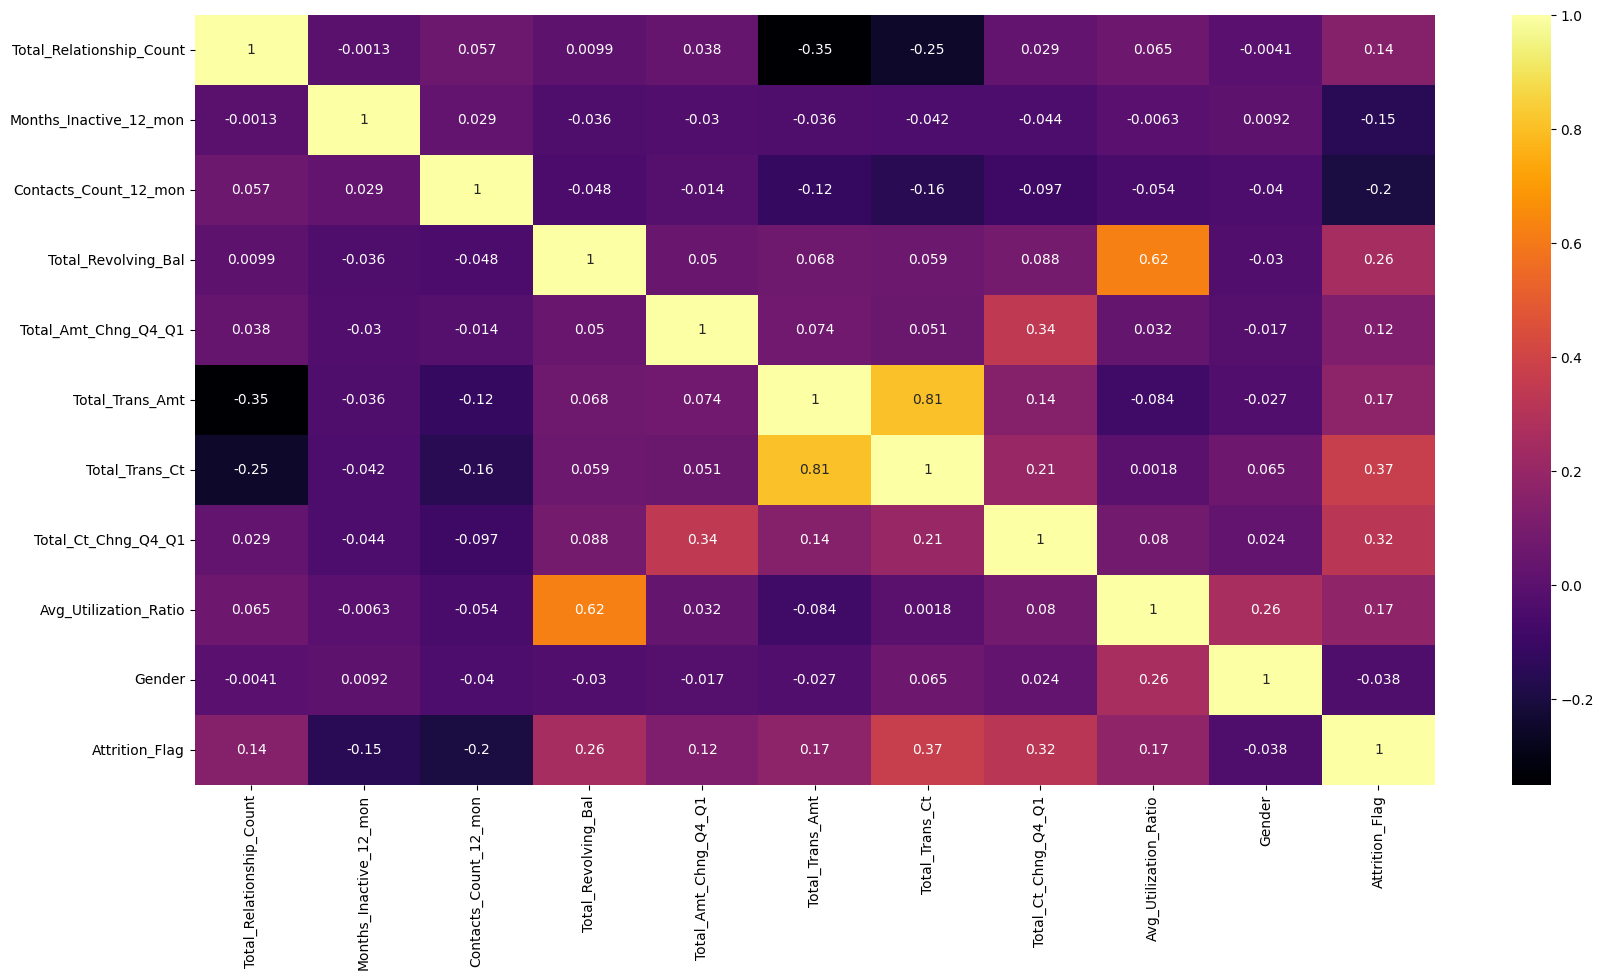

In [111]:
df_sa_anova = pd.concat([df_sa_anova, y_sa], axis=1)
checkCorrFF(df_sa_anova)

#### **Drop Feature**

In [112]:
df_sa_anova.drop(['Avg_Utilization_Ratio','Gender'], axis=1, inplace=True)

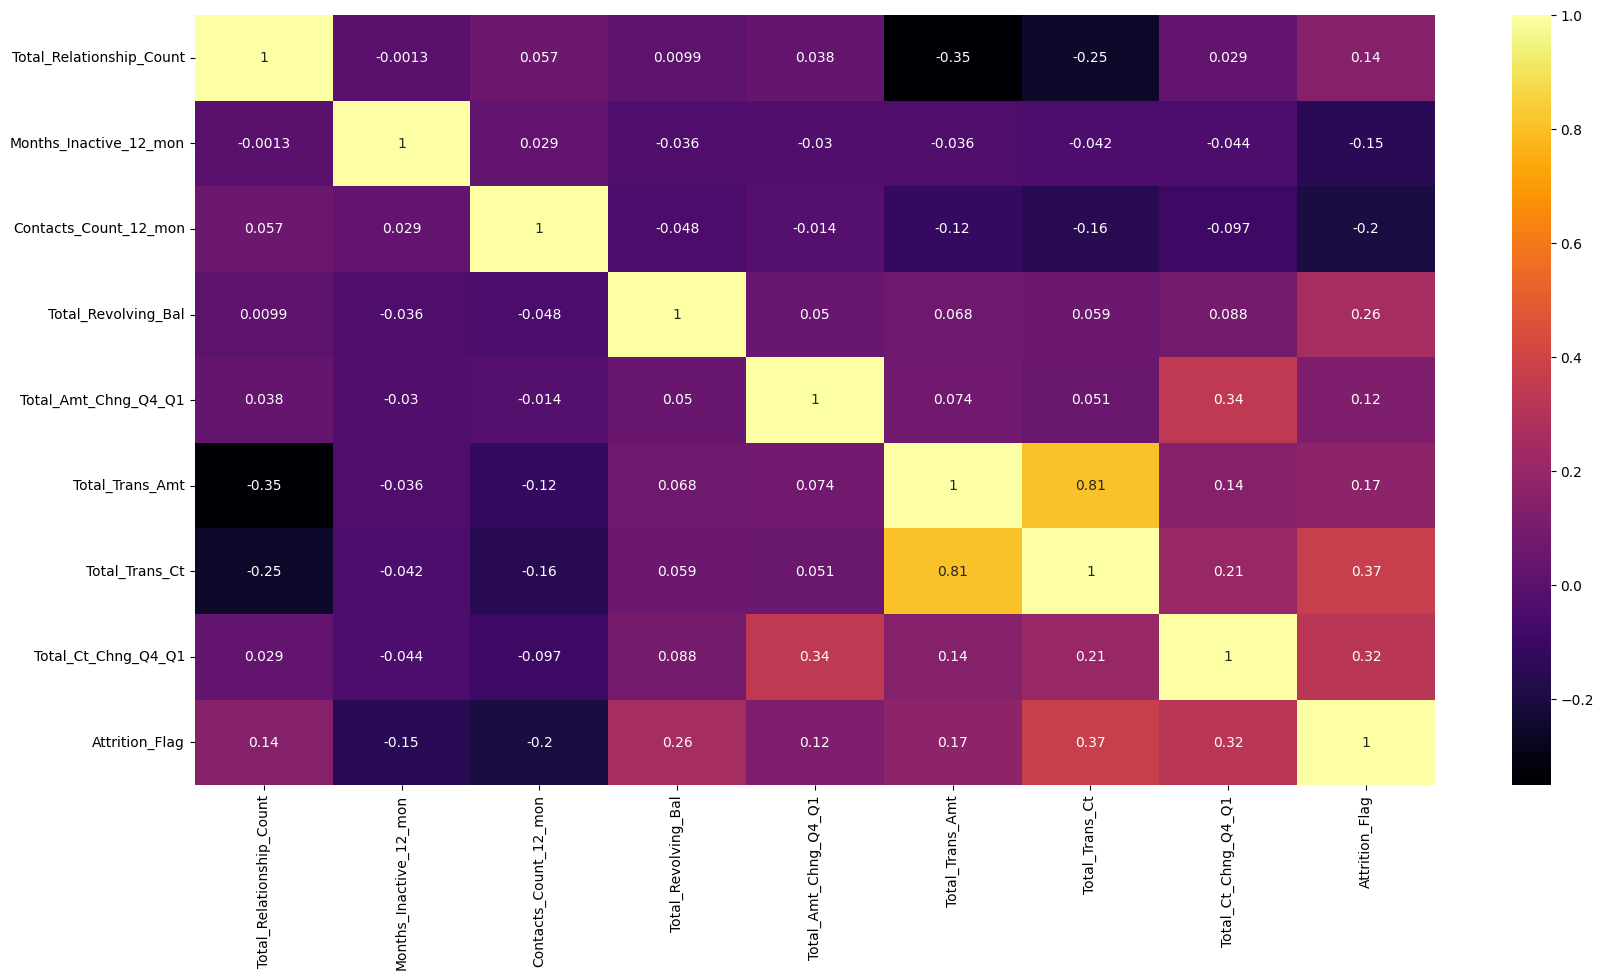

In [113]:
checkCorrFF(df_sa_anova)

In [114]:
x_sa_anova = df_sa_anova.drop(['Attrition_Flag'], axis = 1)
y_sa_anova = df_sa_anova['Attrition_Flag']

In [115]:
x_sa_anova

Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
7511                       1.0                0.166667               0.333333   
247                        0.4                0.500000               0.500000   
713                        0.6                0.333333               0.000000   
4527                       1.0                0.500000               0.333333   
6866                       1.0                0.333333               0.333333   
...                        ...                     ...                    ...   
9225                       0.0                0.500000               0.500000   
4859                       0.6                0.500000               0.500000   
3264                       0.6                0.500000               0.000000   
9845                       0.4                0.500000               0.333333   
2732                       0.6                0.333333               0.666667   

      Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
7511             0.524037              0.421899         0.227440   
247              0.000000              0.495886         0.010626   
713              0.651172              0.426600         0.058140   
4527             0.000000              0.247263         0.069489   
6866             0.000000              0.236146         0.218594   
...                   ...                   ...              ...   
9225             0.535956              0.485381         0.701791   
4859             0.255066              0.401090         0.185045   
3264             0.711164              0.496436         0.199455   
9845             0.586412              0.369421         0.758596   
2732             0.769964              0.261684         0.061533   

      Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  
7511        0.445312             0.404711  
247         0.070312             0.465893  
713         0.226562             0.398606  
4527        0.187500             0.076321  
6866        0.554688             0.641835  
...              ...                  ...  
9225        0.726562             0.477986  
4859        0.554688             0.463330  
3264        0.445312             0.579526  
9845        0.851562             0.496816  
2732        0.210938             0.436711  

[9511 rows x 8 columns]

In [116]:
y_sa_anova

7511    1
247     0
713     1
4527    0
6866    1
       ..
9225    1
4859    1
3264    1
9845    1
2732    1
Name: Attrition_Flag, Length: 9511, dtype: int64

#### **Train Test Split Data**

In [117]:
x_sa_anova_train,x_sa_anova_test,y_sa_anova_train,y_sa_anova_test = train_test_split(x_sa_anova, y_sa_anova, test_size = 0.2, random_state = 0)

## **Resampling Method 0** : No Resampling 
<hr>

1    6433
0    1175
Name: Attrition_Flag, dtype: int64


<AxesSubplot: ylabel='Type'>

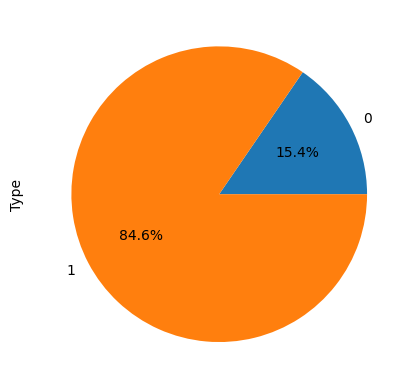

In [118]:
df_sa_anova_train =  pd.concat([x_sa_anova_train, y_sa_anova_train], axis=1)

print(df_sa_anova_train["Attrition_Flag"].value_counts())

df_sa_anova_train.groupby('Attrition_Flag').size().plot(kind='pie',
                                       y = "Attrition_Flag",
                                       label = "Type",
                                       autopct='%1.1f%%')

### **Repeated k-Fold Cross-Validation**

>f1 score 1 mean=0.9411 se=0.002
>f1 score 2 mean=0.9412 se=0.001
>f1 score 3 mean=0.9413 se=0.001
>f1 score 4 mean=0.9414 se=0.001
>f1 score 5 mean=0.9414 se=0.001


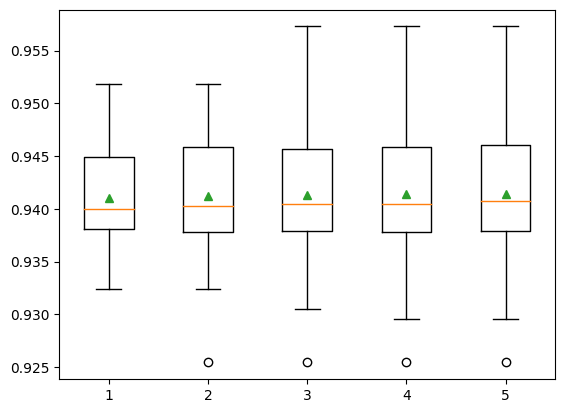

In [119]:
_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_sa_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_sa_anova = evaluate_model(x_sa_anova_train, y_sa_anova_train, r,'f1')
	# summarize
	print('>f1 score %d mean=%.4f se=%.3f' % (r, np.mean(scores_sa_anova), sem(scores_sa_anova)))
	# store
	results_sa_anova.append(scores_sa_anova)
# plot the results
plt.boxplot(results_sa_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [120]:
grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_sa_anova=LogisticRegression()
logreg_cv_sa_anova=GridSearchCV(logreg_sa_anova
                       ,grid
                       ,cv=10
                       ,scoring='f1'
                       ,n_jobs=-1)
logreg_cv_sa_anova.fit(x_sa_anova_train,y_sa_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_sa_anova.best_params_)
print("f1 :",logreg_cv_sa_anova.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
f1 : 0.9419903670106095


In [121]:
clf_sa_anova = LogisticRegression(C=logreg_cv_sa_anova.best_params_['C']#
                                  , penalty=logreg_cv_sa_anova.best_params_['penalty']
                                  , solver=logreg_cv_sa_anova.best_params_['solver'])

clf_sa_anova.fit(x_sa_anova_train,y_sa_anova_train)
print("model score: %.8f" % clf_sa_anova.score(x_sa_anova_test, y_sa_anova_test))

model score: 0.89595376


### **Model Threshold**

(0.0, 1.0)

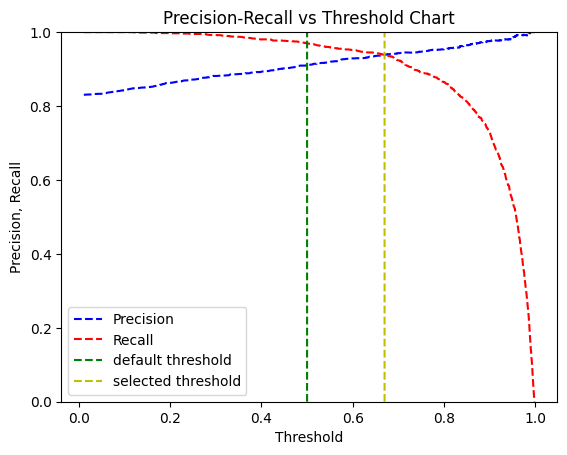

In [122]:
pred_y_sa=clf_sa_anova.predict(x_sa_anova_test) 

probs_y_sa=clf_sa_anova.predict_proba(x_sa_anova_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_sa_anova_test, probs_y_sa[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.plot(np.full(3252, 0.5),np.arange(0,1,1/3252), "g--", label="default threshold")
plt.plot(np.full(3252, 0.67),np.arange(0,1,1/3252), "y--", label="selected threshold")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### **Classification report**

#### **Predict using Train Data**

In [123]:
# Classification report
y_sa_anova_pred = clf_sa_anova.predict(x_sa_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_train, y_pred=y_sa_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_train, y_pred=y_sa_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.76      0.49      0.60      1175
           1       0.91      0.97      0.94      6433

    accuracy                           0.90      7608
   macro avg       0.84      0.73      0.77      7608
weighted avg       0.89      0.90      0.89      7608

Confusion matrix 
[[ 579  596]
 [ 180 6253]]


#### **Predict using Test Data**

In [124]:
# Classification report
y_sa_anova_pred = clf_sa_anova.predict(x_sa_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_sa_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_sa_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.78      0.54      0.64       323
           1       0.91      0.97      0.94      1580

    accuracy                           0.90      1903
   macro avg       0.85      0.75      0.79      1903
weighted avg       0.89      0.90      0.89      1903

Confusion matrix 
[[ 173  150]
 [  48 1532]]


#### **Predict using Test Data with new threshold**

In [125]:
y_pred_new_threshold = (clf_sa_anova.predict_proba(x_sa_anova_test)[:,1]>=0.67).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))

Classification report 
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       323
           1       0.94      0.94      0.94      1580

    accuracy                           0.90      1903
   macro avg       0.82      0.82      0.82      1903
weighted avg       0.90      0.90      0.90      1903

Confusion matrix 
[[ 227   96]
 [  97 1483]]


## **Resampling Method 1** : SMOTE (Synthetic Minority Oversampling TEchnique)
<hr>

### **Resampling**

In [126]:
su = SMOTE(random_state=42)
x_su, y_su = su.fit_resample(x_sa_anova_train, y_sa_anova_train)
df_up_anova = pd.concat([x_su, y_su], axis=1)

0    6433
1    6433
Name: Attrition_Flag, dtype: int64


<AxesSubplot: ylabel='Type'>

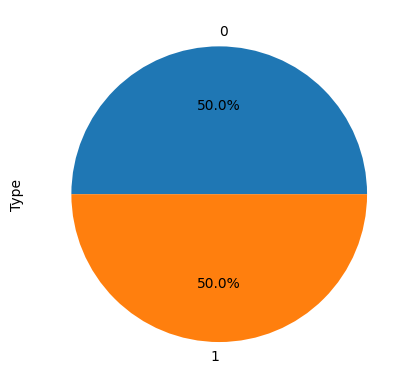

In [127]:
print(df_up_anova["Attrition_Flag"].value_counts())

df_up_anova.groupby('Attrition_Flag').size().plot(kind='pie',
                                       y = "Attrition_Flag",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [128]:
df_up_anova.describe()

Total_Relationship_Count  Months_Inactive_12_mon  \
count              12866.000000            12866.000000   
mean                   0.522030                0.413170   
std                    0.317091                0.157170   
min                    0.000000                0.000000   
25%                    0.200000                0.333333   
50%                    0.540206                0.496830   
75%                    0.800000                0.500000   
max                    1.000000                1.000000   

       Contacts_Count_12_mon  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
count           12866.000000         12866.000000          12866.000000   
mean                0.442420             0.385505              0.346161   
std                 0.184788             0.355545              0.118775   
min                 0.000000             0.000000              0.000000   
25%                 0.333333             0.000000              0.270516   
50%                 0.500000             0.377433              0.346313   
75%                 0.500000             0.679274              0.422427   
max                 1.000000             1.000000              1.000000   

       Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Attrition_Flag  
count     12866.000000    12866.000000         12866.000000    12866.000000  
mean          0.190896        0.371284             0.405470        0.500000  
std           0.171074        0.171888             0.139569        0.500019  
min           0.000000        0.000000             0.000000        0.000000  
25%           0.087541        0.241467             0.310136        0.000000  
50%           0.120469        0.328125             0.410109        0.500000  
75%           0.227036        0.500000             0.498060        1.000000  
max           1.000000        0.968750             0.993269        1.000000

### **Repeated k-Fold Cross-Validation**

>f1 score 1 mean=0.8459 se=0.005
>f1 score 2 mean=0.8463 se=0.003
>f1 score 3 mean=0.8465 se=0.002
>f1 score 4 mean=0.8466 se=0.002
>f1 score 5 mean=0.8466 se=0.001


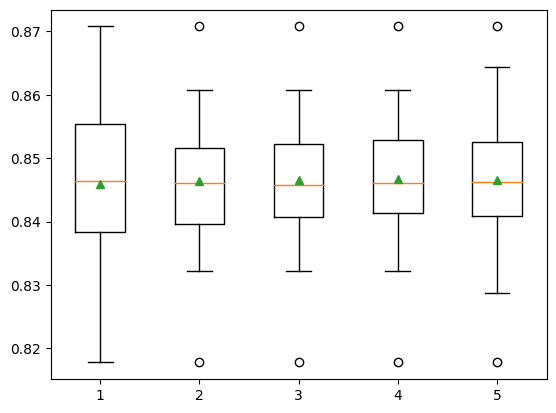

In [129]:
x_up_anova_train = df_up_anova.drop(['Attrition_Flag'], axis = 1)
y_up_anova_train = df_up_anova['Attrition_Flag']

_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_up_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_up_anova = evaluate_model(x_up_anova_train, y_up_anova_train, r,'f1')
	# summarize
	print('>f1 score %d mean=%.4f se=%.3f' % (r, np.mean(scores_up_anova), sem(scores_up_anova)))
	# store
	results_up_anova.append(scores_up_anova)
# plot the results
plt.boxplot(results_up_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [130]:
grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_up_anova=LogisticRegression()
logreg_cv_up_anova=GridSearchCV(logreg_up_anova
                       ,grid
                       ,cv=10
                       ,scoring='f1'
                       ,n_jobs=-1)
logreg_cv_up_anova.fit(x_up_anova_train,y_up_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_up_anova.best_params_)
print("f1 :",logreg_cv_up_anova.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
f1 : 0.8470775059798348


In [131]:
clf_up_anova = LogisticRegression(C=logreg_cv_up_anova.best_params_['C']#
                                  , penalty=logreg_cv_up_anova.best_params_['penalty']
                                  , solver=logreg_cv_up_anova.best_params_['solver'])

clf_up_anova.fit(x_up_anova_train,y_up_anova_train)
print("model score: %.8f" % clf_up_anova.score(x_sa_anova_test, y_sa_anova_test))

model score: 0.82816605


### **Model Threshold**

(0.0, 1.0)

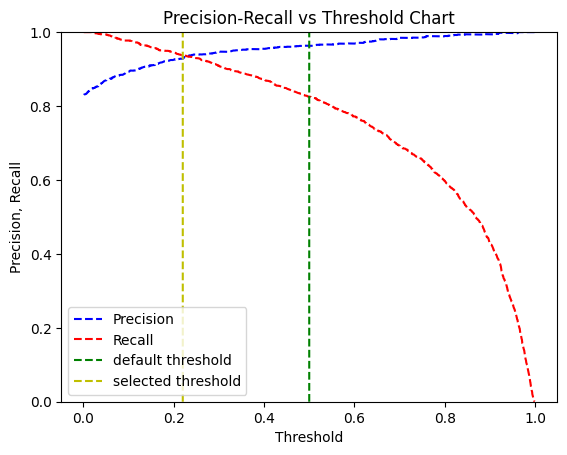

In [132]:
pred_y_up=clf_up_anova.predict(x_sa_anova_test) 

probs_y_up=clf_up_anova.predict_proba(x_sa_anova_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_sa_anova_test, probs_y_up[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.plot(np.full(3252, 0.5),np.arange(0,1,1/3252), "g--", label="default threshold")
plt.plot(np.full(3252, 0.22),np.arange(0,1,1/3252), "y--", label="selected threshold")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### **Classification report**

#### **Predict using Train Data**

In [133]:
# Classification report
y_up_anova_pred = clf_up_anova.predict(x_up_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_up_anova_train, y_pred=y_up_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_up_anova_train, y_pred=y_up_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      6433
           1       0.85      0.84      0.85      6433

    accuracy                           0.85     12866
   macro avg       0.85      0.85      0.85     12866
weighted avg       0.85      0.85      0.85     12866

Confusion matrix 
[[5514  919]
 [1032 5401]]


#### **Predict using Test Data**

In [134]:
# Classification report
y_up_anova_pred = clf_up_anova.predict(x_sa_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_up_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_up_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       323
           1       0.96      0.82      0.89      1580

    accuracy                           0.83      1903
   macro avg       0.73      0.83      0.76      1903
weighted avg       0.88      0.83      0.84      1903

Confusion matrix 
[[ 273   50]
 [ 277 1303]]


#### **Predict using Test Data with new threshold**

In [135]:
y_pred_new_threshold = (clf_up_anova.predict_proba(x_sa_anova_test)[:,1]>=0.22).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))

Classification report 
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       323
           1       0.93      0.94      0.93      1580

    accuracy                           0.89      1903
   macro avg       0.80      0.79      0.80      1903
weighted avg       0.89      0.89      0.89      1903

Confusion matrix 
[[ 209  114]
 [ 100 1480]]


## **Resampling Method 2** : RandomUnderSampler
<hr>

### **Resampling**

In [136]:
X = df_sa_anova_train.drop(['Attrition_Flag'], axis = 1)
y = df_sa_anova_train['Attrition_Flag']

In [137]:
from imblearn.under_sampling import RandomUnderSampler
oss =  RandomUnderSampler(random_state=0)
X_resampled, y_resampled = oss.fit_resample(X, y)
df_dwsampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

0    1175
1    1175
Name: Attrition_Flag, dtype: int64


<AxesSubplot: ylabel='Type'>

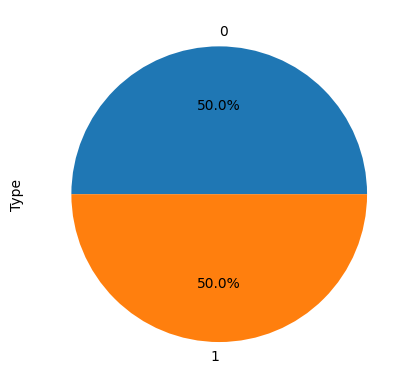

In [138]:
print(df_dwsampled["Attrition_Flag"].value_counts())

df_dwsampled.groupby('Attrition_Flag').size().plot(kind='pie',
                                       y = "Attrition_Flag",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [139]:
df_dwsampled.describe()

Total_Relationship_Count  Months_Inactive_12_mon  \
count               2350.000000             2350.000000   
mean                   0.525872                0.412482   
std                    0.319594                0.166206   
min                    0.000000                0.000000   
25%                    0.200000                0.333333   
50%                    0.600000                0.500000   
75%                    0.800000                0.500000   
max                    1.000000                1.000000   

       Contacts_Count_12_mon  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
count            2350.000000          2350.000000           2350.000000   
mean                0.441986             0.384227              0.344778   
std                 0.190078             0.359077              0.122402   
min                 0.000000             0.000000              0.005192   
25%                 0.333333             0.000000              0.265089   
50%                 0.500000             0.366309              0.345682   
75%                 0.500000             0.687525              0.424252   
max                 1.000000             1.000000              0.873410   

       Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Attrition_Flag  
count      2350.000000     2350.000000          2350.000000     2350.000000  
mean          0.191107        0.367909             0.407243        0.500000  
std           0.176778        0.175706             0.146011        0.500106  
min           0.000000        0.000000             0.000000        0.000000  
25%           0.085693        0.234375             0.310136        0.000000  
50%           0.121175        0.328125             0.410782        0.500000  
75%           0.226883        0.492188             0.504105        1.000000  
max           0.972794        0.945312             0.980085        1.000000

### **Repeated k-Fold Cross-Validation**

>f1 score 1 mean=0.8284 se=0.009
>f1 score 2 mean=0.8274 se=0.006
>f1 score 3 mean=0.8270 se=0.006
>f1 score 4 mean=0.8263 se=0.005
>f1 score 5 mean=0.8269 se=0.004


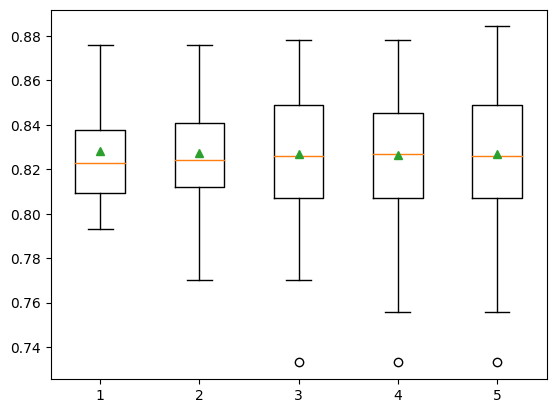

In [140]:
x_dw_anova_train = df_dwsampled.drop(['Attrition_Flag'], axis = 1)
y_dw_anova_train = df_dwsampled['Attrition_Flag']

_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_dw_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_dw_anova = evaluate_model(x_dw_anova_train, y_dw_anova_train, r,'f1')
	# summarize
	print('>f1 score %d mean=%.4f se=%.3f' % (r, np.mean(scores_dw_anova), sem(scores_dw_anova)))
	# store
	results_dw_anova.append(scores_dw_anova)
# plot the results
plt.boxplot(results_dw_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [141]:
grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_dw_anova=LogisticRegression()
logreg_cv_dw_anova=GridSearchCV(logreg_dw_anova
                       ,grid
                       ,cv=10
                       ,scoring='f1'
                       ,n_jobs=-1)
logreg_cv_dw_anova.fit(x_dw_anova_train,y_dw_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_dw_anova.best_params_)
print("f1 :",logreg_cv_dw_anova.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1e-06, 'penalty': 'none', 'solver': 'sag'}
f1 : 0.8324177904380765


In [142]:
clf_dw_anova = LogisticRegression(C=logreg_cv_dw_anova.best_params_['C']#
                                  , penalty=logreg_cv_dw_anova.best_params_['penalty']
                                  , solver=logreg_cv_dw_anova.best_params_['solver'])

clf_dw_anova.fit(x_dw_anova_train,y_dw_anova_train)
print("model score: %.8f" % clf_dw_anova.score(x_sa_anova_test, y_sa_anova_test))

model score: 0.83499737


### **Model Threshold**

(0.0, 1.0)

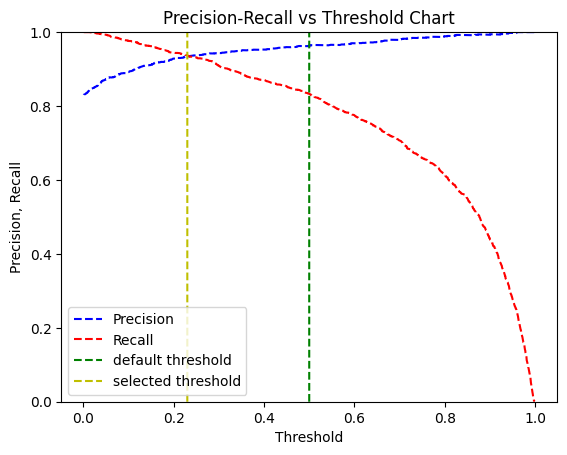

In [143]:
pred_y_dw=clf_dw_anova.predict(x_sa_anova_test) 

probs_y_dw=clf_dw_anova.predict_proba(x_sa_anova_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_sa_anova_test, probs_y_dw[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.plot(np.full(3252, 0.5),np.arange(0,1,1/3252), "g--", label="default threshold")
plt.plot(np.full(3252, 0.23),np.arange(0,1,1/3252), "y--", label="selected threshold")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### **Classification report**

#### **Predict using Train Data**

In [144]:
# Classification report
y_dw_anova_pred = clf_dw_anova.predict(x_dw_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_dw_anova_train, y_pred=y_dw_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_dw_anova_train, y_pred=y_dw_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1175
           1       0.84      0.83      0.84      1175

    accuracy                           0.84      2350
   macro avg       0.84      0.84      0.84      2350
weighted avg       0.84      0.84      0.84      2350

Confusion matrix 
[[995 180]
 [202 973]]


#### **Predict using Test Data**

In [145]:
# Classification report
y_dw_anova_pred = clf_dw_anova.predict(x_sa_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_dw_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_dw_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.51      0.85      0.63       323
           1       0.96      0.83      0.89      1580

    accuracy                           0.83      1903
   macro avg       0.74      0.84      0.76      1903
weighted avg       0.89      0.83      0.85      1903

Confusion matrix 
[[ 273   50]
 [ 264 1316]]


#### **Predict using Test Data with new threshold**

In [146]:
y_pred_new_threshold = (clf_dw_anova.predict_proba(x_sa_anova_test)[:,1]>=0.23).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))

Classification report 
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       323
           1       0.93      0.94      0.94      1580

    accuracy                           0.89      1903
   macro avg       0.81      0.81      0.81      1903
weighted avg       0.89      0.89      0.89      1903

Confusion matrix 
[[ 219  104]
 [  99 1481]]


## **Resampling Method 3** : Tomek Links
<hr>

### **Resampling**

In [147]:
df_sa_anova_train =  pd.concat([x_sa_anova_train, y_sa_anova_train], axis=1)

undersample = TomekLinks()

# transform the dataset
dfX = df_sa_anova_train.drop(['Attrition_Flag'], axis=1)
dfY = df_sa_anova_train['Attrition_Flag']
X, y = undersample.fit_resample(dfX, dfY)
dfTomek = pd.concat([X, y], axis=1)

1    6300
0    1175
Name: Attrition_Flag, dtype: int64


<AxesSubplot: ylabel='Type'>

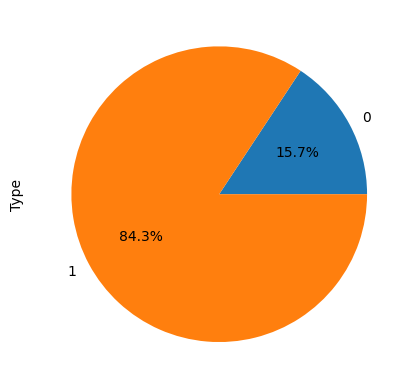

In [148]:
print(dfTomek["Attrition_Flag"].value_counts())

dfTomek.groupby('Attrition_Flag').size().plot(kind='pie',
                                       y = "Attrition_Flag",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [149]:
dfTomek.describe()

Total_Relationship_Count  Months_Inactive_12_mon  \
count               7475.000000             7475.000000   
mean                   0.562488                0.389320   
std                    0.312157                0.168722   
min                    0.000000                0.000000   
25%                    0.400000                0.333333   
50%                    0.600000                0.333333   
75%                    0.800000                0.500000   
max                    1.000000                1.000000   

       Contacts_Count_12_mon  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
count            7475.000000          7475.000000           7475.000000   
mean                0.405619             0.464716              0.360618   
std                 0.184106             0.322799              0.120776   
min                 0.000000             0.000000              0.000000   
25%                 0.333333             0.188121              0.286637   
50%                 0.333333             0.508939              0.353861   
75%                 0.500000             0.709376              0.427186   
max                 1.000000             1.000000              1.000000   

       Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Attrition_Flag  
count      7475.000000     7475.000000          7475.000000     7475.000000  
mean          0.222627        0.436676             0.447538        0.842809  
std           0.191345        0.181680             0.131214        0.364005  
min           0.000000        0.000000             0.000000        0.000000  
25%           0.097224        0.289062             0.373149        1.000000  
50%           0.193168        0.453125             0.451723        1.000000  
75%           0.237371        0.554688             0.524473        1.000000  
max           1.000000        0.968750             0.993269        1.000000

### **Repeated k-Fold Cross-Validation**

>f1 score 1 mean=0.9432 se=0.003
>f1 score 2 mean=0.9432 se=0.002
>f1 score 3 mean=0.9432 se=0.001
>f1 score 4 mean=0.9433 se=0.001
>f1 score 5 mean=0.9432 se=0.001


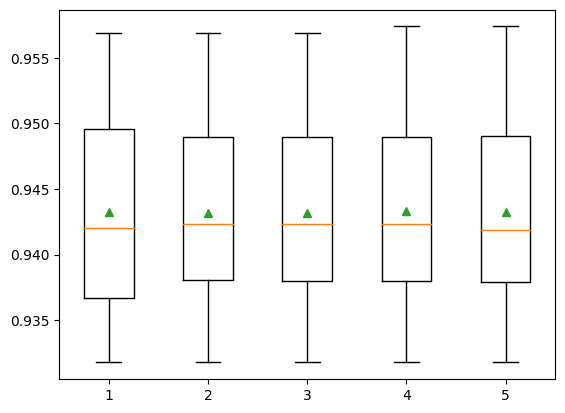

In [150]:
x_tm_anova_train = dfTomek.drop(['Attrition_Flag'], axis = 1)
y_tm_anova_train = dfTomek['Attrition_Flag']

_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_tm_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_tm_anova = evaluate_model(x_tm_anova_train, y_tm_anova_train, r,'f1')
	# summarize
	print('>f1 score %d mean=%.4f se=%.3f' % (r, np.mean(scores_tm_anova), sem(scores_tm_anova)))
	# store
	results_tm_anova.append(scores_tm_anova)
# plot the results
plt.boxplot(results_tm_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [151]:
grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_tm_anova=LogisticRegression()
logreg_cv_tm_anova=GridSearchCV(logreg_tm_anova
                       ,grid
                       ,cv=10
                       ,scoring='f1'
                       ,n_jobs=-1)
logreg_cv_tm_anova.fit(x_tm_anova_train,y_tm_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_tm_anova.best_params_)
print("f1 :",logreg_cv_tm_anova.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
f1 : 0.9434757726406284


In [152]:
clf_tm_anova = LogisticRegression(C=logreg_cv_tm_anova.best_params_['C']#
                                  , penalty=logreg_cv_tm_anova.best_params_['penalty']
                                  , solver=logreg_cv_tm_anova.best_params_['solver'])

clf_tm_anova.fit(x_tm_anova_train,y_tm_anova_train)
print("model score: %.8f" % clf_tm_anova.score(x_sa_anova_test, y_sa_anova_test))

model score: 0.89490279


### **Model Threshold**

(0.0, 1.0)

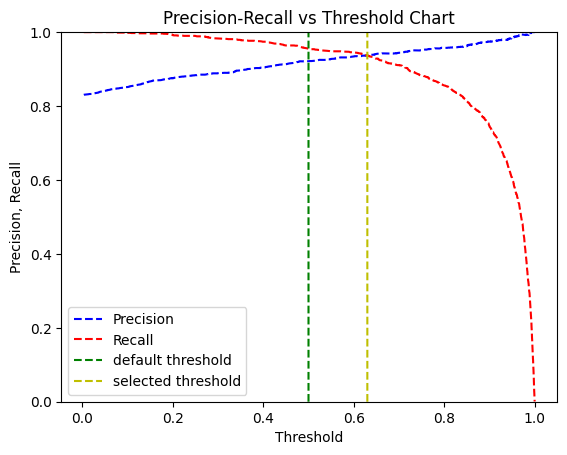

In [153]:
pred_y_tm=clf_tm_anova.predict(x_sa_anova_test) 

probs_y_tm=clf_tm_anova.predict_proba(x_sa_anova_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_sa_anova_test, probs_y_tm[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.plot(np.full(3252, 0.5),np.arange(0,1,1/3252), "g--", label="default threshold")
plt.plot(np.full(3252, 0.63),np.arange(0,1,1/3252), "y--", label="selected threshold")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### **Classification report**

#### **Predict using Train Data**

In [154]:
# Classification report
y_tm_anova_pred = clf_tm_anova.predict(x_tm_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_tm_anova_train, y_pred=y_tm_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_tm_anova_train, y_pred=y_tm_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.76      0.56      0.64      1175
           1       0.92      0.97      0.94      6300

    accuracy                           0.90      7475
   macro avg       0.84      0.76      0.79      7475
weighted avg       0.90      0.90      0.90      7475

Confusion matrix 
[[ 655  520]
 [ 205 6095]]


#### **Predict using Test Data**

In [155]:
# Classification report
y_tm_anova_pred = clf_tm_anova.predict(x_sa_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_tm_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_tm_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       323
           1       0.92      0.96      0.94      1580

    accuracy                           0.89      1903
   macro avg       0.83      0.78      0.80      1903
weighted avg       0.89      0.89      0.89      1903

Confusion matrix 
[[ 194  129]
 [  71 1509]]


#### **Predict using Test Data with new threshold**

In [156]:
y_pred_new_threshold = (clf_tm_anova.predict_proba(x_sa_anova_test)[:,1]>=0.63).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_sa_anova_test, y_pred=y_pred_new_threshold))

Classification report 
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       323
           1       0.94      0.94      0.94      1580

    accuracy                           0.90      1903
   macro avg       0.81      0.82      0.81      1903
weighted avg       0.90      0.90      0.90      1903

Confusion matrix 
[[ 224   99]
 [ 100 1480]]


## **Classification report for pre-cut data set**

In [157]:
check = df_LE_check.copy()

for col in check.columns:
    if col not in clf_sa_anova.feature_names_in_ and col != 'Attrition_Flag':
        check.drop(col, axis=1, inplace=True)
checkx = check.drop(['Attrition_Flag'], axis = 1)
checky = check['Attrition_Flag']

#### **Resampling Method 0** : No Resampling 

In [158]:
y_pred_sa = (clf_sa_anova.predict_proba(checkx)[:,1]>=0.67).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=checky, y_pred=y_pred_sa))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=checky, y_pred=y_pred_sa))

Classification report 
              precision    recall  f1-score   support

           0       0.64      0.77      0.70        77
           1       0.96      0.92      0.94       430

    accuracy                           0.90       507
   macro avg       0.80      0.84      0.82       507
weighted avg       0.91      0.90      0.90       507

Confusion matrix 
[[ 59  18]
 [ 33 397]]


#### **Resampling Method 1** : SMOTE

In [159]:
y_pred_up = (clf_up_anova.predict_proba(checkx)[:,1]>=0.22).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=checky, y_pred=y_pred_up))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=checky, y_pred=y_pred_up))

Classification report 
              precision    recall  f1-score   support

           0       0.66      0.71      0.69        77
           1       0.95      0.93      0.94       430

    accuracy                           0.90       507
   macro avg       0.81      0.82      0.81       507
weighted avg       0.90      0.90      0.90       507

Confusion matrix 
[[ 55  22]
 [ 28 402]]


#### **Resampling Method 2** : RandomUnderSampler

In [160]:
y_pred_dw = (clf_dw_anova.predict_proba(checkx)[:,1]>=0.23).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=checky, y_pred=y_pred_dw))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=checky, y_pred=y_pred_dw))

Classification report 
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        77
           1       0.95      0.94      0.95       430

    accuracy                           0.91       507
   macro avg       0.82      0.85      0.83       507
weighted avg       0.91      0.91      0.91       507

Confusion matrix 
[[ 58  19]
 [ 27 403]]


#### **Resampling Method 3** : Tomek Links

In [161]:
y_pred_tm = (clf_tm_anova.predict_proba(checkx)[:,1]>=0.63).astype(int)

print("Classification report \n=======================")
print(classification_report(y_true=checky, y_pred=y_pred_tm))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=checky, y_pred=y_pred_tm))

Classification report 
              precision    recall  f1-score   support

           0       0.64      0.77      0.70        77
           1       0.96      0.92      0.94       430

    accuracy                           0.90       507
   macro avg       0.80      0.84      0.82       507
weighted avg       0.91      0.90      0.90       507

Confusion matrix 
[[ 59  18]
 [ 33 397]]


# **Results & Conclusion**

Using One-Hot Encoding with Min-Max Scaler, resulted in the model score:

|Output|Precision|Recall|f1-score|Model Score (Accuracy)|Predict using|Amount of Data|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|0.81|0.46|0.59|0.90|Train Data|8085|
|1|0.91|0.98|0.94|0.90|Train Data|8085|
|0|0.85|0.48|0.61|0.90|Test Data|2022|
|1|0.90|0.98|0.94|0.90|Test Data|2022|

Using One-Hot Encoding with Standard Scaler, resulted in the model score:

|Output|Precision|Recall|f1-score|Model Score (Accuracy)|Predict using|Amount of Data|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|0.77|0.49|0.60|0.90|Train Data|8085|
|1|0.91|0.97|0.94|0.90|Train Data|8085|
|0|0.80|0.49|0.61|0.89|Test Data|2022|
|1|0.90|0.97|0.94|0.89|Test Data|2022|

Using One-Hot Encoding with Robust Scaler, resulted in the model score:

|Output|Precision|Recall|f1-score|Model Score (Accuracy)|Predict using|Amount of Data|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|0.77|0.51|0.62|0.90|Train Data|8085|
|1|0.91|0.97|0.94|0.90|Train Data|8085|
|0|0.80|0.52|0.63|0.90|Test Data|2022|
|1|0.91|0.97|0.94|0.90|Test Data|2022|

Using Label Encoding with Robust Scaler, resulted in the model score:

|Output|Precision|Recall|f1-score|Model Score (Accuracy)|Predict using|Amount of Data|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|0.77|0.51|0.62|0.90|Train Data|8085|
|1|0.91|0.97|0.94|0.90|Train Data|8085|
|0|0.80|0.52|0.63|0.90|Test Data|2022|
|1|0.91|0.97|0.94|0.90|Test Data|2022|

Using Label Encoding with Min-Max Scaler, resulted in the model score:

|Output|Precision|Recall|f1-score|Model Score (Accuracy)|Predict using|Amount of Data|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|0.81|0.46|0.59|0.90|Train Data|8085|
|1|0.91|0.98|0.94|0.90|Train Data|8085|
|0|0.85|0.48|0.61|0.90|Test Data|2022|
|1|0.90|0.98|0.94|0.90|Test Data|2022|

From all 5 methods, we can conclude that using different encoders won't impact the test result because the features we selected using ANOVA are the same. Furthermore, from using 3 different scalers, the best scaler for this dataset is 'Robust Scaler'. This is because 'Robust Scaler' is for datasets with skewed distribution and outliers, while Min-Max Scaler is for datasets that isn't distorted (this dataset is distorted) and Standard Scaler is for datasets that conforms to normal distribution.

Using log transformation and data resampling, resulted in the model score in Target class(Attrition_Flag = 0):

1.) Train Data

Precision|Recall|f1-score|Model Score (Accuracy)|Resampling  Method|Amount of Data|Predict using|
:-:|:-:|:-:|:-:|:-:|:-:|:-:|
0.76|0.49|0.60|0.90|No Resampling|7608|Train Data|
0.84|0.86|0.85|0.85|SMOTE|12866|Train Data|
0.83|0.85|0.84|0.84|RandomUnderSampler|2350|Train Data|
0.76|0.56|0.64|0.90|Tomek Links|7475|Train Data|

2.) Test Data

Precision|Recall|f1-score|Model Score (Accuracy)|Resampling  Method|Amount of Data|Predict using|
:-:|:-:|:-:|:-:|:-:|:-:|:-:|
0.78|0.54|0.64|0.90|No Resampling|1903|Test Data|
0.50|0.85|0.63|0.83|SMOTE|1903|Test Data|
0.51|0.85|0.63|0.83|RandomUnderSampler|1903|Test Data|
0.73|0.60|0.66|0.89|Tomek Links|1903|Test Data|

3.) Test Data with selected thereshold

Precision|Recall|f1-score|Model Score (Accuracy)|Resampling  Method|Amount of Data|Predict using|
:-:|:-:|:-:|:-:|:-:|:-:|:-:|
0.70|0.70|0.70|0.90|No Resampling|1903|Test Data|
0.68|0.65|0.66|0.90|SMOTE|1903|Test Data|
0.69|0.68|0.68|0.89|RandomUnderSampler|1903|Test Data|
0.69|0.69|0.69|0.90|Tomek Links|1903|Test Data|

4) pre-cut Data with selected thereshold

Precision|Recall|f1-score|Model Score (Accuracy)|Resampling  Method|Amount of Data|Predict using|
:-:|:-:|:-:|:-:|:-:|:-:|:-:|
0.64|0.77|0.70|0.90|No Resampling|507|pre-cut Data|
0.66|0.71|0.69|0.90|SMOTE|507|pre-cut Data|
0.68|0.75|0.72|0.91|RandomUnderSampler|507|pre-cut Data|
0.64|0.77|0.70|0.90|Tomek 507|507|pre-cut Data|

From the experiment we can see that when we apply the SMOTE and RandomUnderSampler on train data, both have very high scores in average but when apply to the test data Precision drop significantly(84% to 51%) considered to be Overfitting. But when we change the model threshod all of the method perform likely well(64%-70% Precision,Recall)in both test data and pre-cut data

Comparing no resampling to any method of resampling, we can conclude that 'this dataset' <u>is not fit for using Tomek method</u> to resample data. This is because, according to <a href='https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/'>this website</a>, Tomek is basically a pair of data points from different classes (nearest-neighbors). The objective is to drop the sample that corresponds to the
majority and thereby minimalizing the count of the dominating label. However, as you can see from the graphs below, this dataset contains a lot of data with low variance between class. SMOTE is not fit for 'this dataset' to because it generate new samples in by interpolation. However, the samples used to interpolate/generate new synthetic samples differ. So, SMOTE connect inliers and outliers works selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line ,according to <a href='https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/'>this website</a>. But when apply to this dataset it did not work due to low variance between class(Same as Tomek).


<Figure size 2000x2000 with 0 Axes>

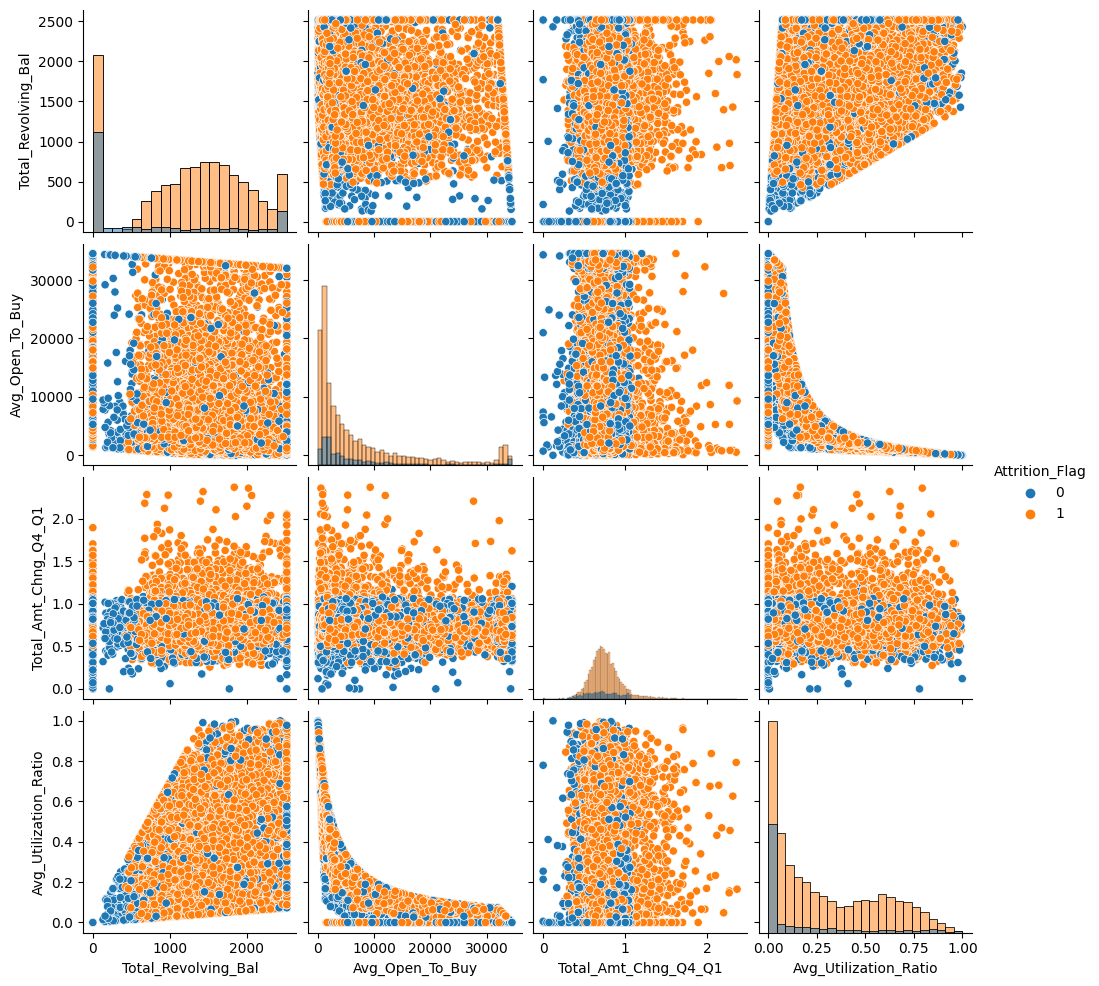

In [162]:
# Plot variance example
plt.figure(figsize=(20,20))
sns.pairplot(df[['Attrition_Flag', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1','Avg_Utilization_Ratio']], diag_kind="hist", hue="Attrition_Flag")